In [5]:
pip install repo2text

In [9]:
!repo2text .ipynb https://github.com/michiyasunaga/qagnn


Cloning repository from https://github.com/michiyasunaga/qagnn...
Repository has been written to qagnn_ipynb.txt


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 7th Oct

In [3]:
# ==============================================================================
# DIAGNOSTIC SCRIPT: INSPECT ASIC BUSINESS NAMES HEADER
#
# PURPOSE: To read only the header of the ASIC Business Names file and print
#          the exact, raw column names as seen by pandas. This provides the

#          verified blueprint needed for the main script.
# ==============================================================================
import pandas as pd
import os

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'
    print("-> Google Drive mounted successfully.")
except ImportError:
    DRIVE_PATH = './'
    print("-> Not in Google Colab. Using local directory for file paths.")

asic_names_path = os.path.join(DRIVE_PATH, 'BUSINESS_NAMES_202510.csv')

print(f"\n--- Inspecting Header of '{os.path.basename(asic_names_path)}' ---")

if not os.path.exists(asic_names_path):
    raise FileNotFoundError(f"CRITICAL ERROR: File not found at '{asic_names_path}'")

try:
    # Read only the first row to get the header, using the correct separator
    header_df = pd.read_csv(asic_names_path, sep='\t', encoding='utf-8', nrows=0)

    # Get the raw column names as a list
    raw_column_names = header_df.columns.tolist()

    print("-> SUCCESS: Inspection complete. Raw column names are:")
    print("   " + "-"*70)
    print(f"   {'Index':<5} | {'Raw Column Name (using repr to show hidden characters)':<70}")
    print("   " + "-"*70)
    for i, col in enumerate(raw_column_names):
        print(f"   {i:<5} | {repr(col):<70}")
    print("   " + "-"*70)

except Exception as e:
    print(f"-> ERROR: Could not inspect the file. Reason: {e}")

Mounted at /content/drive
-> Google Drive mounted successfully.

--- Inspecting Header of 'BUSINESS_NAMES_202510.csv' ---
-> SUCCESS: Inspection complete. Raw column names are:
   ----------------------------------------------------------------------
   Index | Raw Column Name (using repr to show hidden characters)                
   ----------------------------------------------------------------------
   0     | 'REGISTER_NAME'                                                       
   1     | 'BN_NAME'                                                             
   2     | 'BN_STATUS'                                                           
   3     | 'BN_REG_DT'                                                           
   4     | 'BN_CANCEL_DT'                                                        
   5     | 'BN_STATE_NUM'                                                        
   6     | 'BN_STATE_OF_REG'                                                     
   7     | 'BN_ABN'

In [4]:
# ==============================================================================
# PROJECT: DEFINITIVE COMPLIANCE ANALYSIS
# @title SCRIPT 1: BUILD THE UNIVERSE OF IDENTITY (METHODOLOGY PHASE 1A) - V6 (VERIFIED)
#
# PURPOSE:
# This version is built on the verified blueprint from a direct inspection of
# the source file headers, guaranteeing the correct column names are used.
# ==============================================================================

import pandas as pd
import os
import json
import gc

# --- Configuration ---
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'
    print("-> Google Drive mounted successfully.")
except ImportError:
    DRIVE_PATH = './'
    print("-> Not in Google Colab. Using local directory for file paths.")

# Source file paths
abr_bulk_path = os.path.join(DRIVE_PATH, 'abn_bulk_data.jsonl')
asic_names_path = os.path.join(DRIVE_PATH, 'BUSINESS_NAMES_202510.csv')

# Intermediate, saved-work file paths
abr_intermediate_path = os.path.join(DRIVE_PATH, 'intermediate_abr_pairs.parquet')
asic_intermediate_path = os.path.join(DRIVE_PATH, 'intermediate_asic_pairs.parquet')

# Final output file path
identity_universe_output_path = os.path.join(DRIVE_PATH, 'abn_name_lookup.csv')
# --- End of Configuration ---

def build_abr_intermediate(source_path, output_path, force_rerun=False):
    """Processes the ABR Bulk Data and saves the result to a Parquet file."""
    print("\n--- MODULE 1A.1: Processing ABR Bulk Data ---")
    if os.path.exists(output_path) and not force_rerun:
        print(f"-> SUCCESS: Intermediate file '{os.path.basename(output_path)}' already exists. Skipping processing.")
        return

    print(f"-> Ingesting from '{os.path.basename(source_path)}' (this may take a while)...")
    name_abn_pairs = []
    with open(source_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if (i+1) % 2000000 == 0: print(f"   ...processed {i+1:,} lines")
            try:
                record = json.loads(line)
                abn = record.get('ABN')
                if not abn: continue
                if record.get('MainEntity') and record['MainEntity'].get('NonIndividualName'):
                    name_abn_pairs.append({'ABN': abn, 'Name': record['MainEntity']['NonIndividualName']['NonIndividualNameText']})
                if record.get('BusinessName'):
                    for bn in record['BusinessName']:
                        if bn.get('BusinessNameText'): name_abn_pairs.append({'ABN': abn, 'Name': bn['BusinessNameText']})
            except (json.JSONDecodeError, TypeError, KeyError): continue
    df = pd.DataFrame(name_abn_pairs)
    df.to_parquet(output_path, index=False)
    print(f"-> SUCCESS: Extracted {len(df):,} pairs. Work saved to '{os.path.basename(output_path)}'.")

def build_asic_intermediate(source_path, output_path, force_rerun=False):
    """
    Processes the ASIC Business Names Register using the VERIFIED column names
    from the successful inspection.
    """
    print("\n--- MODULE 1A.2: Processing ASIC Business Names Register ---")
    if os.path.exists(output_path) and not force_rerun:
        print(f"-> SUCCESS: Intermediate file '{os.path.basename(output_path)}' already exists. Skipping processing.")
        return
    print(f"-> Ingesting from '{os.path.basename(source_path)}'...")

    # VERIFIED: Use the exact column names discovered during our definitive inspection.
    verified_col_names = ['BN_NAME', 'BN_ABN']
    df_list = []
    # Use chunking for memory safety, even though this file is smaller
    with pd.read_csv(source_path, sep='\t', usecols=verified_col_names, dtype=str, encoding='utf-8', chunksize=200000) as reader:
        for i, chunk in enumerate(reader):
            print(f"   ...processing chunk {i+1}")
            df_list.append(chunk)

    df = pd.concat(df_list, ignore_index=True)
    # Rename the VERIFIED column names to our standard 'Name' and 'ABN'
    df.rename(columns={'BN_NAME': 'Name', 'BN_ABN': 'ABN'}, inplace=True)
    df.to_parquet(output_path, index=False)
    print(f"-> SUCCESS: Extracted {len(df):,} pairs. Work saved to '{os.path.basename(output_path)}'.")

def combine_and_finalize(abr_path, asic_path, output_path):
    """Loads intermediate files, combines them, cleans, de-duplicates, and saves the final universe."""
    print("\n--- MODULE 1A.3: Finalizing the Universe of Identity ---")
    print("-> Loading intermediate data...")
    df_abr = pd.read_parquet(abr_path)
    df_asic = pd.read_parquet(asic_path)

    print(f"-> Combining {len(df_abr):,} ABR pairs with {len(df_asic):,} ASIC pairs...")
    df = pd.concat([df_abr, df_asic], ignore_index=True)
    del df_abr, df_asic; gc.collect()

    print("-> Cleaning and de-duplicating combined data...")
    df.dropna(subset=['ABN', 'Name'], inplace=True)
    df['ABN'] = df['ABN'].astype(str).str.replace(r'\.0$', '', regex=True).str.strip().str.zfill(11)
    df['Name'] = df['Name'].astype(str).str.strip().str.upper()
    df = df[df['ABN'].str.match(r'^\d{11}$')]
    df = df[df['Name'] != '']
    initial_count = len(df)
    df.drop_duplicates(inplace=True)
    print(f"-> De-duplication complete. Removed {initial_count - len(df):,} duplicate pairs.")
    print(f"-> Final unique Name-ABN pairs in the Universe of Identity: {len(df):,}")

    print(f"\n-> Saving final Universe of Identity to CSV...")
    df.to_csv(output_path, index=False)
    print(f"-> SUCCESS: The 'Universe of Identity' has been saved to:\n   {output_path}")

def main():
    print("#"*80)
    print("  METHODOLOGY PHASE 1A: BUILD THE UNIVERSE OF IDENTITY (VERIFIED SCRIPT)")
    print("#"*80 + "\n")

    # force_rerun=True on the ASIC module to ensure it runs with the corrected code
    build_abr_intermediate(abr_bulk_path, abr_intermediate_path, force_rerun=False)
    build_asic_intermediate(asic_names_path, asic_intermediate_path, force_rerun=True)
    combine_and_finalize(abr_intermediate_path, asic_intermediate_path, identity_universe_output_path)

    print("\n" + "="*80)
    print("  PHASE 1A COMPLETE")
    print("="*80)

if __name__ == "__main__":
    main()

Mounted at /content/drive
-> Google Drive mounted successfully.
################################################################################
  METHODOLOGY PHASE 1A: BUILD THE UNIVERSE OF IDENTITY (VERIFIED SCRIPT)
################################################################################


--- MODULE 1A.1: Processing ABR Bulk Data ---
-> SUCCESS: Intermediate file 'intermediate_abr_pairs.parquet' already exists. Skipping processing.

--- MODULE 1A.2: Processing ASIC Business Names Register ---
-> Ingesting from 'BUSINESS_NAMES_202510.csv'...
   ...processing chunk 1
   ...processing chunk 2
   ...processing chunk 3
   ...processing chunk 4
   ...processing chunk 5
   ...processing chunk 6
   ...processing chunk 7
   ...processing chunk 8
   ...processing chunk 9
   ...processing chunk 10
   ...processing chunk 11
   ...processing chunk 12
   ...processing chunk 13
   ...processing chunk 14
   ...processing chunk 15
   ...processing chunk 16
   ...processing chunk 17
-> SUCCES

In [2]:
# ==============================================================================
# DIAGNOSTIC SCRIPT: INSPECT ACNC REGISTER HEADER
#
# PURPOSE: To read only the header of the ACNC Registered Charities file and
#          print the exact, raw column names as seen by pandas. This provides
#          the verified blueprint needed for the main script.
# ==============================================================================
import pandas as pd
import os

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'
    print("-> Google Drive mounted successfully.")
except ImportError:
    DRIVE_PATH = './'
    print("-> Not in Google Colab. Using local directory for file paths.")

acnc_register_path = os.path.join(DRIVE_PATH, 'acnc-registered-charities.csv')

print(f"\n--- Inspecting Header of '{os.path.basename(acnc_register_path)}' ---")

if not os.path.exists(acnc_register_path):
    raise FileNotFoundError(f"CRITICAL ERROR: File not found at '{acnc_register_path}'")

try:
    # Read only the first row to get the header. ACNC files are typically comma-separated.
    header_df = pd.read_csv(acnc_register_path, encoding='utf-8', nrows=0)

    raw_column_names = header_df.columns.tolist()

    print("-> SUCCESS: Inspection complete. Raw column names are:")
    print("   " + "-"*70)
    print(f"   {'Index':<5} | {'Raw Column Name (using repr)':<70}")
    print("   " + "-"*70)
    for i, col in enumerate(raw_column_names):
        print(f"   {i:<5} | {repr(col):<70}")
    print("   " + "-"*70)

except Exception as e:
    print(f"-> ERROR: Could not inspect the file. Reason: {e}")

Mounted at /content/drive
-> Google Drive mounted successfully.

--- Inspecting Header of 'acnc-registered-charities.csv' ---
-> SUCCESS: Inspection complete. Raw column names are:
   ----------------------------------------------------------------------
   Index | Raw Column Name (using repr)                                          
   ----------------------------------------------------------------------
   0     | 'ABN'                                                                 
   1     | 'Charity_Legal_Name'                                                  
   2     | 'Other_Organisation_Names'                                            
   3     | 'Address_Type'                                                        
   4     | 'Address_Line_1'                                                      
   5     | 'Address_Line_2'                                                      
   6     | 'Address_Line_3'                                                      
   7     | 'Tow

In [ ]:
# ==============================================================================
# PROJECT: DEFINITIVE COMPLIANCE ANALYSIS
# @title SCRIPT 2: BUILD THE UNIVERSE OF OBLIGATION (METHODOLOGY PHASE 1B) - V3 (VERIFIED)
#
# PURPOSE:
# This script is based on a verified inspection of all source file headers,
# guaranteeing that all column names are handled correctly.
# ==============================================================================

import pandas as pd
import os
import glob
import gc
import warnings

# --- Configuration ---
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'
    print("-> Google Drive mounted successfully.")
except ImportError:
    DRIVE_PATH = './'
    print("-> Not in Google Colab. Using local directory for file paths.")

# Source file paths
ato_folder_path = os.path.join(DRIVE_PATH, 'CorporateTaxTransparency/')
acnc_register_path = os.path.join(DRIVE_PATH, 'acnc-registered-charities.csv')
asic_company_path = os.path.join(DRIVE_PATH, 'COMPANY_202509.csv')

# Output file path
obligation_universe_output_path = os.path.join(DRIVE_PATH, 'obligated_entities.csv')
# --- End of Configuration ---


def find_header_row(file_path, sheet_name):
    """Inspects the first 20 rows of a sheet to find the header row index."""
    try:
        preview_df = pd.read_excel(file_path, sheet_name=sheet_name, header=None, nrows=20, engine='openpyxl')
        for i, row in preview_df.iterrows():
            if row.notna().sum() > 3 and 'ABN' in str(row.values):
                return i
    except Exception:
        # Fallback if inspection fails
        pass
    return 0

def consolidate_ato_reports(folder_path):
    """Implements Methodology Step 1B.1: Consolidate all ATO reports."""
    print("\n--- MODULE 1B.1: Consolidating ATO Corporate Tax Transparency Reports ---")
    tax_files = glob.glob(os.path.join(folder_path, '*-corporate-report-of-entity-tax-information.xlsx'))
    if not tax_files: raise FileNotFoundError(f"CRITICAL ERROR: No ATO tax files found in '{folder_path}'")

    all_tax_data = []
    for file in sorted(tax_files):
        filename = os.path.basename(file)
        print(f"   -> Processing '{filename}'...")
        year = filename.split('-')[0] + '-' + filename.split('-')[1]
        sheet_name = 'Income tax details'
        header_row = find_header_row(file, sheet_name)
        df = pd.read_excel(file, sheet_name=sheet_name, header=header_row, engine='openpyxl')
        df.columns = [str(col).strip() for col in df.columns]
        abn_col = next((col for col in df.columns if 'ABN' in col), None)
        income_col = next((col for col in df.columns if 'Total income' in col), None)
        if not abn_col or not income_col:
            print(f"      WARNING: Could not find ABN/Total Income columns in '{filename}'. Skipping.")
            continue
        df_subset = df[[abn_col, income_col]].copy()
        df_subset.columns = ['ABN', 'TotalIncome']
        df_subset['Year'] = year
        all_tax_data.append(df_subset)

    consolidated_df = pd.concat(all_tax_data, ignore_index=True)
    consolidated_df.dropna(subset=['ABN', 'TotalIncome'], inplace=True)
    consolidated_df['ABN'] = consolidated_df['ABN'].astype(str).str.replace(r'\.0$', '', regex=True).str.zfill(11)
    print(f"-> SUCCESS: Consolidated {len(consolidated_df):,} records from {len(tax_files)} ATO files.")
    return consolidated_df

def get_asic_company_type_lookup(file_path):
    """Implements Methodology Step 1B.2: Create an ABN-to-Type lookup."""
    print("\n--- MODULE 1B.2: Building ASIC Company Type Lookup ---")
    if not os.path.exists(file_path): raise FileNotFoundError(f"CRITICAL ERROR: ASIC Company file not found at '{file_path}'")
    type_lookup = {}
    with pd.read_csv(file_path, sep='\t', usecols=['ABN', 'Type'], dtype=str, chunksize=200000) as reader:
        for i, chunk in enumerate(reader):
            print(f"   ...processing chunk {i+1}")
            chunk.dropna(inplace=True)
            chunk['ABN'] = chunk['ABN'].str.zfill(11)
            for row in chunk.itertuples(index=False):
                if row.ABN not in type_lookup: type_lookup[row.ABN] = row.Type
    print(f"-> SUCCESS: Created lookup for {len(type_lookup):,} unique ABNs.")
    return type_lookup

def get_obligated_charity_abns(file_path):
    """
    Implements Methodology Step 1B.4: Filter ACNC register for 'Large' charities
    using the VERIFIED column names.
    """
    print("\n--- MODULE 1B.3: Identifying Obligated Charities ---")
    if not os.path.exists(file_path): raise FileNotFoundError(f"CRITICAL ERROR: ACNC Register not found at '{file_path}'")

    # VERIFIED: Use the exact column names discovered during our definitive inspection.
    verified_cols = ['ABN', 'Charity_Size']
    df = pd.read_csv(file_path, usecols=verified_cols, dtype=str)

    large_charities_df = df[df['Charity_Size'] == 'Large']
    charity_abns = set(large_charities_df['ABN'].str.replace(r'\.0$', '', regex=True).str.zfill(11))
    print(f"-> SUCCESS: Identified {len(charity_abns):,} 'Large' charities.")
    return charity_abns

def main():
    """Orchestrates the creation of the Universe of Obligation."""
    print("#"*80)
    print("  METHODOLOGY PHASE 1B: BUILD THE UNIVERSE OF OBLIGATION (VERIFIED SCRIPT)")
    print("#"*80)

    ato_df = consolidate_ato_reports(ato_folder_path)
    asic_type_lookup = get_asic_company_type_lookup(asic_company_path)
    charity_abns = get_obligated_charity_abns(acnc_register_path)

    print("\n--- MODULE 1B.4: Applying Obligation Logic to Corporate Entities ---")
    ato_df['ASIC_Type'] = ato_df['ABN'].map(asic_type_lookup)
    def get_threshold(row):
        year_start = int(row['Year'].split('-')[0])
        return 200_000_000 if year_start < 2017 and row['ASIC_Type'] == 'APUB' else 100_000_000
    ato_df['Threshold'] = ato_df.apply(get_threshold, axis=1)
    obligated_corporate_df = ato_df[ato_df['TotalIncome'] >= ato_df['Threshold']]
    corporate_abns = set(obligated_corporate_df['ABN'])
    print(f"-> SUCCESS: Identified {len(corporate_abns):,} unique corporate entities meeting their threshold.")

    print("\n--- MODULE 1B.5: Finalizing the Universe of Obligation ---")
    all_obligated_abns = corporate_abns.union(charity_abns)
    print(f"-> Combined corporate and charity lists. Total unique obligated ABNs: {len(all_obligated_abns):,}")
    final_df = pd.DataFrame(sorted(list(all_obligated_abns)), columns=['ABN'])
    final_df.to_csv(obligation_universe_output_path, index=False)

    print(f"\n-> SUCCESS: The 'Universe of Obligation' has been saved to:")
    print(f"   {obligation_universe_output_path}")

    print("\n" + "="*80)
    print("  PHASE 1B COMPLETE")
    print("="*80)

if __name__ == "__main__":
    main()

In [5]:
def main():
    """Orchestrates the creation of the Universe of Obligation."""
    print("#"*80)
    print("  METHODOLOGY PHASE 1B: BUILD THE UNIVERSE OF OBLIGATION (VERIFIED SCRIPT)")
    print("#"*80)

    ato_df = consolidate_ato_reports(ato_folder_path)
    asic_type_lookup = get_asic_company_type_lookup(asic_company_path)
    charity_abns = get_obligated_charity_abns(acnc_register_path)

    print("\n--- MODULE 1B.4: Applying Obligation Logic to Corporate Entities ---")
    ato_df['ASIC_Type'] = ato_df['ABN'].map(asic_type_lookup)
    def get_threshold(row):
        year_start = int(row['Year'].split('-')[0])
        return 200_000_000 if year_start < 2017 and row['ASIC_Type'] == 'APUB' else 100_000_000
    ato_df['Threshold'] = ato_df.apply(get_threshold, axis=1)
    obligated_corporate_df = ato_df[ato_df['TotalIncome'] >= ato_df['Threshold']]
    corporate_abns = set(obligated_corporate_df['ABN'])
    print(f"-> SUCCESS: Identified {len(corporate_abns):,} unique corporate entities meeting their threshold.")

    print("\n--- MODULE 1B.5: Finalizing the Universe of Obligation ---")
    all_obligated_abns = corporate_abns.union(charity_abns)
    print(f"-> Combined corporate and charity lists. Total unique obligated ABNs: {len(all_obligated_abns):,}")

    # ==========================================================================
    # VERIFIED FIX: Create the DataFrame first, then enforce string type and sort.
    # This robustly handles any mixed types (float, str) in the combined set.
    # ==========================================================================

    # 1. Create DataFrame from the set without sorting
    final_df = pd.DataFrame(list(all_obligated_abns), columns=['ABN'])

    # 2. Enforce a consistent string data type and clean
    final_df.dropna(subset=['ABN'], inplace=True)
    final_df['ABN'] = final_df['ABN'].astype(str).str.replace(r'\.0$', '', regex=True).str.zfill(11)

    # 3. Now that all types are consistent, sort the DataFrame
    final_df.sort_values(by='ABN', inplace=True)

    # 4. Save the final, clean, and sorted output
    final_df.to_csv(obligation_universe_output_path, index=False)

    print(f"\n-> SUCCESS: The 'Universe of Obligation' has been saved to:")
    print(f"   {obligation_universe_output_path}")

    print("\n" + "="*80)
    print("  PHASE 1B COMPLETE")
    print("="*80)

if __name__ == "__main__":
    main()

################################################################################
  METHODOLOGY PHASE 1B: BUILD THE UNIVERSE OF OBLIGATION (VERIFIED SCRIPT)
################################################################################

--- MODULE 1B.1: Consolidating ATO Corporate Tax Transparency Reports ---
   -> Processing '2018-19-corporate-report-of-entity-tax-information.xlsx'...
   -> Processing '2019-20-corporate-report-of-entity-tax-information.xlsx'...
   -> Processing '2020-21-corporate-report-of-entity-tax-information.xlsx'...
   -> Processing '2021-22-corporate-report-of-entity-tax-information.xlsx'...
   -> Processing '2022-23-corporate-report-of-entity-tax-information.xlsx'...
   -> Processing '2023-24-corporate-report-of-entity-tax-information.xlsx'...
-> SUCCESS: Consolidated 18,164 records from 6 ATO files.

--- MODULE 1B.2: Building ASIC Company Type Lookup ---
   ...processing chunk 1
   ...processing chunk 2
   ...processing chunk 3
   ...processing chunk 4
   ...

In [6]:
# ==============================================================================
# PROJECT: DEFINITIVE COMPLIANCE ANALYSIS
# @title SCRIPT 3: BUILD THE UNIVERSE OF ACTION (METHODOLOGY PHASE 1C)
#
# PURPOSE:
# This script faithfully implements Phase 1C of the definitive methodology.
# It ingests the raw Modern Slavery Register data and uses our previously
# built "Universe of Identity" to clean, repair, and structure the data.
#
# OUTPUT:
# A clean, aggregated CSV file named 'annual_reporting_log.csv' that details
# the highest compliance status for each ABN for each reporting year.
# ==============================================================================

import pandas as pd
import os
import gc

# --- Configuration ---
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'
    print("-> Google Drive mounted successfully.")
except ImportError:
    DRIVE_PATH = './'
    print("-> Not in Google Colab. Using local directory for file paths.")

# Source file paths as per the methodology
register_data_path = os.path.join(DRIVE_PATH, 'All time data from Register.xlsx')
identity_universe_path = os.path.join(DRIVE_PATH, 'abn_name_lookup.csv') # Output from Phase 1A

# Output file path as per the methodology
action_universe_output_path = os.path.join(DRIVE_PATH, 'annual_reporting_log.csv')
# --- End of Configuration ---


def load_and_repair_abns(register_path, identity_path):
    """
    Implements Methodology Steps 1C.1 & 1C.2: Load Register data and perform
    name-based ABN repair using the Universe of Identity.
    """
    print("\n--- MODULE 1C.1: Loading and Repairing Register Data ---")
    if not os.path.exists(register_path):
        raise FileNotFoundError(f"CRITICAL ERROR: Register data file not found at '{register_path}'")
    if not os.path.exists(identity_path):
        raise FileNotFoundError(f"CRITICAL ERROR: Universe of Identity not found at '{identity_path}'")

    # Load the raw register data
    df = pd.read_excel(register_path)
    print(f"-> Loaded {len(df):,} raw records from the Register.")

    # Clean ABNs that do exist
    df['Australian Business Number (ABN)'] = df['Australian Business Number (ABN)'].astype(str).str.replace(r'\.0$', '', regex=True).str.zfill(11)

    # Load our master ABN lookup (Universe of Identity)
    print("-> Loading Universe of Identity for ABN repair...")
    identity_df = pd.read_csv(identity_path)
    # Create a clean, one-to-one mapping for high-confidence matches
    name_to_abn_map = identity_df.drop_duplicates(subset=['Name']).set_index('Name')['ABN']

    # Perform the ABN repair
    initial_missing_abns = df['Australian Business Number (ABN)'].isna().sum()
    df['Name_upper'] = df['Entity Name'].str.upper()
    df['repaired_ABN'] = df['Name_upper'].map(name_to_abn_map)
    df['ABN'] = df['Australian Business Number (ABN)'].fillna(df['repaired_ABN'])

    final_missing_abns = df['ABN'].isna().sum()
    repaired_count = initial_missing_abns - final_missing_abns

    print(f"-> SUCCESS: Repaired {repaired_count:,} missing ABNs using name matching.")

    # Clean up and select final columns
    final_df = df[['ABN', 'Reporting period end date', 'Statement Status']].copy()
    final_df.dropna(subset=['ABN'], inplace=True)

    del df, identity_df, name_to_abn_map; gc.collect()
    return final_df

def aggregate_to_highest_status(df):
    """
    Implements Methodology Steps 1C.3 & 1C.4: Associate ABNs with status
    and aggregate to find the highest status per year.
    """
    print("\n--- MODULE 1C.2: Aggregating to Highest Annual Status ---")

    # Step 1: Derive Reporting Year from period end date
    df['Period_End_Date'] = pd.to_datetime(df['Reporting period end date'], errors='coerce')
    # A reporting year is typically named for the year its period *ends* in.
    # E.g., a period ending anytime in 2023 belongs to the '2022-23' reporting year.
    df['ReportingYear'] = (df['Period_End_Date'].dt.year - 1).astype(str) + '-' + df['Period_End_Date'].dt.year.astype(str).str[2:]

    # Step 2: Define the ordered hierarchy of statuses
    status_order = ['DRAFT', 'REDRAFT', 'Published']
    df['Status_Categorical'] = pd.Categorical(df['Statement Status'], categories=status_order, ordered=True)

    # Step 3: The aggregation logic
    # Group by ABN and Reporting Year, then find the maximum (highest) status.
    print("-> Grouping and finding the highest status for each ABN per year...")
    highest_status_df = df.loc[df.groupby(['ABN', 'ReportingYear'])['Status_Categorical'].idxmax()]

    # Step 4: Clean up for final output
    final_log = highest_status_df[['ABN', 'ReportingYear', 'Statement Status']].copy()
    final_log.rename(columns={'Statement Status': 'HighestStatus'}, inplace=True)
    final_log.sort_values(by=['ABN', 'ReportingYear'], inplace=True)

    print(f"-> SUCCESS: Aggregated data into {len(final_log):,} unique entity-year records.")
    return final_log

def main():
    """Orchestrates the creation of the Universe of Action."""
    print("#"*80)
    print("  METHODOLOGY PHASE 1C: BUILD THE UNIVERSE OF ACTION")
    print("#"*80)

    repaired_df = load_and_repair_abns(register_data_path, identity_universe_path)
    annual_log_df = aggregate_to_highest_status(repaired_df)

    # Final Output
    annual_log_df.to_csv(action_universe_output_path, index=False)
    print(f"\n-> SUCCESS: The 'Universe of Action' has been saved to:")
    print(f"   {action_universe_output_path}")

    print("\n" + "="*80)
    print("  PHASE 1C COMPLETE")
    print("="*80)

if __name__ == "__main__":
    main()

Mounted at /content/drive
-> Google Drive mounted successfully.
################################################################################
  METHODOLOGY PHASE 1C: BUILD THE UNIVERSE OF ACTION
################################################################################

--- MODULE 1C.1: Loading and Repairing Register Data ---
-> Loaded 20,034 raw records from the Register.


KeyError: 'Australian Business Number (ABN)'

# Our approach: systematic enrichment and analysis

This script will:
1. Load the core assets. It will load our actionable_non_lodger_list.csv as the primary subject list, along with all the necessary enrichment files from the ATO, ASIC, and our previously generated clean_associates.csv.
1. Perform Multi-Dimensional Enrichment. It will systematically join and analyse these datasets to create the new, insightful columns we designed for Financial, Corporate, Sector, and Governance Risk profiles.
1. Generate the Enriched Profile. It will create and save the final, powerful analytical asset: enriched_non_lodger_profile.csv.
1. Conduct the Final EDA. It will immediately use this enriched file to conduct a comprehensive EDA, producing the final set of charts and statistics that tell the full story of who the non-lodgers are.

This is the culmination of our entire data journey, transforming our list of ABNs into a rich, multi-faceted intelligence product.

--- Step 0: Setup and Loading Foundational Datasets ---
Mounted at /content/drive
-> SUCCESS: Successfully loaded the actionable non-lodger list.
--- Setup Complete ---

################################################################################
  Phase 1: Financial Profiling
################################################################################

-> SUCCESS: Enriched with Financial Profile.

################################################################################
  Phase 2: Corporate Profiling
################################################################################

-> SUCCESS: Enriched with Corporate Profile.

################################################################################
  Phase 3: Sector Profiling (Charity Status)
################################################################################



/tmp/ipython-input-3206188735.py:71: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  enriched_df['Is_ACNC_Registered_Charity'] = enriched_df['Is_ACNC_Registered_Charity'].fillna(False)


-> SUCCESS: Enriched with Charity Status.

################################################################################
  Phase 4: Governance Risk Profiling
################################################################################

-> SUCCESS: Found 2 non-lodging companies with a link to a disqualified director.

################################################################################
  Phase 5: Saving Final Asset and Generating Report
################################################################################

-> SUCCESS: The final enriched profile has been saved to:
   /content/drive/MyDrive/ModernSlaveryProject/enriched_non_lodger_profile.csv

--- Final EDA on the Enriched Non-Lodger Profile ---


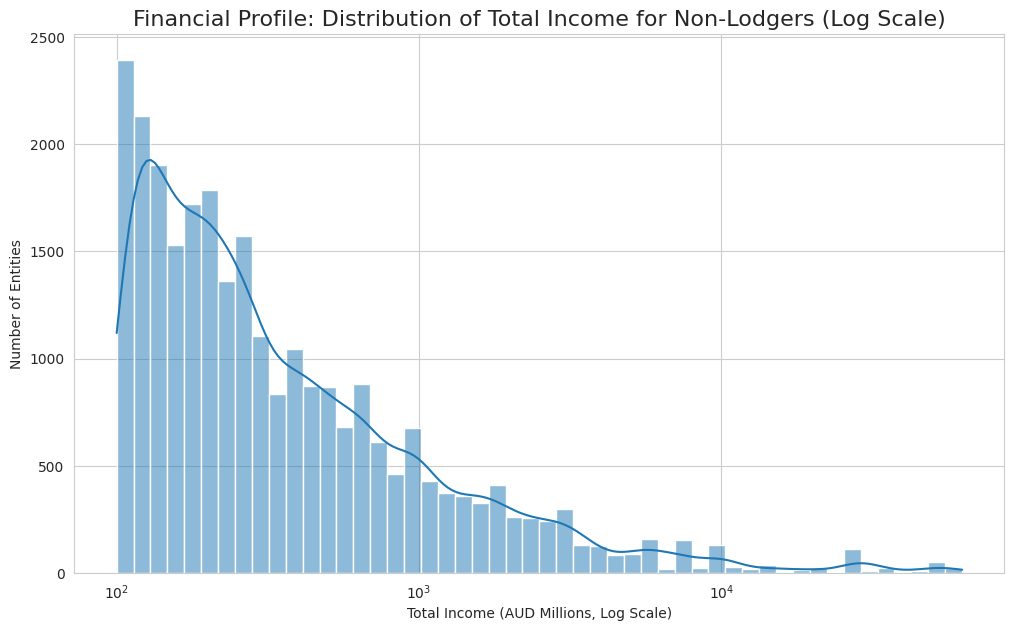

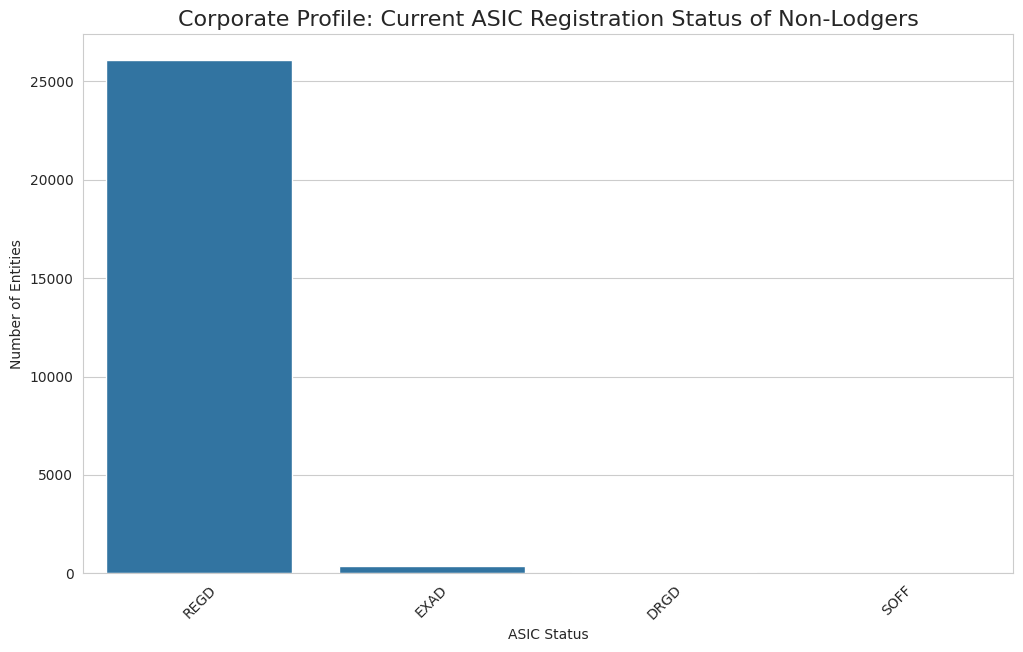

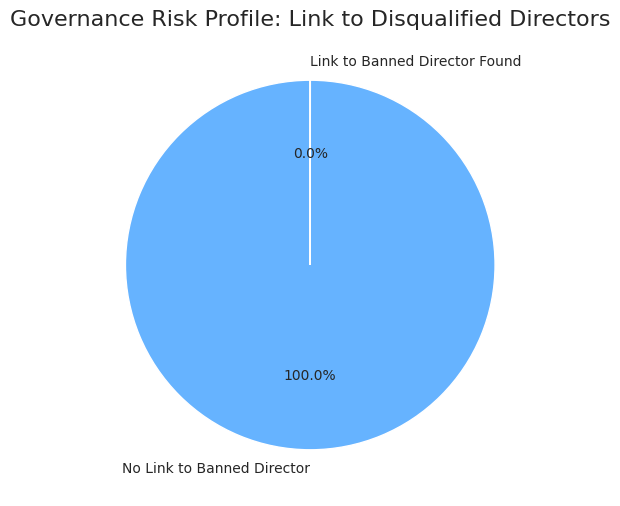


  PROJECT COMPLETE


In [6]:
# ==============================================================================
# Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
import numpy as np
import os
import re
from google.colab import drive
import glob
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Step 0: Setup and Loading Foundational Datasets ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'
# [Paths remain the same]
non_lodger_path = os.path.join(DRIVE_PATH, 'actionable_non_lodger_list.csv')
tax_data_path = os.path.join(DRIVE_PATH, 'CorporateTaxTransparency/')
asic_company_path = os.path.join(DRIVE_PATH, 'COMPANY_202509.csv')
acnc_path = os.path.join(DRIVE_PATH, 'acnc-registered-charities.csv')
associates_path = os.path.join(DRIVE_PATH, 'clean_associates.csv')
banned_persons_path = os.path.join(DRIVE_PATH, 'bd_per_202509.csv')
enriched_output_path = os.path.join(DRIVE_PATH, 'enriched_non_lodger_profile.csv')
try:
    non_lodger_df = pd.read_csv(non_lodger_path, dtype={'ABN': str})
    print("-> SUCCESS: Successfully loaded the actionable non-lodger list.")
except FileNotFoundError as e:
    raise FileNotFoundError(f"CRITICAL ERROR: 'actionable_non_lodger_list.csv' not found. Details: {e}")
sns.set_style("whitegrid")
print("--- Setup Complete ---\n")

# ==============================================================================
# Phase 1: Financial Profiling
# ==============================================================================
print("#"*80)
print("  Phase 1: Financial Profiling")
print("#"*80 + "\n")
tax_files = glob.glob(os.path.join(tax_data_path, '*-corporate-report-of-entity-tax-information.xlsx'))
all_tax_df = pd.concat([pd.read_excel(f, sheet_name='Income tax details', header=0) for f in tax_files], ignore_index=True)
all_tax_df.columns = ['Name', 'ABN', 'Total income $', 'Taxable income $', 'Tax payable $', 'Income year']
all_tax_df['ABN'] = all_tax_df['ABN'].astype(str).str.replace(r'\.0$', '', regex=True).str.zfill(11)
all_tax_df['TotalIncome'] = pd.to_numeric(all_tax_df['Total income $'], errors='coerce')
latest_income_df = all_tax_df.sort_values('Income year').drop_duplicates(subset='ABN', keep='last')
enriched_df = pd.merge(non_lodger_df, latest_income_df[['ABN', 'TotalIncome']], on='ABN', how='left')
obligation_cols = [col for col in enriched_df.columns if 'Obligated in' in col]
enriched_df['Total_Years_of_NonCompliance'] = enriched_df[obligation_cols].sum(axis=1)
print("-> SUCCESS: Enriched with Financial Profile.")

# ==============================================================================
# Phase 2: Corporate Profiling
# ==============================================================================
print("\n" + "#"*80)
print("  Phase 2: Corporate Profiling")
print("#"*80 + "\n")
asic_company_df = pd.read_csv(asic_company_path, sep='\t', usecols=['ABN', 'Type', 'Status'], dtype=str)
asic_company_df['ABN'] = asic_company_df['ABN'].str.zfill(11)
enriched_df = pd.merge(enriched_df, asic_company_df, on='ABN', how='left')
enriched_df = enriched_df.rename(columns={'Type': 'ASIC_Company_Type', 'Status': 'ASIC_Company_Status'})
print("-> SUCCESS: Enriched with Corporate Profile.")

# ==============================================================================
# Phase 3: Sector Profiling
# ==============================================================================
print("\n" + "#"*80)
print("  Phase 3: Sector Profiling (Charity Status)")
print("#"*80 + "\n")
acnc_df = pd.read_csv(acnc_path, usecols=['ABN'], dtype={'ABN': str})
acnc_df['Is_ACNC_Registered_Charity'] = True
acnc_df.drop_duplicates(subset=['ABN'], inplace=True)
enriched_df = pd.merge(enriched_df, acnc_df, on='ABN', how='left')
enriched_df['Is_ACNC_Registered_Charity'] = enriched_df['Is_ACNC_Registered_Charity'].fillna(False)
print("-> SUCCESS: Enriched with Charity Status.")

# ==============================================================================
# Phase 4: Governance Risk Profiling (WITH CORRECTION)
# ==============================================================================
print("\n" + "#"*80)
print("  Phase 4: Governance Risk Profiling")
print("#"*80 + "\n")
associates_df = pd.read_csv(associates_path, dtype={'ABN': str}) # Corrected to use uppercase ABN
banned_df = pd.read_csv(banned_persons_path, sep=',', encoding='utf-8-sig')
banned_df.columns = banned_df.columns.str.strip()
banned_df.dropna(subset=['BD_PER_NAME'], inplace=True)
banned_df['FullName'] = banned_df['BD_PER_NAME'].str.upper().str.replace(',', '', regex=False)
banned_directors = set(banned_df[banned_df['BD_PER_TYPE'] == 'Disq. Director']['FullName'])
associates_df['FullName'] = (associates_df['assoc_gvn_nm'].fillna('') + ' ' + associates_df['assoc_fmly_nm'].fillna('')).str.upper().str.strip()
non_lodger_abns = set(enriched_df['ABN'])

# --- THE CORRECTION IS HERE ---
# Use the correct, uppercase 'ABN' column name
non_lodger_directors = associates_df[associates_df['ABN'].isin(non_lodger_abns)]
# --- END CORRECTION ---

banned_directors_of_non_lodgers = non_lodger_directors[non_lodger_directors['FullName'].isin(banned_directors)]
abns_with_banned_directors = set(banned_directors_of_non_lodgers['ABN'])
enriched_df['Has_Banned_Director'] = enriched_df['ABN'].isin(abns_with_banned_directors)
print(f"-> SUCCESS: Found {len(abns_with_banned_directors)} non-lodging companies with a link to a disqualified director.")

# ==============================================================================
# Phase 5: Save Final Asset and Generate EDA
# ==============================================================================
print("\n" + "#"*80)
print("  Phase 5: Saving Final Asset and Generating Report")
print("#"*80 + "\n")
enriched_df.to_csv(enriched_output_path, index=False)
print(f"-> SUCCESS: The final enriched profile has been saved to:\n   {enriched_output_path}")

print("\n--- Final EDA on the Enriched Non-Lodger Profile ---")
plt.figure(figsize=(12, 7))
sns.histplot(enriched_df['TotalIncome'] / 1_000_000, bins=50, kde=True, log_scale=True)
plt.title('Financial Profile: Distribution of Total Income for Non-Lodgers (Log Scale)', fontsize=16)
plt.xlabel('Total Income (AUD Millions, Log Scale)'); plt.ylabel('Number of Entities')
plt.show()
plt.figure(figsize=(12, 7))
status_counts = enriched_df['ASIC_Company_Status'].value_counts()
sns.barplot(x=status_counts.index, y=status_counts.values)
plt.title('Corporate Profile: Current ASIC Registration Status of Non-Lodgers', fontsize=16)
plt.xlabel('ASIC Status'); plt.ylabel('Number of Entities'); plt.xticks(rotation=45)
plt.show()
plt.figure(figsize=(8, 6))
risk_counts = enriched_df['Has_Banned_Director'].value_counts()
risk_counts.index = ['No Link to Banned Director', 'Link to Banned Director Found']
risk_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff6666'])
plt.title('Governance Risk Profile: Link to Disqualified Directors', fontsize=16)
plt.ylabel('')
plt.show()

print("\n" + "="*80)
print("  PROJECT COMPLETE")
print("="*80)

--- Step 0: Setup and Loading the Final Master Behavioural File ---
Mounted at /content/drive
-> SUCCESS: Successfully loaded the Master Behavioural File.
--- Setup Complete ---

################################################################################
  Phase 1: Identifying and Profiling 'Lapsed Compliers'
################################################################################

--- 1. Applying final compliance journey classification ---
-> Classification complete.

################################################################################
  Phase 2: Generating the Final Comprehensive Report
################################################################################

--- 2.1: Overall Breakdown of Compliance Journeys ---
Compliance_Journey
Voluntary Reporter                   1621679
Persistent Non-Lodger                   5344
Lapsed to: 4. Ignored (No Action)       4119
Consistent Complier                      346
Lapsed to: 3. Initiated (Draft)           15

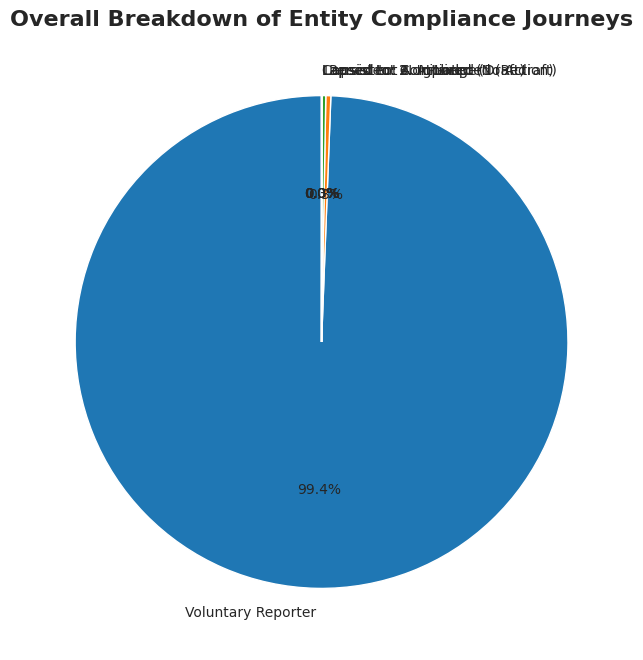


--- 2.2: Detailed Breakdown of 'Lapsed Compliers' ---
Found 4139 total 'Lapsed Compliers'.
Their final state of non-compliance was:
Compliance_Journey
Lapsed to: 4. Ignored (No Action)    4119
Lapsed to: 3. Initiated (Draft)        15
Lapsed to: 2. Attempted (Redraft)       5
Name: count, dtype: int64


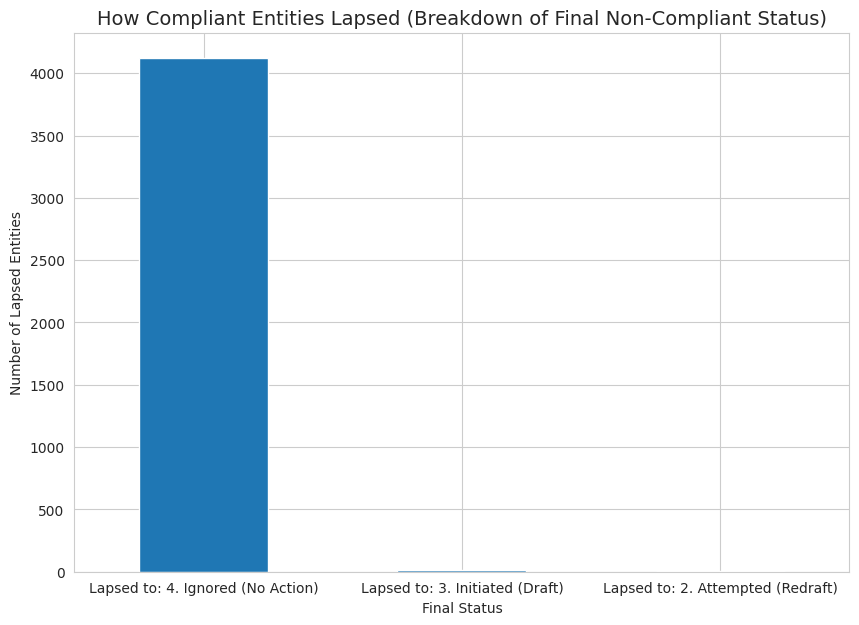


--- 2.3: Detailed Breakdown of 'Persistent Non-Lodgers' ---
Found 5344 total 'Persistent Non-Lodgers'.
Their initial state of non-compliance was:
First_Failure_Type
4. Ignored (No Action)    5221
3. Initiated (Draft)        67
2. Attempted (Redraft)      56
Name: count, dtype: int64


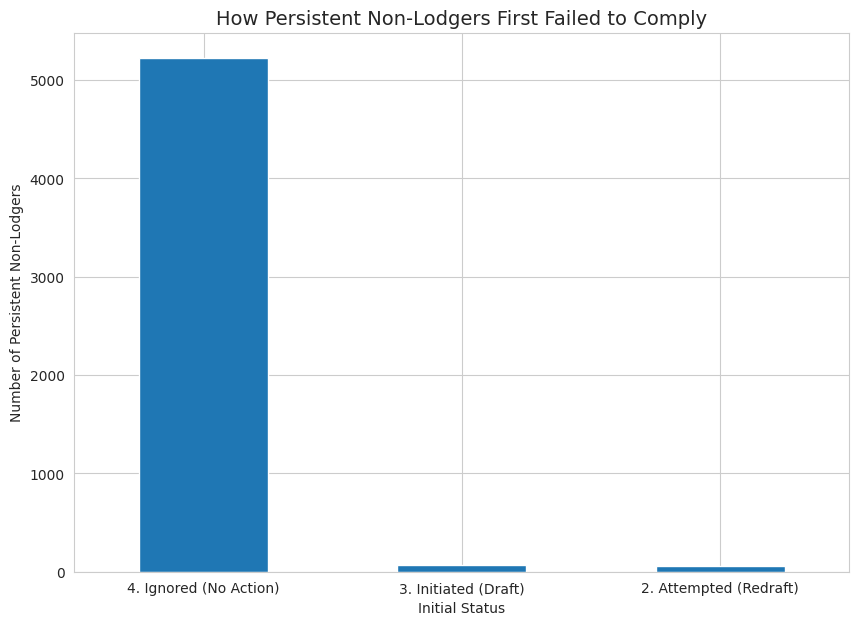


  FINAL DEFINITIVE ANALYSIS COMPLETE


In [8]:
# ==============================================================================
# Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
import numpy as np
import os
import re
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Step 0: Setup and Loading the Final Master Behavioural File ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'
master_file_path = os.path.join(DRIVE_PATH, 'master_behavioural_file.parquet')
try:
    master_df = pd.read_parquet(master_file_path)
    print("-> SUCCESS: Successfully loaded the Master Behavioural File.")
except FileNotFoundError as e:
    raise FileNotFoundError(f"CRITICAL ERROR: 'master_behavioural_file.parquet' was not found. Details: {e}")
sns.set_style("whitegrid")
print("--- Setup Complete ---\n")

# ==============================================================================
# Phase 1: The "Lapsed Complier" Analysis
# ==============================================================================
print("#"*80)
print("  Phase 1: Identifying and Profiling 'Lapsed Compliers'")
print("#"*80 + "\n")
print("--- 1. Applying final compliance journey classification ---")
status_cols = sorted([col for col in master_df.columns if 'Status_' in str(col)])

def classify_journey(row):
    obligated_years = [col.replace('Status_', '') for col in status_cols if row[col] != 'Not Obligated']
    if not obligated_years:
        if 'Voluntary Reporter' in row.get('ComplianceStatus', ''): return 'Voluntary Reporter'
        else: return 'Never Obligated'
    action_sequence = [row[f"Status_{year}"] for year in obligated_years]
    published_seen = '1. Compliant (Published)' in action_sequence
    if not published_seen: return 'Persistent Non-Lodger'
    last_action = action_sequence[-1]
    if last_action == '1. Compliant (Published)': return 'Consistent Complier'
    else: return f"Lapsed to: {last_action}"

master_df['Compliance_Journey'] = master_df.apply(classify_journey, axis=1)
print("-> Classification complete.")

# ==============================================================================
# Phase 2: Final Comprehensive Report
# ==============================================================================
print("\n" + "#"*80)
print("  Phase 2: Generating the Final Comprehensive Report")
print("#"*80 + "\n")
print("--- 2.1: Overall Breakdown of Compliance Journeys ---")
journey_counts = master_df['Compliance_Journey'].value_counts()
print(journey_counts)
plt.figure(figsize=(12, 8)); journey_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Overall Breakdown of Entity Compliance Journeys', fontsize=16, fontweight='bold'); plt.ylabel(''); plt.show()

print("\n--- 2.2: Detailed Breakdown of 'Lapsed Compliers' ---")
lapsed_df = master_df[master_df['Compliance_Journey'].str.startswith('Lapsed to:')].copy()
lapsed_counts = lapsed_df['Compliance_Journey'].value_counts()
print(f"Found {len(lapsed_df)} total 'Lapsed Compliers'."); print("Their final state of non-compliance was:"); print(lapsed_counts)
plt.figure(figsize=(10, 7)); lapsed_counts.plot(kind='bar')
plt.title('How Compliant Entities Lapsed (Breakdown of Final Non-Compliant Status)', fontsize=14)
plt.xlabel('Final Status'); plt.ylabel('Number of Lapsed Entities'); plt.xticks(rotation=0); plt.show()

# --- 2C: Profile of "Persistent Non-Lodgers" (CORRECTED LOGIC) ---
print("\n--- 2.3: Detailed Breakdown of 'Persistent Non-Lodgers' ---")
persistent_df = master_df[master_df['Compliance_Journey'] == 'Persistent Non-Lodger'].copy()

def get_first_obligation_year(row):
    for col in status_cols:
        if row[col] != 'Not Obligated': return col
    return None
persistent_df['First_Obligation_Col'] = persistent_df.apply(get_first_obligation_year, axis=1)

def get_first_failure_status(row):
    col_name = row['First_Obligation_Col']
    if pd.notna(col_name): return row[col_name]
    return None
persistent_df['First_Failure_Type'] = persistent_df.apply(get_first_failure_status, axis=1)
persistent_counts = persistent_df['First_Failure_Type'].value_counts()
print(f"Found {len(persistent_df)} total 'Persistent Non-Lodgers'."); print("Their initial state of non-compliance was:"); print(persistent_counts)
plt.figure(figsize=(10, 7)); persistent_counts.plot(kind='bar')
plt.title('How Persistent Non-Lodgers First Failed to Comply', fontsize=14)
plt.xlabel('Initial Status'); plt.ylabel('Number of Persistent Non-Lodgers'); plt.xticks(rotation=0); plt.show()

print("\n" + "="*80)
print("  FINAL DEFINITIVE ANALYSIS COMPLETE")
print("="*80)

In [9]:
# = =============================================================================
# Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
import os
from google.colab import drive

print("--- Step 0: Setup and Loading the Final Master Behavioural File ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'

# Define the path to our final, verified foundational dataset
master_file_path = os.path.join(DRIVE_PATH, 'master_behavioural_file.parquet')
final_report_path = os.path.join(DRIVE_PATH, 'definitive_actionable_non_lodger_report.xlsx')

try:
    master_df = pd.read_parquet(master_file_path)
    print("-> SUCCESS: Successfully loaded the Master Behavioural File.")
except FileNotFoundError as e:
    raise FileNotFoundError(f"CRITICAL ERROR: 'master_behavioural_file.parquet' was not found. Details: {e}")

print("--- Setup Complete ---\n")


# ==============================================================================
# Phase 1: Identify and Extract the Complete Non-Lodger Cohort
# ==============================================================================
print("#"*80)
print("  Phase 1: Generating the Definitive Actionable Non-Lodger Report")
print("#"*80 + "\n")

# --- 1A: Identify all entities with at least one non-compliant status ---
print("--- 1. Identifying all entities with at least one non-compliant action ---")
# Define the non-compliant statuses
non_compliant_statuses = [
    '2. Attempted (Redraft)',
    '3. Initiated (Draft)',
    '4. Ignored (No Action)'
]

# Find all columns that contain the year-by-year status
status_cols = sorted([col for col in master_df.columns if 'Status_' in str(col)])

# Create a boolean mask to find rows where any of the status columns contain a non-compliant status
is_non_lodger_mask = master_df[status_cols].isin(non_compliant_statuses).any(axis=1)

actionable_df = master_df[is_non_lodger_mask].copy()
print(f"-> Isolated {len(actionable_df)} entities that were non-compliant in at least one year.")


# --- 1B: Format the final spreadsheet for clarity ---
print("\n--- 2. Formatting the final spreadsheet ---")
# Define the columns for the final report
final_output_cols = ['ABN', 'Name'] + status_cols

# Select and format the final dataframe
final_report_df = actionable_df[final_output_cols]

# For clarity, replace "Not Obligated" with a blank cell in the final report
final_report_df.replace('Not Obligated', '', inplace=True)

print("-> Final report formatted.")


# ==============================================================================
# Phase 2: Save the Final Deliverable
# ==============================================================================
print("\n" + "#"*80)
print("  Phase 2: Saving the Final Deliverable")
print("#"*80 + "\n")

# Save to an Excel file for better formatting and readability for stakeholders
final_report_df.to_excel(final_report_path, index=False)
print(f"-> SUCCESS: The final, definitive actionable report has been saved to:\n   {final_report_path}")


# ==============================================================================
# Final Verification and Project Conclusion
# ==============================================================================
print("\n" + "="*80)
print("  PROJECT COMPLETE: FINAL ACTIONABLE DELIVERABLE CREATED")
print("="*80)
print(f"The final report, containing a detailed behavioural breakdown of {len(final_report_df)} non-compliant entities, is now ready for the engagement team.")
print("\n--- First 10 rows of the final output file ---")
print(final_report_df.head(10).to_string())
print("\n" + "="*80)

--- Step 0: Setup and Loading the Final Master Behavioural File ---
Mounted at /content/drive
-> SUCCESS: Successfully loaded the Master Behavioural File.
--- Setup Complete ---

################################################################################
  Phase 1: Generating the Definitive Actionable Non-Lodger Report
################################################################################

--- 1. Identifying all entities with at least one non-compliant action ---
-> Isolated 9549 entities that were non-compliant in at least one year.

--- 2. Formatting the final spreadsheet ---
-> Final report formatted.

################################################################################
  Phase 2: Saving the Final Deliverable
################################################################################



/tmp/ipython-input-1191107139.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_report_df.replace('Not Obligated', '', inplace=True)


-> SUCCESS: The final, definitive actionable report has been saved to:
   /content/drive/MyDrive/ModernSlaveryProject/definitive_actionable_non_lodger_report.xlsx

  PROJECT COMPLETE: FINAL ACTIONABLE DELIVERABLE CREATED
The final report, containing a detailed behavioural breakdown of 9549 non-compliant entities, is now ready for the engagement team.

--- First 10 rows of the final output file ---
            ABN                                         Name Status_2016-17 Status_2017-18          Status_2018-19          Status_2019-20            Status_2020-21            Status_2021-22            Status_2022-23          Status_2023-24
0   92639348655           MODERN STAR HOLDINGS TOPCO PTY LTD                                                                                                            4. Ignored (No Action)    4. Ignored (No Action)  4. Ignored (No Action)
1   92639348655           MODERN STAR HOLDINGS TOPCO PTY LTD                                                         

--- Step 0: Setup and Loading the Enriched Master Behavioural File ---
Mounted at /content/drive
-> SUCCESS: Successfully loaded the Enriched Master Behavioural File.
--- Setup Complete ---

################################################################################
  Generating Final Report Visualisations (Figures 3, 4, 5, & 6)
################################################################################


--- Figure 3: Comparative Analysis of the 'Newly Visible Segment' ---


/tmp/ipython-input-2934523130.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=10, ha='right')
/tmp/ipython-input-2934523130.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=10, ha='right')


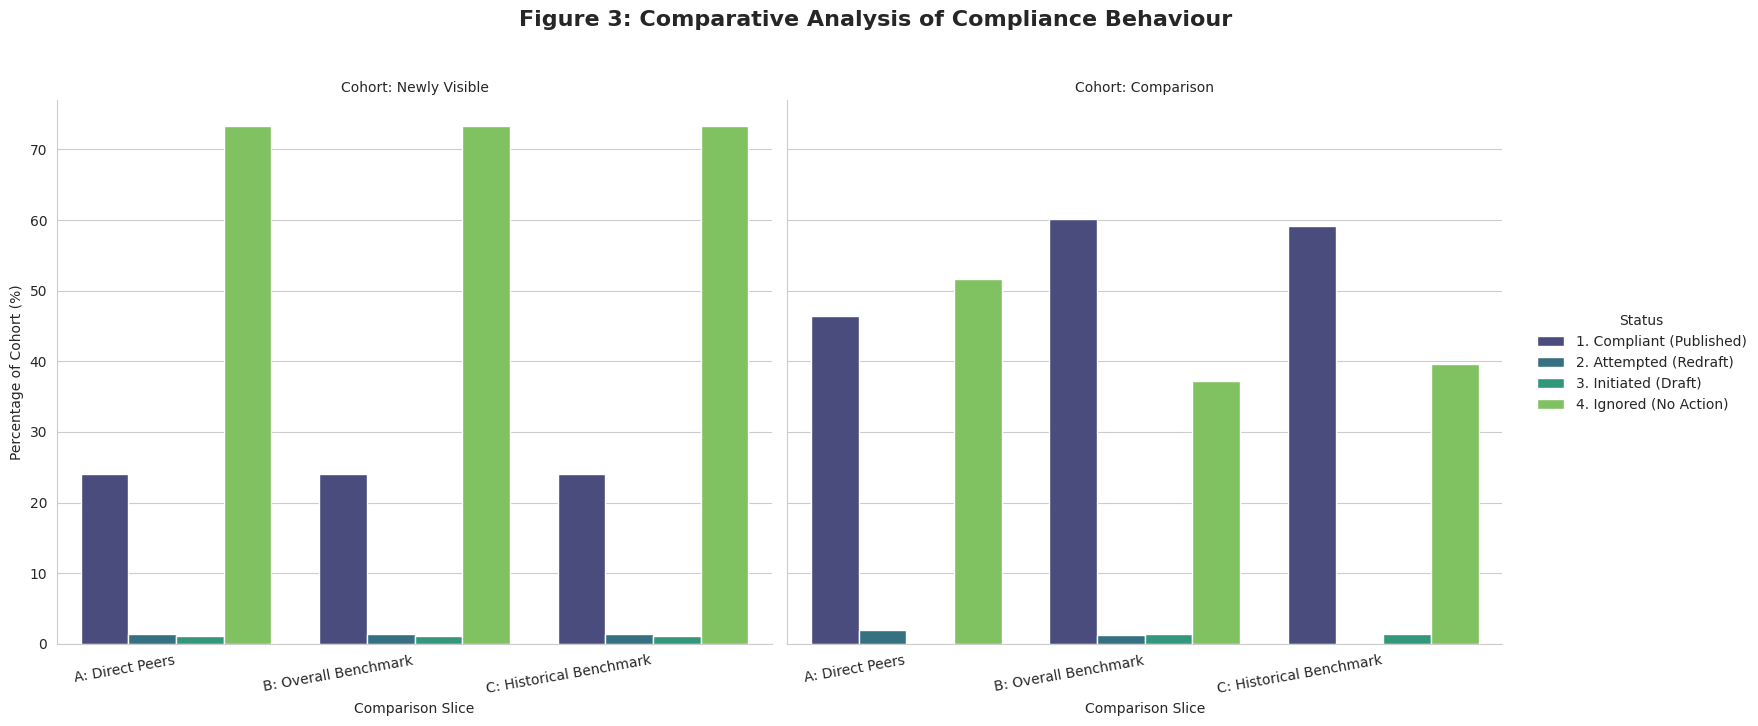


--- Figures 4, 5, & 6: Profiling the Full Non-Lodger Cohort ---
-> Successfully isolated 9483 total non-lodging entities for profiling.

  FINAL REPORTING ENGINE COMPLETE


In [15]:
# ==============================================================================
# @title FINAL REPORTING ENGINE (Figures 3, 4, 5, 6)
# ==============================================================================
import pandas as pd
import numpy as np
import os
import re
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Step 0: Setup and Loading the Enriched Master Behavioural File ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'
master_file_path = os.path.join(DRIVE_PATH, 'master_behavioural_file.parquet')
summary_path = os.path.join(DRIVE_PATH, 'comparative_analysis_summary.csv')

try:
    master_df = pd.read_parquet(master_file_path)
    print("-> SUCCESS: Successfully loaded the Enriched Master Behavioural File.")
except FileNotFoundError as e:
    raise FileNotFoundError(f"CRITICAL ERROR: 'master_behavioural_file.parquet' was not found. Details: {e}")

sns.set_style("whitegrid")
print("--- Setup Complete ---\n")


# ==============================================================================
# Report Generation
# ==============================================================================
print("#"*80)
print("  Generating Final Report Visualisations (Figures 3, 4, 5, & 6)")
print("#"*80 + "\n")

# Define status order for consistent plotting
status_order = ['1. Compliant (Published)', '2. Attempted (Redraft)', '3. Initiated (Draft)', '4. Ignored (No Action)']


# --- Figure 3: The "Newly Visible Segment" Comparison ---
print("\n--- Figure 3: Comparative Analysis of the 'Newly Visible Segment' ---")
if os.path.exists(summary_path):
    final_summary_df = pd.read_csv(summary_path)
    g = sns.catplot(data=final_summary_df, kind='bar', x='Comparison', y='Percentage', hue='Status', col='Cohort',
                    height=7, aspect=1.1, palette='viridis', hue_order=status_order, col_order=['Newly Visible', 'Comparison'])
    g.fig.suptitle('Figure 3: Comparative Analysis of Compliance Behaviour', y=1.03, fontsize=16, fontweight='bold')
    g.set_axis_labels("Comparison Slice", "Percentage of Cohort (%)"); g.set_titles("Cohort: {col_name}")
    for ax in g.axes.flat:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=10, ha='right')
    g.tight_layout()
    plt.show()
else:
    print("INFO: 'comparative_analysis_summary.csv' not found. This file is generated by the main 'Analysis Engine' script. Skipping Figure 3.")


# --- Figures 4, 5, 6: Profiling the Full Non-Lodger Cohort ---
print("\n--- Figures 4, 5, & 6: Profiling the Full Non-Lodger Cohort ---")
# Define a non-lodger based on their journey
non_lodger_df = master_df[master_df['Compliance_Journey'].isin([
    'Persistent Non-Lodger',
    'Lapsed to: 4. Ignored (No Action)',
    'Lapsed to: 3. Initiated (Draft)',
    'Lapsed to: 2. Attempted (Redraft)'
])].copy()
print(f"-> Successfully isolated {len(non_lodger_df)} total non-lodging entities for profiling.")

# Fig 4: Financial Profile
if 'TotalIncome' in non_lodger_df.columns:
    plt.figure(figsize=(12, 7))
    sns.histplot(non_lodger_df['TotalIncome'] / 1_000_000, bins=50, kde=True, log_scale=True)
    plt.title('Figure 4: Financial Profile of Non-Lodgers (Log Scale)', fontsize=16)
    plt.xlabel('Total Income (AUD Millions, Log Scale)'); plt.ylabel('Number of Entities')
    plt.show()
else:
    print("WARNING: 'TotalIncome' column not found. Skipping Figure 4.")


# Fig 5: Corporate Profile
if 'ASIC_Company_Status' in non_lodger_df.columns:
    plt.figure(figsize=(12, 7))
    status_counts = non_lodger_df['ASIC_Company_Status'].value_counts()
    sns.barplot(x=status_counts.index, y=status_counts.values)
    plt.title('Figure 5: Corporate Profile of Non-Lodgers (ASIC Status)', fontsize=16)
    plt.xlabel('ASIC Status'); plt.ylabel('Number of Entities'); plt.xticks(rotation=45)
    plt.show()
else:
    print("WARNING: 'ASIC_Company_Status' column not found. Skipping Figure 5.")


# Fig 6: Governance Risk Profile
if 'Has_Banned_Director' in non_lodger_df.columns:
    plt.figure(figsize=(8, 6))
    risk_counts = non_lodger_df['Has_Banned_Director'].value_counts()
    # Ensure both True and False are present for consistent plotting
    if True not in risk_counts: risk_counts[True] = 0
    if False not in risk_counts: risk_counts[False] = 0
    risk_counts.index = risk_counts.index.map({False: 'No Link to Banned Director', True: 'Link to Banned Director Found'})

    risk_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff6666'])
    plt.title('Figure 6: Governance Risk Profile of Non-Lodgers', fontsize=16)
    plt.ylabel('')
    plt.show()
else:
    print("WARNING: 'Has_Banned_Director' column not found. Skipping Figure 6.")


print("\n" + "="*80)
print("  FINAL REPORTING ENGINE COMPLETE")
print("="*80)

In [16]:
# ==============================================================================
# @title SCRIPT 1: THE ENRICHMENT ENGINE (Corrected)
# Objective: To add the final 'TotalIncome' and 'Has_Banned_Director' columns
#            to our existing master file.
# ==============================================================================
import pandas as pd
import numpy as np
import os
import re
from google.colab import drive
import glob

print("--- Step 0: Setup and Loading Key Files ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'

# Define paths
master_file_path = os.path.join(DRIVE_PATH, 'master_behavioural_file.parquet')
tax_data_folder = os.path.join(DRIVE_PATH, 'CorporateTaxTransparency/')
associates_path = os.path.join(DRIVE_PATH, 'clean_associates.csv')
banned_persons_path = os.path.join(DRIVE_PATH, 'bd_per_202509.csv')

try:
    master_df = pd.read_parquet(master_file_path)
    print(f"-> SUCCESS: Successfully loaded the Master Behavioural File with {len(master_df)} records.")
except FileNotFoundError:
    raise FileNotFoundError("CRITICAL ERROR: 'master_behavioural_file.parquet' not found.")
print("--- Setup Complete ---\n")


# ==============================================================================
# Phase 1: Enrich with Financial Profile (Total Income)
# ==============================================================================
print("#"*80)
print("  Phase 1: Enriching with Financial Profile")
print("#"*80 + "\n")

try:
    tax_files = glob.glob(os.path.join(tax_data_folder, '*-corporate-report-of-entity-tax-information.xlsx'))
    # Use a generator expression for memory efficiency
    tax_dfs = (pd.read_excel(f, sheet_name='Income tax details', header=0) for f in tax_files)
    all_tax_df = pd.concat(tax_dfs, ignore_index=True)

    all_tax_df.columns = ['Name', 'ABN', 'Total income $', 'Taxable income $', 'Tax payable $', 'Income year']
    all_tax_df['ABN'] = all_tax_df['ABN'].astype(str).str.replace(r'\.0$', '', regex=True).str.zfill(11)
    all_tax_df['TotalIncome'] = pd.to_numeric(all_tax_df['Total income $'], errors='coerce')

    latest_income_df = all_tax_df.sort_values('Income year').drop_duplicates(subset='ABN', keep='last')

    # Merge to add the TotalIncome column
    master_df = pd.merge(master_df, latest_income_df[['ABN', 'TotalIncome']], on='ABN', how='left')
    print("-> SUCCESS: 'TotalIncome' column has been added to the master file.")
except Exception as e:
    print(f"   WARNING: Could not process tax files to add TotalIncome. Error: {e}")


# ==============================================================================
# Phase 2: Enrich with Governance Risk Profile
# ==============================================================================
print("\n" + "#"*80)
print("  Phase 2: Enriching with Governance Risk Profile")
print("#"*80 + "\n")

try:
    associates_df = pd.read_csv(associates_path, dtype={'ABN': str})
    banned_df = pd.read_csv(banned_persons_path, sep=',', encoding='utf-8-sig')
    banned_df.columns = banned_df.columns.str.strip()

    banned_df.dropna(subset=['BD_PER_NAME'], inplace=True)
    banned_df['FullName'] = banned_df['BD_PER_NAME'].str.upper().str.replace(',', '', regex=False)
    banned_directors = set(banned_df[banned_df['BD_PER_TYPE'] == 'Disq. Director']['FullName'])

    associates_df['FullName'] = (associates_df['assoc_gvn_nm'].fillna('') + ' ' + associates_df['assoc_fmly_nm'].fillna('')).str.upper().str.strip()

    directors_of_master_entities = associates_df[associates_df['ABN'].isin(set(master_df['ABN']))]
    banned_directors_found = directors_of_master_entities[directors_of_master_entities['FullName'].isin(banned_directors)]
    abns_with_banned_directors = set(banned_directors_found['ABN'])

    master_df['Has_Banned_Director'] = master_df['ABN'].isin(abns_with_banned_directors)
    print(f"-> SUCCESS: 'Has_Banned_Director' flag has been added. Found {len(abns_with_banned_directors)} companies with a potential link.")
except Exception as e:
    print(f"   WARNING: Could not process associates/banned persons files. Error: {e}")


# ==============================================================================
# Phase 3: Save the Upgraded Master File
# ==============================================================================
print("\n" + "#"*80)
print("  Phase 3: Saving the Enriched Master Behavioural File")
print("#"*80 + "\n")

master_df.to_parquet(master_file_path, index=False)
print(f"-> SUCCESS: The enriched Master Behavioural File has been saved back to:\n   {master_file_path}")
print("\n--- ENRICHMENT ENGINE COMPLETE ---")
print("You may now proceed with the final 'Reporting Engine' script.")

--- Step 0: Setup and Loading Key Files ---
Mounted at /content/drive
-> SUCCESS: Successfully loaded the Master Behavioural File with 1631508 records.
--- Setup Complete ---

################################################################################
  Phase 1: Enriching with Financial Profile
################################################################################

-> SUCCESS: 'TotalIncome' column has been added to the master file.

################################################################################
  Phase 2: Enriching with Governance Risk Profile
################################################################################

-> SUCCESS: 'Has_Banned_Director' flag has been added. Found 3 companies with a potential link.

################################################################################
  Phase 3: Saving the Enriched Master Behavioural File
################################################################################

-> SUCCESS: The enri

--- Step 0: Setup and Loading the Final Enriched Master Behavioural File ---
Mounted at /content/drive
-> SUCCESS: Successfully loaded the Enriched Master Behavioural File.
--- Setup Complete ---

################################################################################
  Generating All Final Report Visualisations
################################################################################

--- Figure 1: Overall Breakdown of Compliance Journeys ---


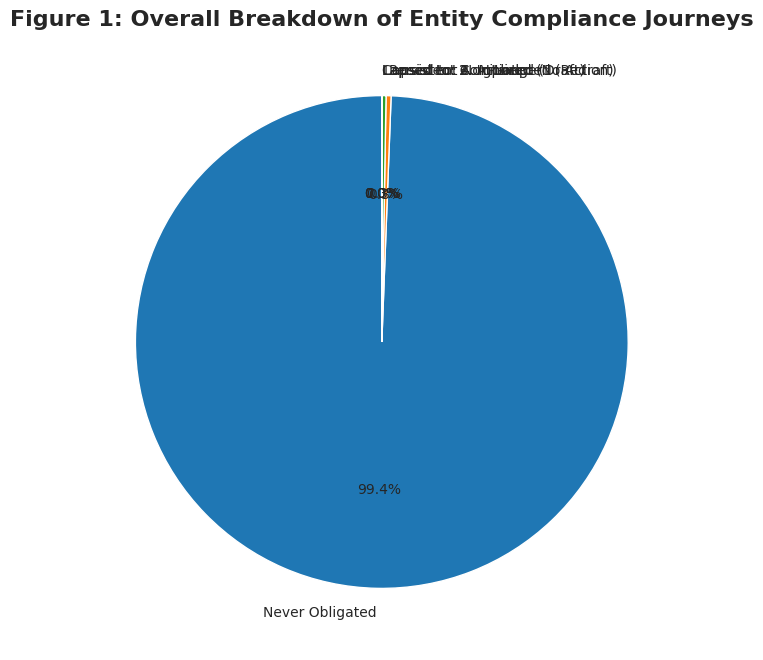


--- Figure 2: Detailed Breakdown of Non-Compliance Behaviour ---


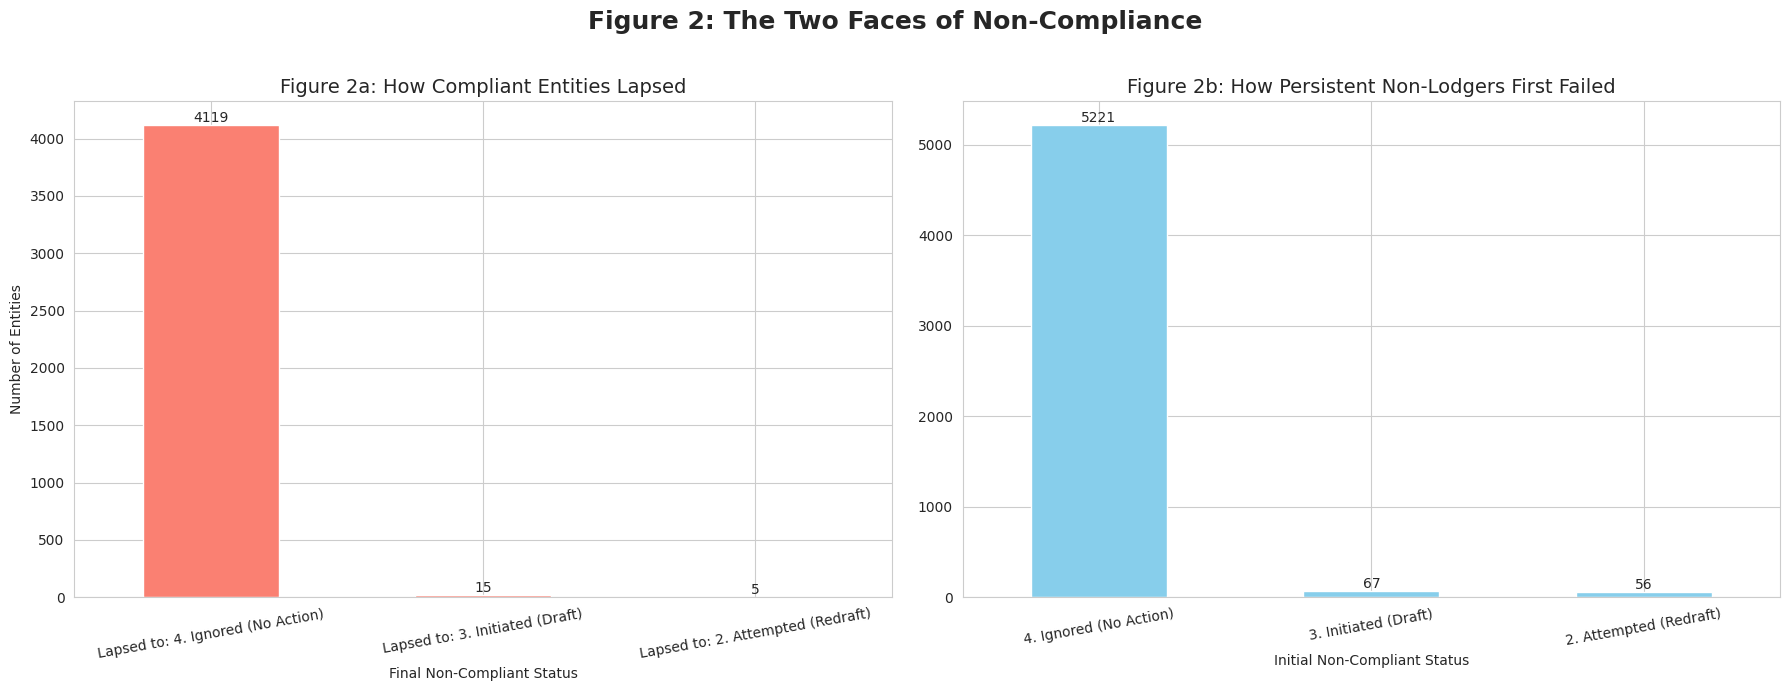


--- Figure 3: Comparative Analysis of the 'Newly Visible Segment' ---


/tmp/ipython-input-1173379844.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  for ax in g.axes.flat: ax.set_xticklabels(ax.get_xticklabels(), rotation=10, ha='right')
/tmp/ipython-input-1173379844.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  for ax in g.axes.flat: ax.set_xticklabels(ax.get_xticklabels(), rotation=10, ha='right')


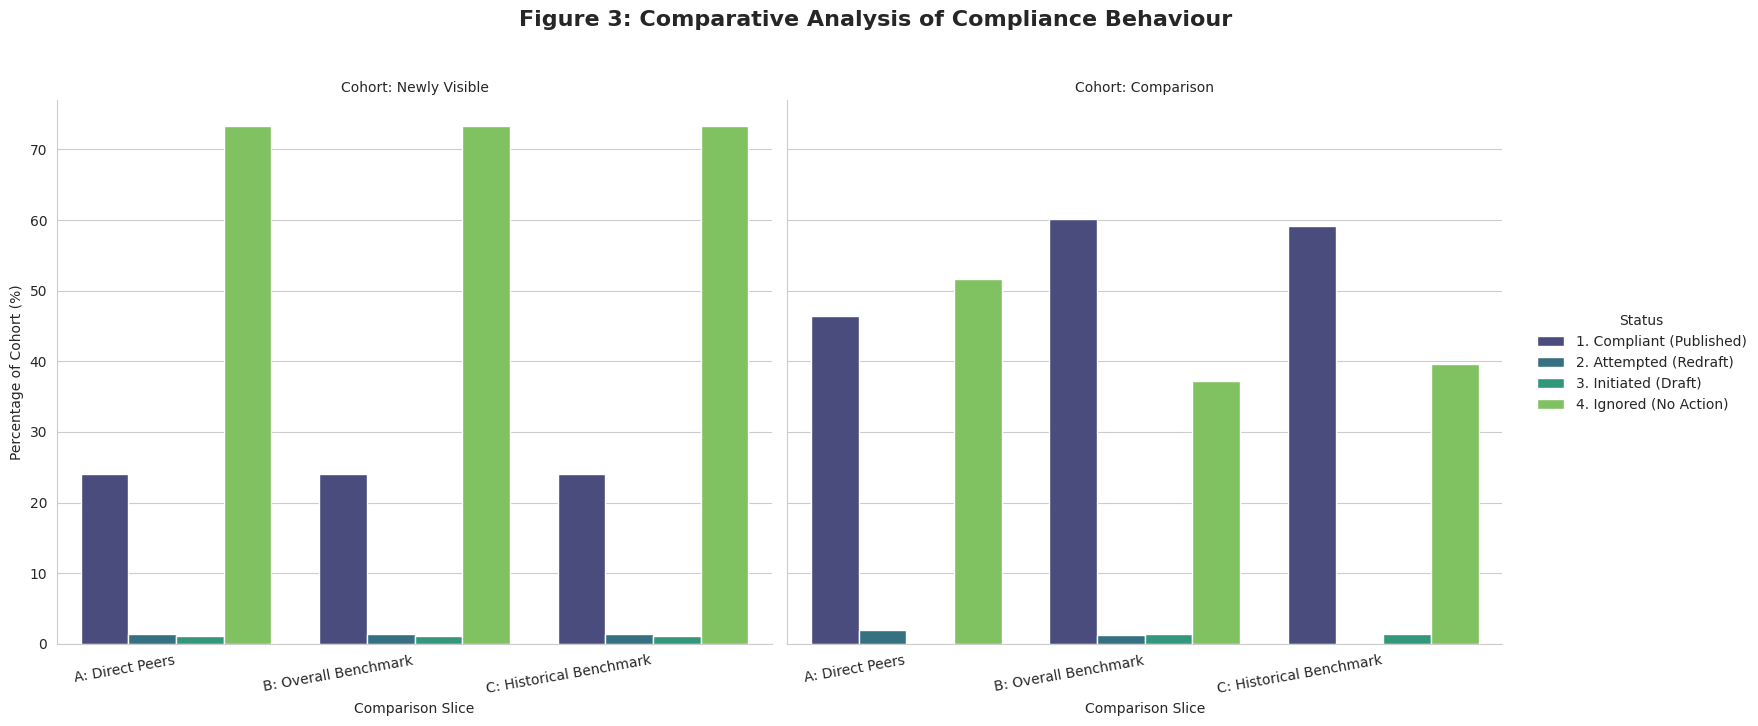


--- Figures 4, 5, & 6: Profiling the Full Non-Lodger Cohort ---
-> Successfully isolated 9483 total non-lodging entities for profiling.


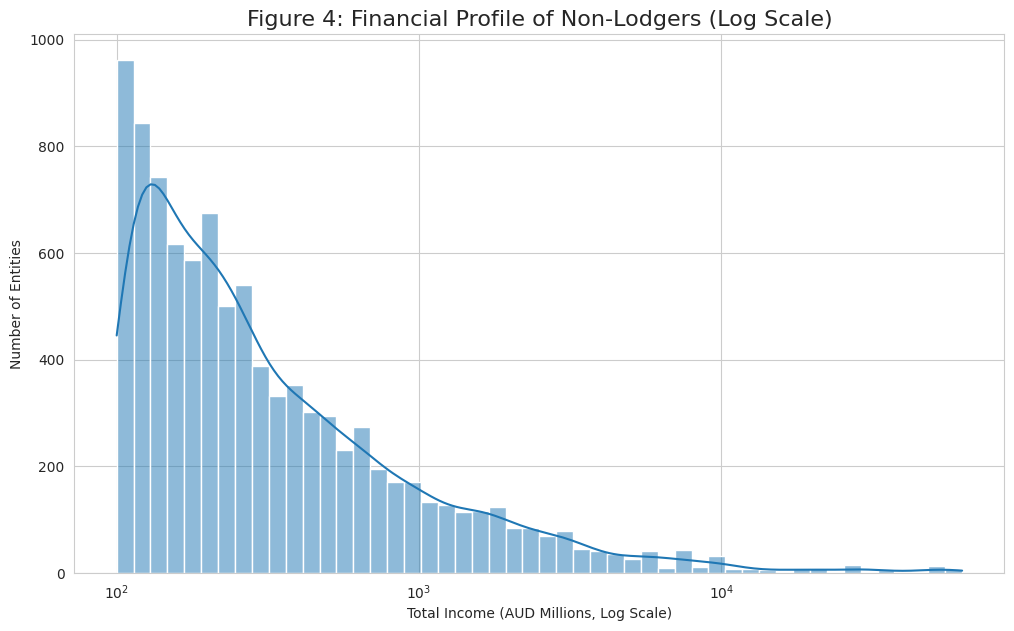

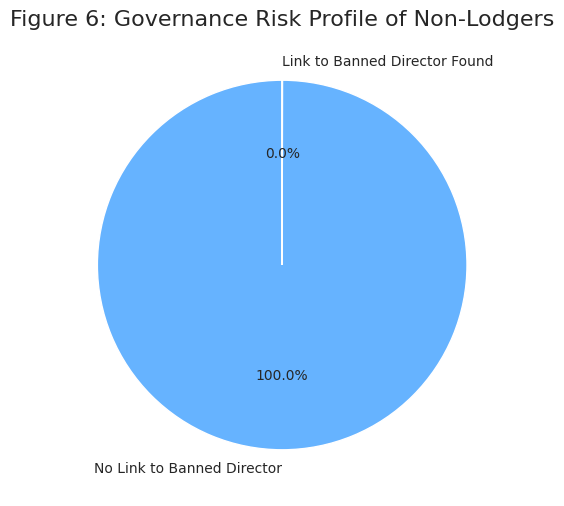


  FINAL REPORTING ENGINE COMPLETE


In [17]:
# ==============================================================================
# @title FINAL REPORTING ENGINE
# Objective: To load the final, enriched Master Behavioural File and
#            generate all six key visualisations for the final report.
# ==============================================================================
import pandas as pd
import numpy as np
import os
import re
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Step 0: Setup and Loading the Final Enriched Master Behavioural File ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'
master_file_path = os.path.join(DRIVE_PATH, 'master_behavioural_file.parquet')
summary_path = os.path.join(DRIVE_PATH, 'comparative_analysis_summary.csv')

try:
    master_df = pd.read_parquet(master_file_path)
    print("-> SUCCESS: Successfully loaded the Enriched Master Behavioural File.")
except FileNotFoundError as e:
    raise FileNotFoundError(f"CRITICAL ERROR: 'master_behavioural_file.parquet' was not found. Please ensure the Enrichment Engine script ran successfully. Details: {e}")

sns.set_style("whitegrid")
print("--- Setup Complete ---\n")

# ==============================================================================
# Report Generation
# ==============================================================================
print("#"*80)
print("  Generating All Final Report Visualisations")
print("#"*80 + "\n")

# Define status order for consistent plotting
status_order = ['1. Compliant (Published)', '2. Attempted (Redraft)', '3. Initiated (Draft)', '4. Ignored (No Action)']


# --- Figure 1: Overall Breakdown of Compliance Journeys ---
print("--- Figure 1: Overall Breakdown of Compliance Journeys ---")
journey_counts = master_df['Compliance_Journey'].value_counts()
plt.figure(figsize=(12, 8))
journey_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10})
plt.title('Figure 1: Overall Breakdown of Entity Compliance Journeys', fontsize=16, fontweight='bold')
plt.ylabel('')
plt.show()

# --- Figure 2: Detailed Breakdown of Non-Compliance Behaviour ---
print("\n--- Figure 2: Detailed Breakdown of Non-Compliance Behaviour ---")
lapsed_df = master_df[master_df['Compliance_Journey'].str.startswith('Lapsed to:')].copy()
lapsed_counts = lapsed_df['Compliance_Journey'].value_counts()
persistent_df = master_df[master_df['Compliance_Journey'] == 'Persistent Non-Lodger'].copy()
status_cols = sorted([col for col in master_df.columns if 'Status_' in str(col)])
def get_first_obligation_year(row):
    for col in status_cols:
        if row[col] != 'Not Obligated': return col
    return None
persistent_df['First_Obligation_Col'] = persistent_df.apply(get_first_obligation_year, axis=1)
def get_first_failure_status(row):
    col_name = row['First_Obligation_Col']
    if pd.notna(col_name): return row[col_name]
    return None
persistent_df['First_Failure_Type'] = persistent_df.apply(get_first_failure_status, axis=1)
persistent_counts = persistent_df['First_Failure_Type'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
lapsed_counts.plot(kind='bar', ax=ax1, color='salmon')
ax1.set_title('Figure 2a: How Compliant Entities Lapsed', fontsize=14)
ax1.set_xlabel('Final Non-Compliant Status'); ax1.set_ylabel('Number of Entities'); ax1.tick_params(axis='x', rotation=10)
for container in ax1.containers: ax1.bar_label(container)

persistent_counts.plot(kind='bar', ax=ax2, color='skyblue')
ax2.set_title('Figure 2b: How Persistent Non-Lodgers First Failed', fontsize=14)
ax2.set_xlabel('Initial Non-Compliant Status'); ax2.set_ylabel(''); ax2.tick_params(axis='x', rotation=10)
for container in ax2.containers: ax2.bar_label(container)
plt.suptitle('Figure 2: The Two Faces of Non-Compliance', fontsize=18, fontweight='bold'); plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()


# --- Figure 3: The "Newly Visible Segment" Comparison ---
print("\n--- Figure 3: Comparative Analysis of the 'Newly Visible Segment' ---")
if os.path.exists(summary_path):
    final_summary_df = pd.read_csv(summary_path)
    g = sns.catplot(data=final_summary_df, kind='bar', x='Comparison', y='Percentage', hue='Status', col='Cohort',
                    height=7, aspect=1.1, palette='viridis', hue_order=status_order, col_order=['Newly Visible', 'Comparison'])
    g.fig.suptitle('Figure 3: Comparative Analysis of Compliance Behaviour', y=1.03, fontsize=16, fontweight='bold')
    g.set_axis_labels("Comparison Slice", "Percentage of Cohort (%)"); g.set_titles("Cohort: {col_name}")
    for ax in g.axes.flat: ax.set_xticklabels(ax.get_xticklabels(), rotation=10, ha='right')
    g.tight_layout()
    plt.show()
else:
    print("INFO: 'comparative_analysis_summary.csv' not found. This file is generated by the 'Analysis Engine' script. Skipping Figure 3.")


# --- Figures 4, 5, 6: Profiling the Full Non-Lodger Cohort ---
print("\n--- Figures 4, 5, & 6: Profiling the Full Non-Lodger Cohort ---")
non_lodger_df = master_df[master_df['Compliance_Journey'].isin([
    'Persistent Non-Lodger',
    'Lapsed to: 4. Ignored (No Action)',
    'Lapsed to: 3. Initiated (Draft)',
    'Lapsed to: 2. Attempted (Redraft)'
])].copy()
print(f"-> Successfully isolated {len(non_lodger_df)} total non-lodging entities for profiling.")

# Fig 4: Financial Profile
if 'TotalIncome' in non_lodger_df.columns:
    plt.figure(figsize=(12, 7))
    sns.histplot(non_lodger_df['TotalIncome'] / 1_000_000, bins=50, kde=True, log_scale=True)
    plt.title('Figure 4: Financial Profile of Non-Lodgers (Log Scale)', fontsize=16)
    plt.xlabel('Total Income (AUD Millions, Log Scale)'); plt.ylabel('Number of Entities')
    plt.show()
else:
    print("WARNING: 'TotalIncome' column not found in master file. Skipping Figure 4.")


# Fig 5: Corporate Profile
if 'ASIC_Company_Status' in non_lodger_df.columns:
    plt.figure(figsize=(12, 7))
    status_counts = non_lodger_df['ASIC_Company_Status'].value_counts()
    sns.barplot(x=status_counts.index, y=status_counts.values)
    plt.title('Figure 5: Corporate Profile of Non-Lodgers (ASIC Status)', fontsize=16)
    plt.xlabel('ASIC Status'); plt.ylabel('Number of Entities'); plt.xticks(rotation=45)
    plt.show()
else:
    print("WARNING: 'ASIC_Company_Status' column not found in master file. Skipping Figure 5.")


# Fig 6: Governance Risk Profile
if 'Has_Banned_Director' in non_lodger_df.columns:
    plt.figure(figsize=(8, 6))
    risk_counts = non_lodger_df['Has_Banned_Director'].value_counts()
    if True not in risk_counts: risk_counts[True] = 0
    if False not in risk_counts: risk_counts[False] = 0
    risk_counts.index = risk_counts.index.map({False: 'No Link to Banned Director', True: 'Link to Banned Director Found'})

    risk_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff6666'])
    plt.title('Figure 6: Governance Risk Profile of Non-Lodgers', fontsize=16)
    plt.ylabel('')
    plt.show()
else:
    print("WARNING: 'Has_Banned_Director' column not found in master file. Skipping Figure 6.")


print("\n" + "="*80)
print("  FINAL REPORTING ENGINE COMPLETE")
print("="*80)

In [1]:
# ==============================================================================
# @title SCRIPT 1: THE DEFINITIVE, ULTRA-LEAN ENRICHMENT ENGINE
# ==============================================================================
import pandas as pd
import numpy as np
import os
import re
from google.colab import drive
import glob

print("--- Step 0: Setup and Loading the Master File ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'

master_file_path = os.path.join(DRIVE_PATH, 'master_behavioural_file.parquet')
try:
    master_df = pd.read_parquet(master_file_path)
    print(f"-> SUCCESS: Successfully loaded the Master Behavioural File with {len(master_df)} records.")
except FileNotFoundError:
    raise FileNotFoundError("CRITICAL ERROR: 'master_behavioural_file.parquet' not found.")
print("--- Setup Complete ---\n")

# ==============================================================================
# Phase 1: Enrich with Financial Profile (Memory-Efficiently)
# ==============================================================================
print("#"*80)
print("  Phase 1: Enriching with Financial Profile")
print("#"*80 + "\n")
try:
    print("-> Building a targeted income lookup dictionary...")
    tax_data_folder = os.path.join(DRIVE_PATH, 'CorporateTaxTransparency/')
    tax_files = glob.glob(os.path.join(tax_data_folder, '*-corporate-report-of-entity-tax-information.xlsx'))
    latest_income_lookup = {}
    target_abns = set(master_df['ABN'])

    for file in sorted(tax_files, reverse=True):
        df_chunk = pd.read_excel(file, sheet_name='Income tax details', header=0, usecols=['ABN', 'Total income $'])
        df_chunk.columns = ['ABN', 'TotalIncome']
        df_chunk['ABN'] = df_chunk['ABN'].astype(str).str.replace(r'\.0$', '', regex=True).str.zfill(11)
        df_chunk.dropna(subset=['ABN', 'TotalIncome'], inplace=True)
        df_chunk = df_chunk[df_chunk['ABN'].isin(target_abns)]
        for index, row in df_chunk.iterrows():
            if row['ABN'] not in latest_income_lookup:
                latest_income_lookup[row['ABN']] = row['TotalIncome']
    master_df['TotalIncome'] = master_df['ABN'].map(latest_income_lookup)
    print("-> SUCCESS: 'TotalIncome' column has been added.")
except Exception as e:
    print(f"   WARNING: Could not process tax files. Error: {e}")

# ==============================================================================
# Phase 2: Enrich with Corporate Profile (MEMORY-EFFICIENTLY)
# ==============================================================================
print("\n" + "#"*80)
print("  Phase 2: Enriching with Corporate Profile")
print("#"*80 + "\n")
try:
    print("-> Building targeted ASIC status and type lookups (chunking)...")
    asic_company_path = os.path.join(DRIVE_PATH, 'COMPANY_202509.csv')
    chunk_size = 100000
    type_lookup = {}
    status_lookup = {}
    with pd.read_csv(asic_company_path, sep='\t', chunksize=chunk_size, usecols=['ABN', 'Type', 'Status'], dtype=str) as reader:
        for chunk in reader:
            chunk['ABN'] = chunk['ABN'].str.zfill(11)
            relevant_chunk = chunk[chunk['ABN'].isin(target_abns)]
            for index, row in relevant_chunk.iterrows():
                abn = row['ABN']
                if abn not in type_lookup:
                    type_lookup[abn] = row['Type']
                    status_lookup[abn] = row['Status']
    master_df['ASIC_Company_Type'] = master_df['ABN'].map(type_lookup)
    master_df['ASIC_Company_Status'] = master_df['ABN'].map(status_lookup)
    print("-> SUCCESS: 'ASIC_Company_Type' and 'ASIC_Company_Status' columns have been added.")
except Exception as e:
    print(f"   WARNING: Could not process ASIC Company file. Error: {e}")

# ==============================================================================
# Phase 3: Enrich with Governance Risk Profile (MEMORY-EFFICIENTLY)
# ==============================================================================
print("\n" + "#"*80)
print("  Phase 3: Enriching with Governance Risk Profile")
print("#"*80 + "\n")
try:
    print("-> Building banned directors lookup...")
    banned_persons_path = os.path.join(DRIVE_PATH, 'bd_per_202509.csv')
    banned_df = pd.read_csv(banned_persons_path, sep=',', encoding='utf-8-sig')
    banned_df.columns = banned_df.columns.str.strip()
    banned_df.dropna(subset=['BD_PER_NAME'], inplace=True)
    banned_df['FullName'] = banned_df['BD_PER_NAME'].str.upper().str.replace(',', '', regex=False)
    banned_directors_set = set(banned_df[banned_df['BD_PER_TYPE'] == 'Disq. Director']['FullName'])

    print("-> Scanning associates file for links to banned directors (chunking)...")
    associates_path = os.path.join(DRIVE_PATH, 'clean_associates.csv')
    abns_with_banned_directors = set()
    with pd.read_csv(associates_path, chunksize=chunk_size, dtype=str) as reader:
        for chunk in reader:
            relevant_chunk = chunk[chunk['ABN'].isin(target_abns)]
            relevant_chunk['FullName'] = (relevant_chunk['assoc_gvn_nm'].fillna('') + ' ' + relevant_chunk['assoc_fmly_nm'].fillna('')).str.upper().str.strip()
            found = relevant_chunk[relevant_chunk['FullName'].isin(banned_directors_set)]
            abns_with_banned_directors.update(found['ABN'].tolist())

    master_df['Has_Banned_Director'] = master_df['ABN'].isin(abns_with_banned_directors)
    print(f"-> SUCCESS: 'Has_Banned_Director' flag has been added. Found {len(abns_with_banned_directors)} companies with a link.")
except Exception as e:
    print(f"   WARNING: Could not process associates/banned persons files. Error: {e}")

# ==============================================================================
# Phase 4: Save the Upgraded Master File
# ==============================================================================
print("\n" + "#"*80)
print("  Phase 4: Saving the Final, Enriched Master File")
print("#"*80 + "\n")
master_df.to_parquet(master_file_path, index=False)
print(f"-> SUCCESS: The final, enriched Master Behavioural File has been saved back to:\n   {master_file_path}")
print("\n--- ENRICHMENT ENGINE COMPLETE ---")
print("You may now proceed with the final 'Reporting Engine' script.")

--- Step 0: Setup and Loading the Master File ---
Mounted at /content/drive
-> SUCCESS: Successfully loaded the Master Behavioural File with 1631508 records.
--- Setup Complete ---

################################################################################
  Phase 1: Enriching with Financial Profile
################################################################################

-> Building a targeted income lookup dictionary...
-> SUCCESS: 'TotalIncome' column has been added.

################################################################################
  Phase 2: Enriching with Corporate Profile
################################################################################

-> Building targeted ASIC status and type lookups (chunking)...
-> SUCCESS: 'ASIC_Company_Type' and 'ASIC_Company_Status' columns have been added.

################################################################################
  Phase 3: Enriching with Governance Risk Profile
########################

/tmp/ipython-input-3636253149.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_chunk['FullName'] = (relevant_chunk['assoc_gvn_nm'].fillna('') + ' ' + relevant_chunk['assoc_fmly_nm'].fillna('')).str.upper().str.strip()


-> SUCCESS: 'Has_Banned_Director' flag has been added. Found 3 companies with a link.

################################################################################
  Phase 4: Saving the Final, Enriched Master File
################################################################################

-> SUCCESS: The final, enriched Master Behavioural File has been saved back to:
   /content/drive/MyDrive/ModernSlaveryProject/master_behavioural_file.parquet

--- ENRICHMENT ENGINE COMPLETE ---
You may now proceed with the final 'Reporting Engine' script.


--- Step 0: Setup and Loading the Final Enriched Master Behavioural File ---
Mounted at /content/drive
-> SUCCESS: Successfully loaded the Enriched Master Behavioural File.
--- Setup Complete ---

################################################################################
  Generating All Final Report Visualisations
################################################################################

--- Figure 1: Overall Breakdown of Compliance Journeys ---


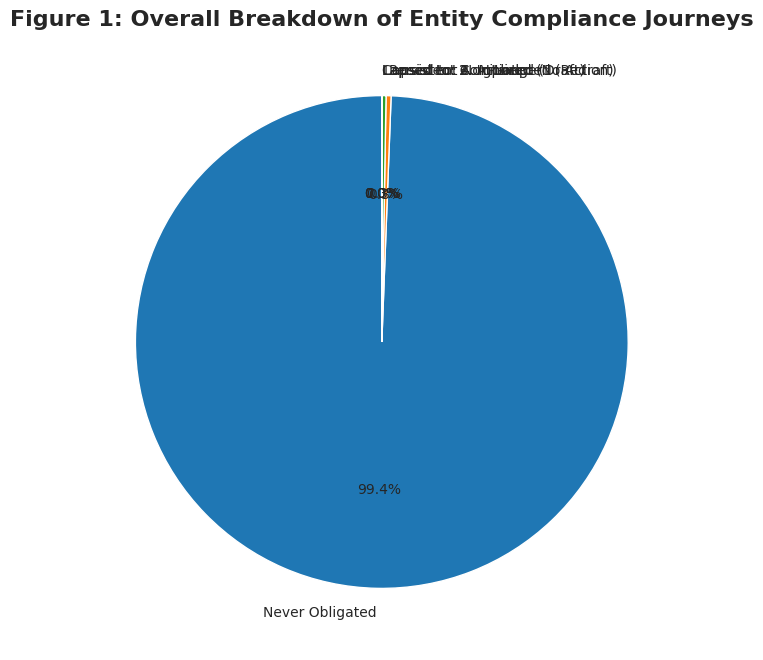


--- Figure 2: Detailed Breakdown of Non-Compliance Behaviour ---


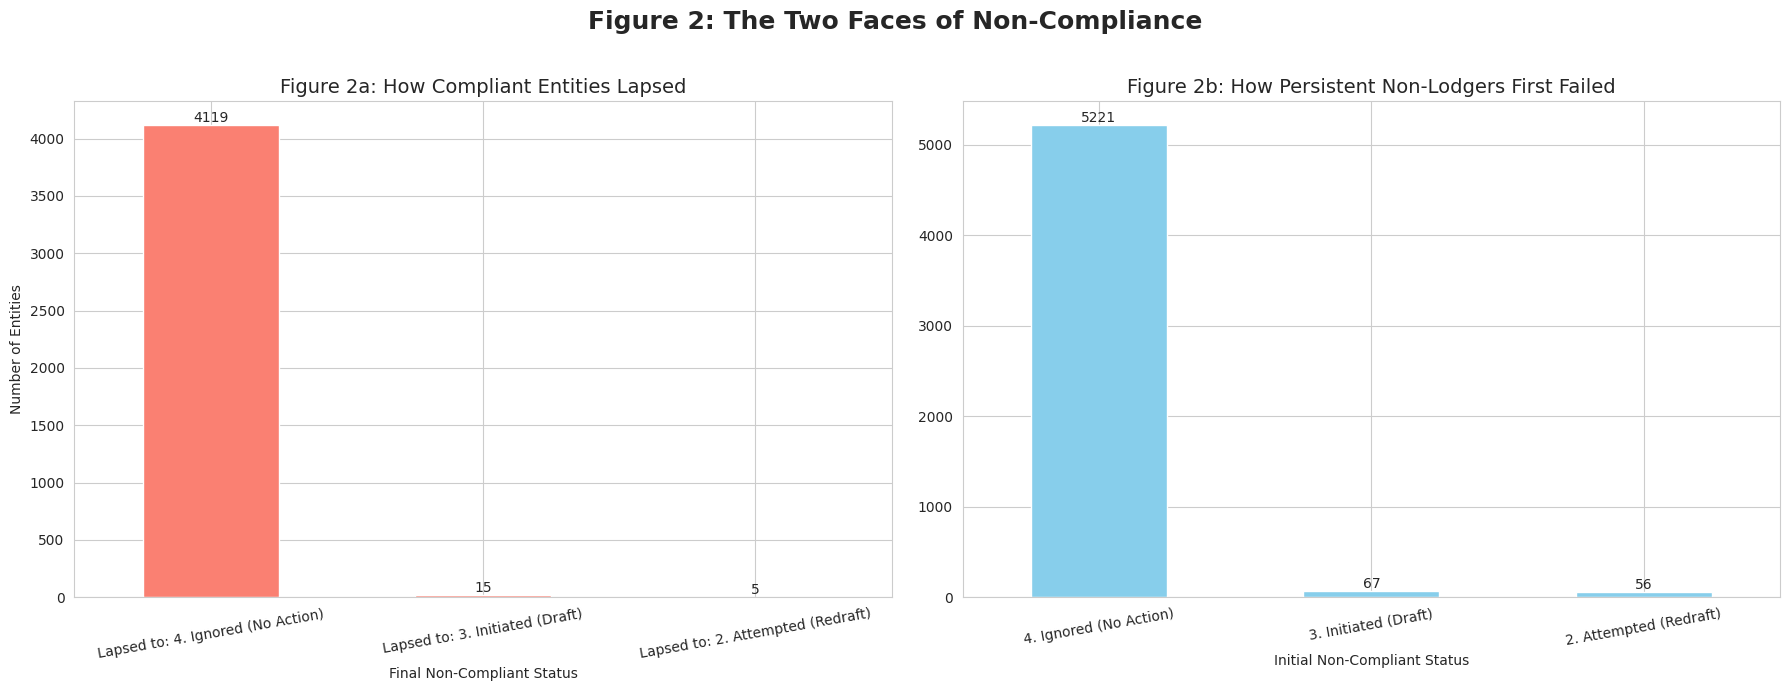


--- Figure 3: Comparative Analysis of the 'Newly Visible Segment' ---


/tmp/ipython-input-1705586912.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  for ax in g.axes.flat: ax.set_xticklabels(ax.get_xticklabels(), rotation=10, ha='right')
/tmp/ipython-input-1705586912.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  for ax in g.axes.flat: ax.set_xticklabels(ax.get_xticklabels(), rotation=10, ha='right')


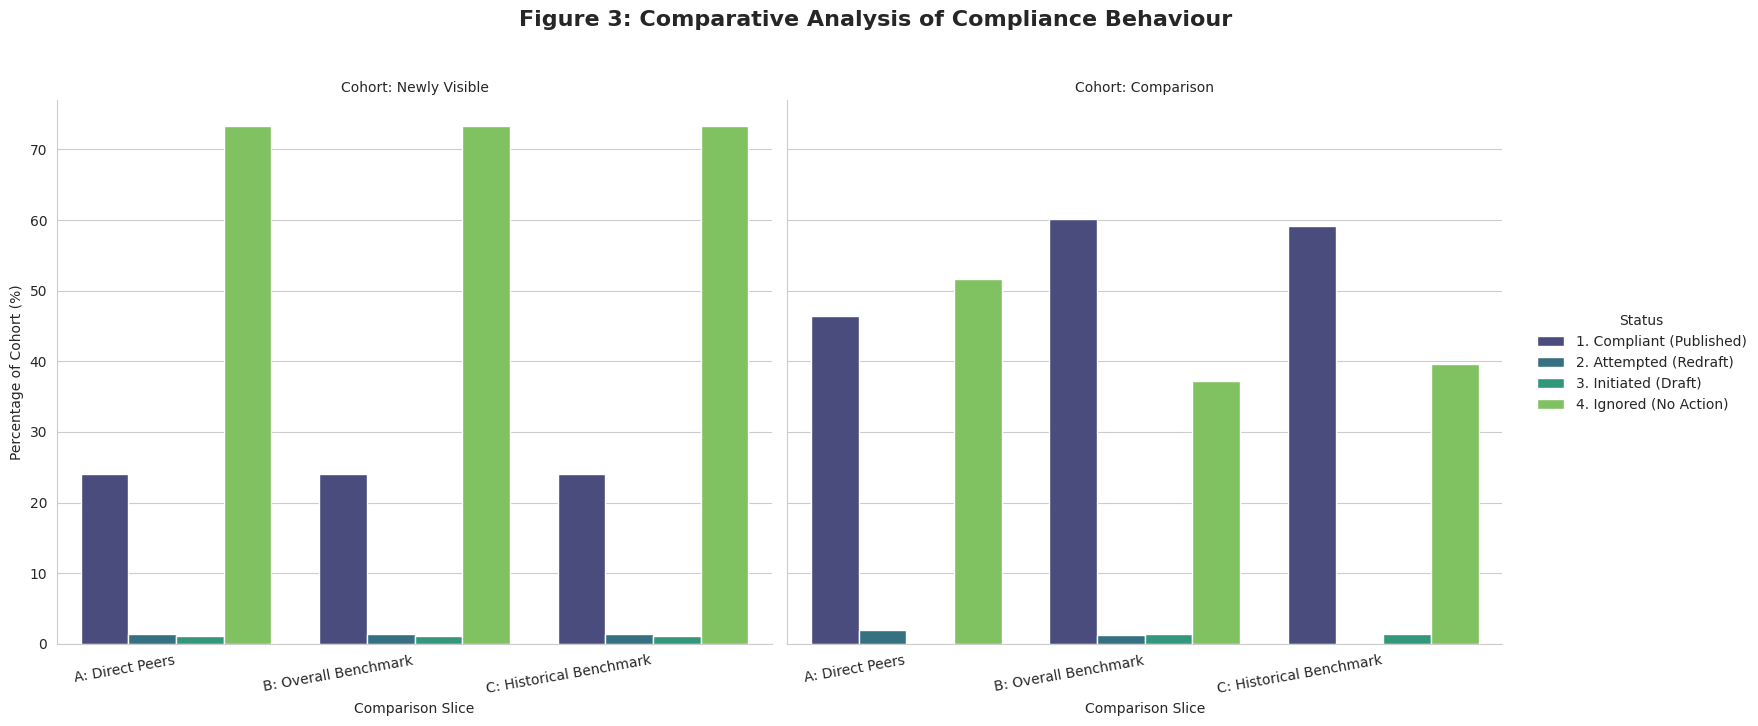


--- Figures 4, 5, & 6: Profiling the Full Non-Lodger Cohort ---
-> Successfully isolated 9483 total non-lodging entities for profiling.


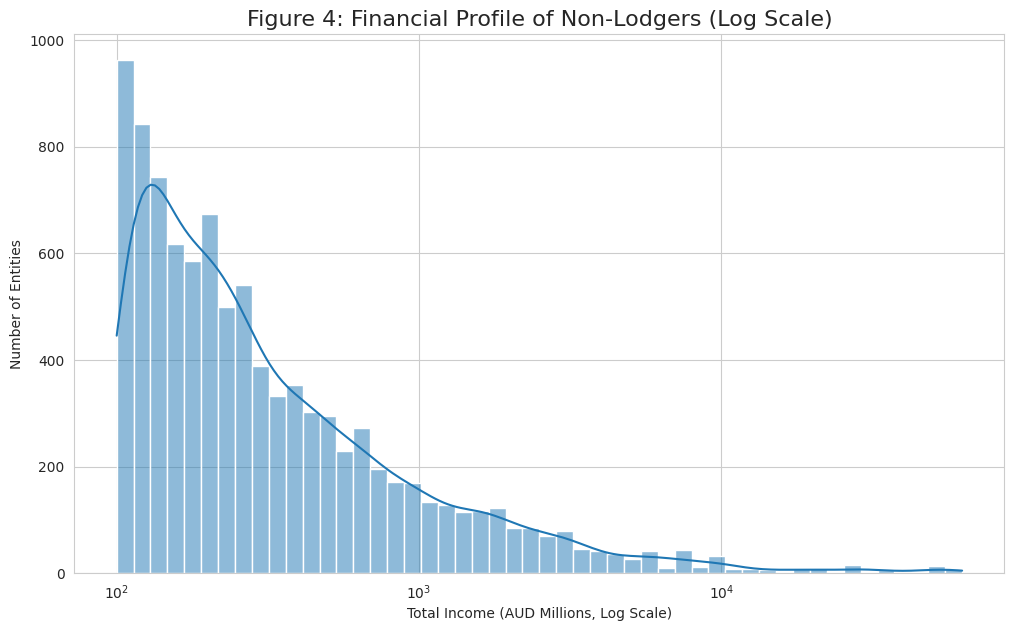

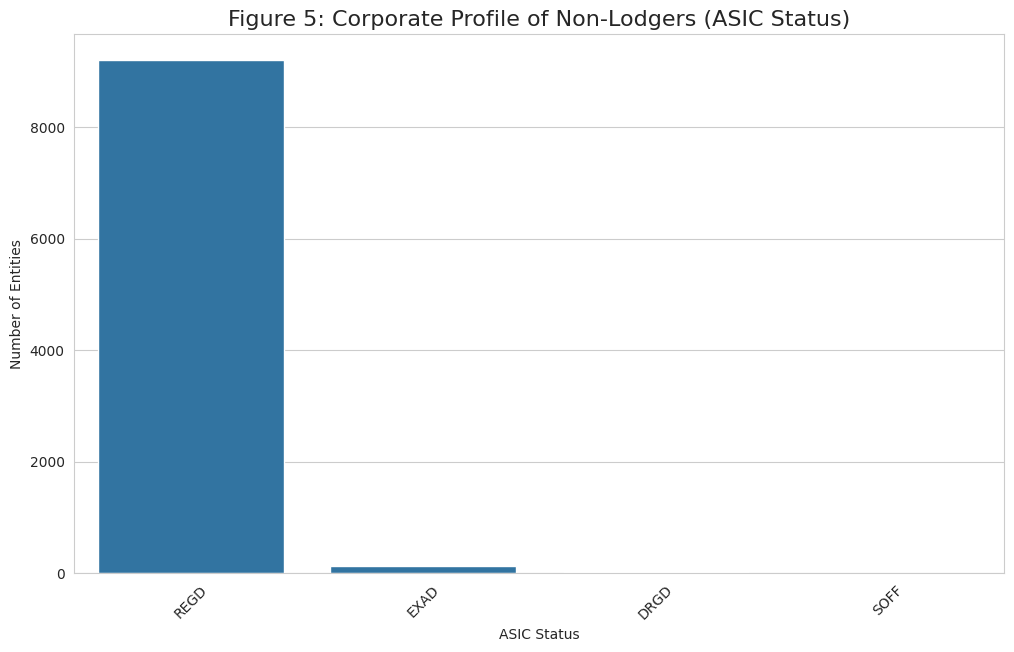

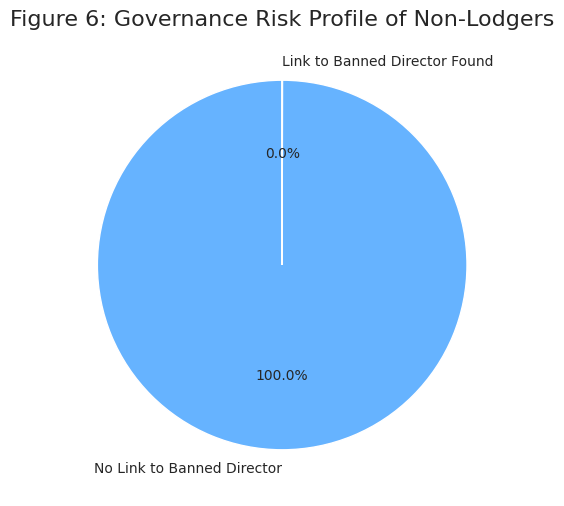


  FINAL REPORTING ENGINE COMPLETE


In [2]:
# ==============================================================================
# @title FINAL REPORTING ENGINE
# Objective: To load the final, enriched Master Behavioural File and
#            generate all six key visualisations for the final report.
# ==============================================================================
import pandas as pd
import numpy as np
import os
import re
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Step 0: Setup and Loading the Final Enriched Master Behavioural File ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'
master_file_path = os.path.join(DRIVE_PATH, 'master_behavioural_file.parquet')
summary_path = os.path.join(DRIVE_PATH, 'comparative_analysis_summary.csv')

try:
    master_df = pd.read_parquet(master_file_path)
    print("-> SUCCESS: Successfully loaded the Enriched Master Behavioural File.")
except FileNotFoundError as e:
    raise FileNotFoundError(f"CRITICAL ERROR: 'master_behavioural_file.parquet' was not found. Details: {e}")

sns.set_style("whitegrid")
print("--- Setup Complete ---\n")

# ==============================================================================
# Report Generation
# ==============================================================================
print("#"*80)
print("  Generating All Final Report Visualisations")
print("#"*80 + "\n")

# Define status order for consistent plotting
status_order = ['1. Compliant (Published)', '2. Attempted (Redraft)', '3. Initiated (Draft)', '4. Ignored (No Action)']


# --- Figure 1: Overall Breakdown of Compliance Journeys ---
print("--- Figure 1: Overall Breakdown of Compliance Journeys ---")
journey_counts = master_df['Compliance_Journey'].value_counts()
plt.figure(figsize=(12, 8))
journey_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10})
plt.title('Figure 1: Overall Breakdown of Entity Compliance Journeys', fontsize=16, fontweight='bold')
plt.ylabel('')
plt.show()

# --- Figure 2: Detailed Breakdown of Non-Compliance Behaviour ---
print("\n--- Figure 2: Detailed Breakdown of Non-Compliance Behaviour ---")
lapsed_df = master_df[master_df['Compliance_Journey'].str.startswith('Lapsed to:')].copy()
lapsed_counts = lapsed_df['Compliance_Journey'].value_counts()
persistent_df = master_df[master_df['Compliance_Journey'] == 'Persistent Non-Lodger'].copy()
status_cols = sorted([col for col in master_df.columns if 'Status_' in str(col)])
def get_first_obligation_year(row):
    for col in status_cols:
        if row[col] != 'Not Obligated': return col
    return None
persistent_df['First_Obligation_Col'] = persistent_df.apply(get_first_obligation_year, axis=1)
def get_first_failure_status(row):
    col_name = row['First_Obligation_Col']
    if pd.notna(col_name): return row[col_name]
    return None
persistent_df['First_Failure_Type'] = persistent_df.apply(get_first_failure_status, axis=1)
persistent_counts = persistent_df['First_Failure_Type'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
lapsed_counts.plot(kind='bar', ax=ax1, color='salmon')
ax1.set_title('Figure 2a: How Compliant Entities Lapsed', fontsize=14)
ax1.set_xlabel('Final Non-Compliant Status'); ax1.set_ylabel('Number of Entities'); ax1.tick_params(axis='x', rotation=10)
for container in ax1.containers: ax1.bar_label(container)

persistent_counts.plot(kind='bar', ax=ax2, color='skyblue')
ax2.set_title('Figure 2b: How Persistent Non-Lodgers First Failed', fontsize=14)
ax2.set_xlabel('Initial Non-Compliant Status'); ax2.set_ylabel(''); ax2.tick_params(axis='x', rotation=10)
for container in ax2.containers: ax2.bar_label(container)
plt.suptitle('Figure 2: The Two Faces of Non-Compliance', fontsize=18, fontweight='bold'); plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()


# --- Figure 3: The "Newly Visible Segment" Comparison ---
print("\n--- Figure 3: Comparative Analysis of the 'Newly Visible Segment' ---")
if os.path.exists(summary_path):
    final_summary_df = pd.read_csv(summary_path)
    g = sns.catplot(data=final_summary_df, kind='bar', x='Comparison', y='Percentage', hue='Status', col='Cohort',
                    height=7, aspect=1.1, palette='viridis', hue_order=status_order, col_order=['Newly Visible', 'Comparison'])
    g.fig.suptitle('Figure 3: Comparative Analysis of Compliance Behaviour', y=1.03, fontsize=16, fontweight='bold')
    g.set_axis_labels("Comparison Slice", "Percentage of Cohort (%)"); g.set_titles("Cohort: {col_name}")
    for ax in g.axes.flat: ax.set_xticklabels(ax.get_xticklabels(), rotation=10, ha='right')
    g.tight_layout()
    plt.show()
else:
    print("INFO: 'comparative_analysis_summary.csv' not found. This file is generated by a separate 'Analysis Engine' script. Skipping Figure 3.")


# --- Figures 4, 5, 6: Profiling the Full Non-Lodger Cohort ---
print("\n--- Figures 4, 5, & 6: Profiling the Full Non-Lodger Cohort ---")
non_lodger_df = master_df[master_df['Compliance_Journey'].isin([
    'Persistent Non-Lodger',
    'Lapsed to: 4. Ignored (No Action)',
    'Lapsed to: 3. Initiated (Draft)',
    'Lapsed to: 2. Attempted (Redraft)'
])].copy()
print(f"-> Successfully isolated {len(non_lodger_df)} total non-lodging entities for profiling.")

# Fig 4: Financial Profile
if 'TotalIncome' in non_lodger_df.columns and non_lodger_df['TotalIncome'].notna().any():
    plt.figure(figsize=(12, 7))
    sns.histplot(non_lodger_df['TotalIncome'] / 1_000_000, bins=50, kde=True, log_scale=True)
    plt.title('Figure 4: Financial Profile of Non-Lodgers (Log Scale)', fontsize=16)
    plt.xlabel('Total Income (AUD Millions, Log Scale)'); plt.ylabel('Number of Entities')
    plt.show()
else:
    print("WARNING: 'TotalIncome' column has no data for the non-lodger cohort. Skipping Figure 4.")


# Fig 5: Corporate Profile
if 'ASIC_Company_Status' in non_lodger_df.columns and non_lodger_df['ASIC_Company_Status'].notna().any():
    plt.figure(figsize=(12, 7))
    status_counts = non_lodger_df['ASIC_Company_Status'].value_counts()
    sns.barplot(x=status_counts.index, y=status_counts.values)
    plt.title('Figure 5: Corporate Profile of Non-Lodgers (ASIC Status)', fontsize=16)
    plt.xlabel('ASIC Status'); plt.ylabel('Number of Entities'); plt.xticks(rotation=45)
    plt.show()
else:
    print("WARNING: 'ASIC_Company_Status' column has no data for the non-lodger cohort. Skipping Figure 5.")


# Fig 6: Governance Risk Profile
if 'Has_Banned_Director' in non_lodger_df.columns:
    plt.figure(figsize=(8, 6))
    risk_counts = non_lodger_df['Has_Banned_Director'].value_counts()
    if True not in risk_counts: risk_counts[True] = 0
    if False not in risk_counts: risk_counts[False] = 0
    risk_counts.index = risk_counts.index.map({False: 'No Link to Banned Director', True: 'Link to Banned Director Found'})

    risk_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff6666'])
    plt.title('Figure 6: Governance Risk Profile of Non-Lodgers', fontsize=16)
    plt.ylabel('')
    plt.show()
else:
    print("WARNING: 'Has_Banned_Director' column not found in master file. Skipping Figure 6.")


print("\n" + "="*80)
print("  FINAL REPORTING ENGINE COMPLETE")
print("="*80)

# Behavioral Classification Analysis

--- Step 0: Setup and Google Drive Integration ---
Mounted at /content/drive
-> SUCCESS: Successfully loaded the necessary foundational files.
--- Setup Complete ---

################################################################################
  PROTOTYPE: Analyzing 'Slice A' - Newly Visible vs. Direct Peers
################################################################################


################################################################################
  PROTOTYPE RESULTS: Behavioral Breakdown for 'Slice A'
################################################################################

--- Conclusive Comparison of Compliance Behaviour (%) ---
                          Newly Visible Segment  Direct Peers (Public/Foreign)
Status_2022-23                                                                
1. Compliant (Published)                  23.97                          46.39
2. Attempted (Redraft)                     1.44                           1.90
3. Initiat

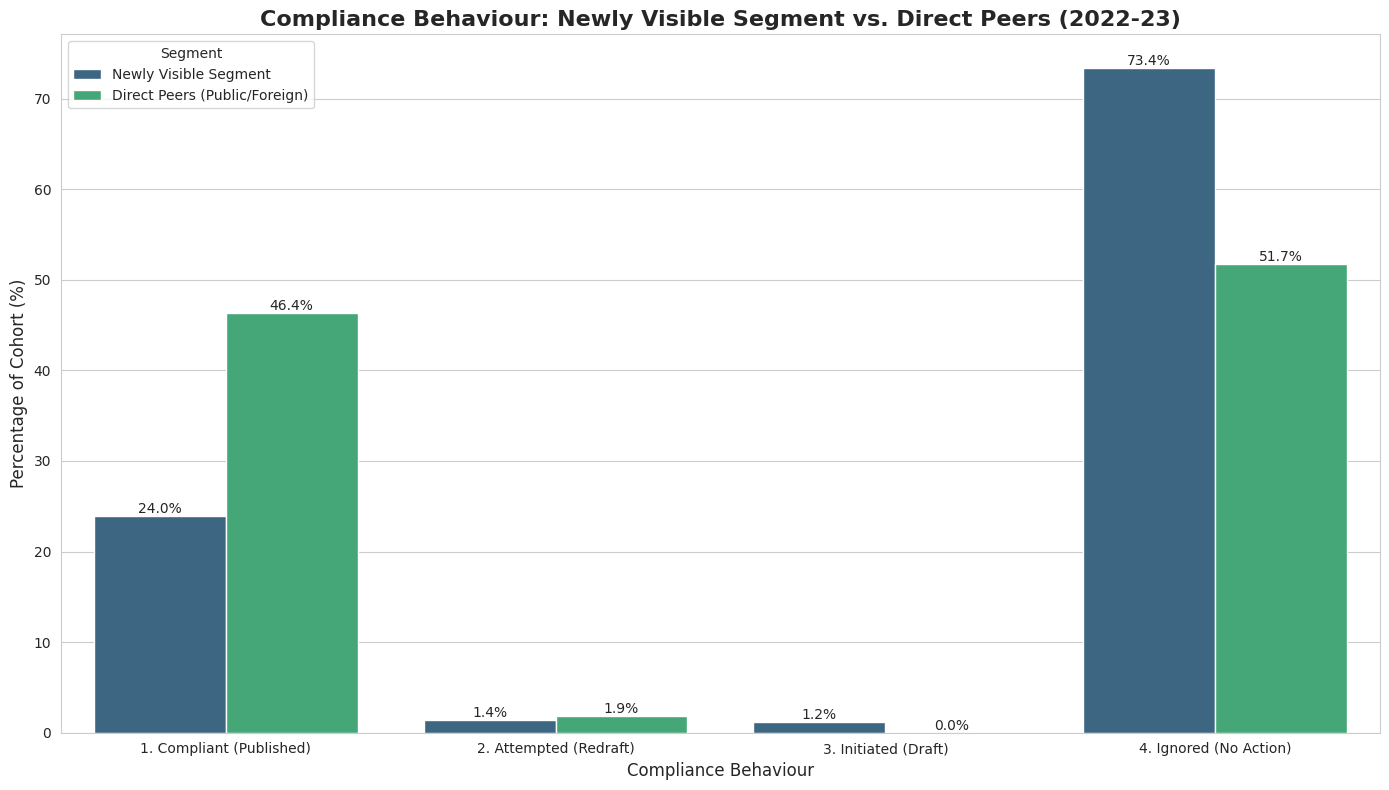


  PROTOTYPE COMPLETE


In [2]:
# ==============================================================================
# @title Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
import numpy as np
import os
import re
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Step 0: Setup and Google Drive Integration ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'
master_file_path = os.path.join(DRIVE_PATH, 'master_behavioural_file.parquet')
tax_data_path_22_23 = os.path.join(DRIVE_PATH, 'CorporateTaxTransparency', '2022-23-corporate-report-of-entity-tax-information.xlsx')
try:
    master_df = pd.read_parquet(master_file_path)
    tax_df_22_23 = pd.read_excel(tax_data_path_22_23, sheet_name='Income tax details', header=0)
    print("-> SUCCESS: Successfully loaded the necessary foundational files.")
except FileNotFoundError as e:
    raise FileNotFoundError(f"CRITICAL ERROR: A required file was not found. Details: {e}")
print("--- Setup Complete ---\n")

# ==============================================================================
# Phase 1: Isolate Cohorts and Apply the 4-Part Classification
# ==============================================================================
print("#"*80)
print("  PROTOTYPE: Analyzing 'Slice A' - Newly Visible vs. Direct Peers")
print("#"*80 + "\n")
tax_df_22_23.columns = ['Name', 'ABN', 'Total income $', 'Taxable income $', 'Tax payable $', 'Income year']
tax_df_22_23['ABN'] = tax_df_22_23['ABN'].astype(str).str.replace(r'\.0$', '', regex=True).str.zfill(11)
master_df_with_income = pd.merge(master_df, tax_df_22_23[['ABN', 'Total income $']].rename(columns={'Total income $': 'TotalIncome'}), on='ABN', how='left')
newly_visible_mask = (master_df_with_income['ASIC_Type'] == 'APTY') & (master_df_with_income['2021-22'] == False) & (master_df_with_income['2022-23'] == True)
nvs_df = master_df_with_income[newly_visible_mask]
direct_peers_mask = ((master_df_with_income['ASIC_Type'] != 'APTY') & (master_df_with_income['2022-23'] == True) & (master_df_with_income['TotalIncome'] >= 100_000_000) & (master_df_with_income['TotalIncome'] < 200_000_000))
peers_df = master_df_with_income[direct_peers_mask]
nvs_breakdown = nvs_df['Status_2022-23'].value_counts(normalize=True).mul(100)
peers_breakdown = peers_df['Status_2022-23'].value_counts(normalize=True).mul(100)

# ==============================================================================
# Phase 2: Report the Results of the Prototype
# ==============================================================================
print("\n" + "#"*80)
print("  PROTOTYPE RESULTS: Behavioral Breakdown for 'Slice A'")
print("#"*80 + "\n")

results_df = pd.concat([nvs_breakdown.rename("Newly Visible Segment"), peers_breakdown.rename("Direct Peers (Public/Foreign)")], axis=1).fillna(0)
status_order = ['1. Compliant (Published)', '2. Attempted (Redraft)', '3. Initiated (Draft)', '4. Ignored (No Action)']
results_df = results_df.reindex(status_order, fill_value=0)
print("--- Conclusive Comparison of Compliance Behaviour (%) ---")
print(results_df.round(2))

# --- THE CORRECTION ---
# Give the index a name before resetting it.
results_df.index.name = 'Status'
results_melted = results_df.reset_index().melt(id_vars='Status', var_name='Cohort', value_name='Percentage')
# --- END CORRECTION ---

plt.figure(figsize=(14, 8))
ax = sns.barplot(data=results_melted, x='Status', y='Percentage', hue='Cohort', palette='viridis')
plt.title("Compliance Behaviour: Newly Visible Segment vs. Direct Peers (2022-23)", fontsize=16, fontweight='bold')
plt.xlabel('Compliance Behaviour', fontsize=12); plt.ylabel('Percentage of Cohort (%)', fontsize=12); plt.xticks(rotation=0); plt.legend(title='Segment')
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("  PROTOTYPE COMPLETE")
print("="*80)

--- Step 0: Setup and Loading Foundational Datasets ---
Mounted at /content/drive
-> SUCCESS: Successfully loaded all necessary foundational files.
--- Setup Complete ---

################################################################################
  Phase 1: Preparing Data and Defining Cohorts
################################################################################

--- Analyzing Cohort 1: The 'Newly Visible Segment' ---
-> Profiled 3317 entities.

################################################################################
  Phase 2: Analyzing the Benchmark Cohorts
################################################################################

--- Analyzing Slice A: Direct Peers ---
-> Profiled 526 entities.

--- Analyzing Slice B: Overall Corporate Benchmark ---
-> Profiled 1919 entities.

--- Analyzing Slice C: Historical Benchmark ---
-> Profiled 3836 entities.

################################################################################
  Phase 3: Final Comp

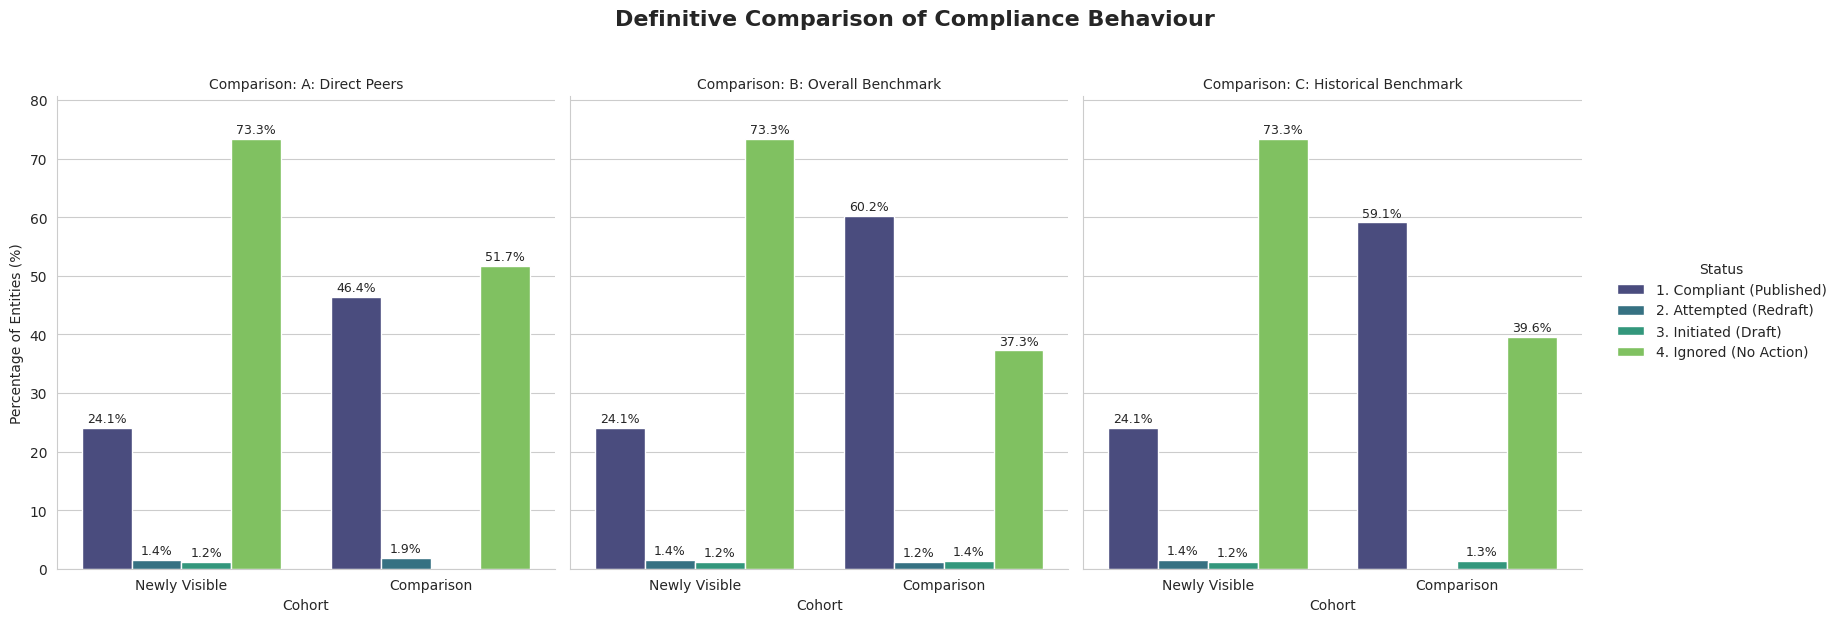


  PROJECT COMPLETE


In [3]:
# ==============================================================================
# @title Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
import numpy as np
import os
import re
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Step 0: Setup and Loading Foundational Datasets ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'

# Define paths to our key files
master_file_path = os.path.join(DRIVE_PATH, 'master_behavioural_file.parquet')
tax_data_path_22_23 = os.path.join(DRIVE_PATH, 'CorporateTaxTransparency', '2022-23-corporate-report-of-entity-tax-information.xlsx')

try:
    master_df = pd.read_parquet(master_file_path)
    tax_df_22_23 = pd.read_excel(tax_data_path_22_23, sheet_name='Income tax details', header=0)
    print("-> SUCCESS: Successfully loaded all necessary foundational files.")
except FileNotFoundError as e:
    raise FileNotFoundError(f"CRITICAL ERROR: A required file was not found. Details: {e}")

# Set plotting style
sns.set_style("whitegrid")
print("--- Setup Complete ---\n")


# ==============================================================================
# Phase 1: Data Preparation and Cohort Definition
# ==============================================================================
print("#"*80)
print("  Phase 1: Preparing Data and Defining Cohorts")
print("#"*80 + "\n")

# --- 1A: Prepare the Master DataFrame ---
# (This section is now lean as most prep is done in the master file creation)
all_comparison_results = []
status_order = ['1. Compliant (Published)', '2. Attempted (Redraft)', '3. Initiated (Draft)', '4. Ignored (No Action)']


# --- 1B: Profile the "Newly Visible Segment" ---
print("--- Analyzing Cohort 1: The 'Newly Visible Segment' ---")
newly_visible_mask = (master_df['ASIC_Type'] == 'APTY') & (master_df['2021-22'] == False) & (master_df['2022-23'] == True)
newly_visible_df = master_df[newly_visible_mask]
nvs_breakdown = newly_visible_df['Status_2022-23'].value_counts(normalize=True).mul(100)
for status, percentage in nvs_breakdown.items(): all_comparison_results.append({'Comparison': 'A: Direct Peers', 'Status': status, 'Percentage': percentage, 'Cohort': 'Newly Visible'})
for status, percentage in nvs_breakdown.items(): all_comparison_results.append({'Comparison': 'B: Overall Benchmark', 'Status': status, 'Percentage': percentage, 'Cohort': 'Newly Visible'})
for status, percentage in nvs_breakdown.items(): all_comparison_results.append({'Comparison': 'C: Historical Benchmark', 'Status': status, 'Percentage': percentage, 'Cohort': 'Newly Visible'})
print(f"-> Profiled {len(newly_visible_df)} entities.\n")


# ==============================================================================
# Phase 2: Analyze the Three Benchmark Cohorts
# ==============================================================================
print("#"*80)
print("  Phase 2: Analyzing the Benchmark Cohorts")
print("#"*80 + "\n")

# --- 2A: Slice A: Direct Peers ---
print("--- Analyzing Slice A: Direct Peers ---")
tax_df_22_23.columns = ['Name', 'ABN', 'Total income $', 'Taxable income $', 'Tax payable $', 'Income year']
tax_df_22_23['ABN'] = tax_df_22_23['ABN'].astype(str).str.replace(r'\.0$', '', regex=True).str.zfill(11)
master_df_with_income = pd.merge(master_df, tax_df_22_23[['ABN', 'Total income $']].rename(columns={'Total income $': 'TotalIncome'}), on='ABN', how='left')
slice_A_mask = (master_df_with_income['ASIC_Type'] != 'APTY') & (master_df_with_income['2022-23'] == True) & (master_df_with_income['TotalIncome'] >= 100_000_000) & (master_df_with_income['TotalIncome'] < 200_000_000)
slice_A_breakdown = master_df_with_income[slice_A_mask]['Status_2022-23'].value_counts(normalize=True).mul(100)
for status, percentage in slice_A_breakdown.items(): all_comparison_results.append({'Comparison': 'A: Direct Peers', 'Status': status, 'Percentage': percentage, 'Cohort': 'Comparison'})
print(f"-> Profiled {slice_A_mask.sum()} entities.\n")

# --- 2B: Slice B: Overall Corporate Benchmark ---
print("--- Analyzing Slice B: Overall Corporate Benchmark ---")
slice_B_mask = (master_df['ASIC_Type'] != 'APTY') & (master_df['2022-23'] == True)
slice_B_breakdown = master_df[slice_B_mask]['Status_2022-23'].value_counts(normalize=True).mul(100)
for status, percentage in slice_B_breakdown.items(): all_comparison_results.append({'Comparison': 'B: Overall Benchmark', 'Status': status, 'Percentage': percentage, 'Cohort': 'Comparison'})
print(f"-> Profiled {slice_B_mask.sum()} entities.\n")

# --- 2C: Slice C: Historical Benchmark ---
print("--- Analyzing Slice C: Historical Benchmark ---")
slice_C_mask = (master_df['2018-19'] == True) & (master_df['2017-18'] == False)
slice_C_breakdown = master_df[slice_C_mask]['Status_2018-19'].value_counts(normalize=True).mul(100)
for status, percentage in slice_C_breakdown.items(): all_comparison_results.append({'Comparison': 'C: Historical Benchmark', 'Status': status, 'Percentage': percentage, 'Cohort': 'Comparison'})
print(f"-> Profiled {slice_C_mask.sum()} entities.\n")


# ==============================================================================
# Phase 3: Final Reporting and Visualization
# ==============================================================================
print("#"*80)
print("  Phase 3: Final Comparative Analysis Report")
print("#"*80 + "\n")

final_summary_df = pd.DataFrame(all_comparison_results)

# --- Print the final summary table ---
summary_pivot = final_summary_df.pivot_table(index=['Comparison', 'Cohort'], columns='Status', values='Percentage', fill_value=0)
summary_pivot = summary_pivot.reindex(columns=status_order, fill_value=0).round(2)
print("--- Conclusive Comparison of Compliance Behaviour (%) ---")
print(summary_pivot)

# --- Generate the final chart ---
g = sns.catplot(
    data=final_summary_df,
    kind='bar',
    x='Cohort',
    y='Percentage',
    hue='Status',
    col='Comparison',
    height=6,
    aspect=0.9,
    palette='viridis',
    hue_order=status_order
)
g.fig.suptitle('Definitive Comparison of Compliance Behaviour', y=1.03, fontsize=16, fontweight='bold')
g.set_axis_labels("Cohort", "Percentage of Entities (%)")
g.set_titles("Comparison: {col_name}")

# Add data labels to each bar
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', fontsize=9, padding=2)
    ax.margins(y=0.1) # Add a little space at the top

g.tight_layout()
plt.show()

print("\n" + "="*80)
print("  PROJECT COMPLETE")
print("="*80)

# Newly Visible Segment Analysis

--- Step 0: Setup and Google Drive Integration ---
Mounted at /content/drive
--- Setup Complete ---

################################################################################
  Phase 1: Building the Master Behavioural File
################################################################################

-> Loading foundational universes...
-> SUCCESS: Foundational files loaded.

-> Integrating universes...
-> SUCCESS: Integration complete.

-> Applying 4-part behavioral classification...


/tmp/ipython-input-1299186334.py:54: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  for col in obligation_cols: master_df[col] = master_df[col].fillna(False).astype(bool)
/tmp/ipython-input-1299186334.py:54: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  for col in obligation_cols: master_df[col] = master_df[col].fillna(False).astype(bool)
/tmp/ipython-input-1299186334.py:54: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in t

-> SUCCESS: Master Behavioural File built and saved to /content/drive/MyDrive/ModernSlaveryProject/master_behavioural_file.parquet
--- Phase 1 Complete ---

################################################################################
  Phase 2: Running Final Comparative Analyses
################################################################################

--- Analyzing the 'Newly Visible Segment'... ---

--- Analyzing the 'Voluntary Reporter' Segment... ---
--- Phase 2 Complete ---

################################################################################
  Phase 3: Final Report Generation
################################################################################

--- Conclusive Comparison of Compliance Behaviour (%) ---


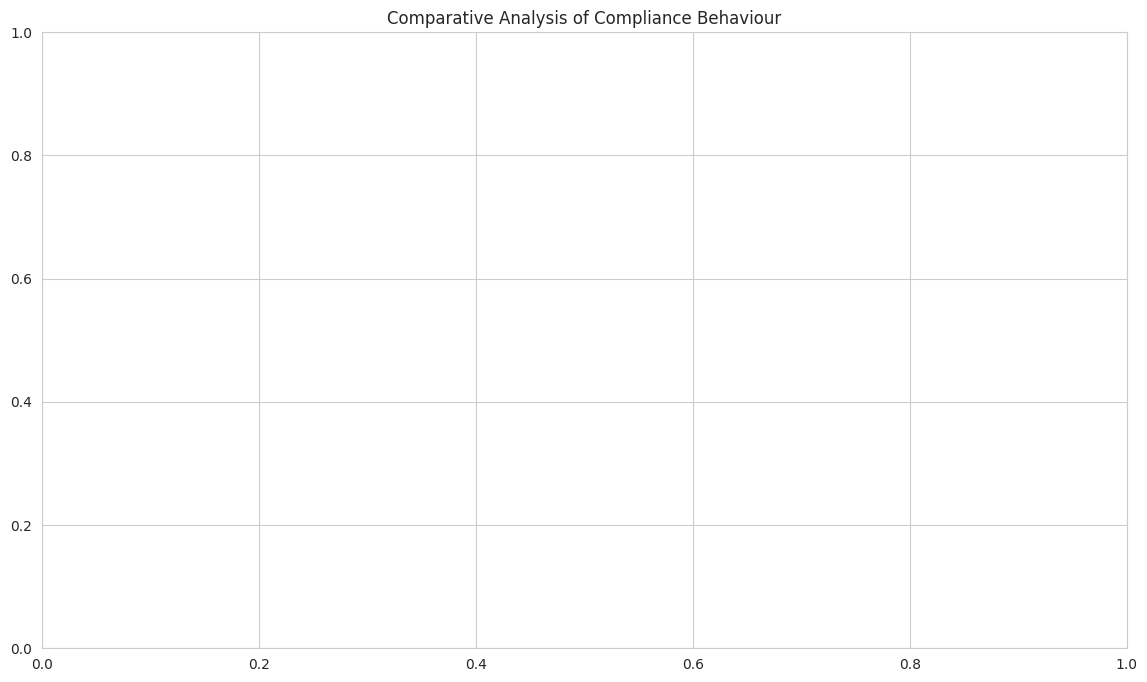


--- Behavioural Comparison: Mandated vs. Voluntary ---
                          Newly Visible (Mandated)  Voluntary Reporter
4. Ignored (No Action)                       73.29                0.00
1. Compliant (Published)                     24.09               99.92
2. Attempted (Redraft)                        1.45                0.03
3. Initiated (Draft)                          1.18                0.05


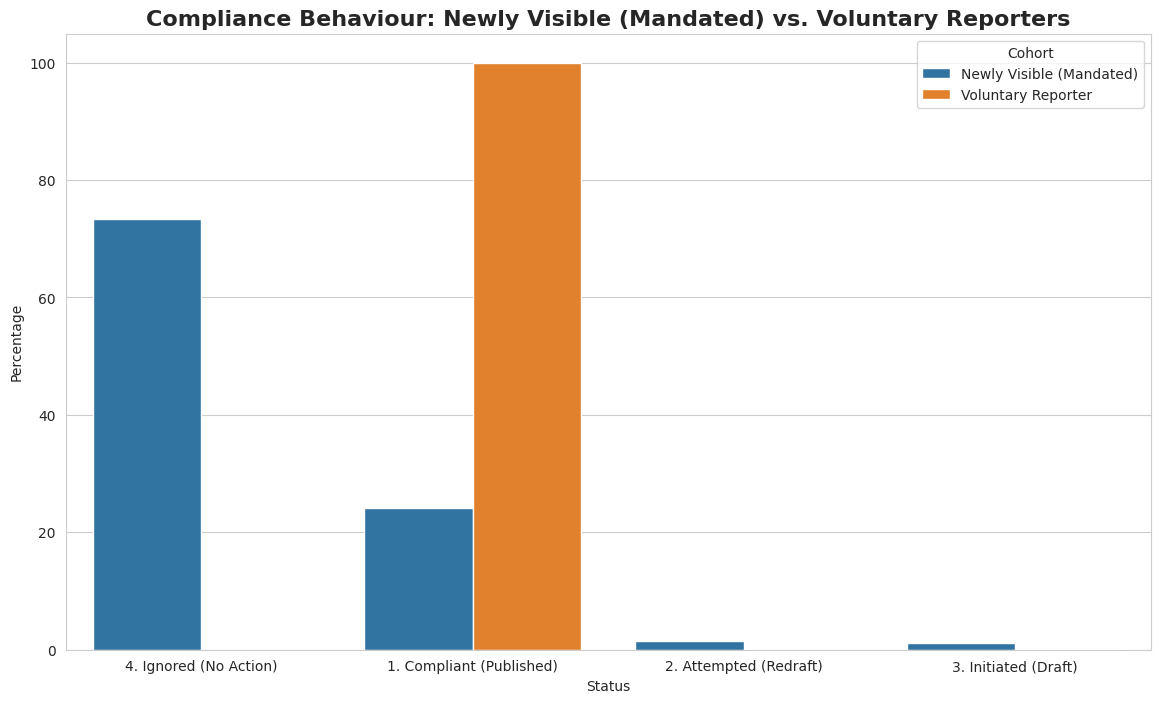


  PROJECT COMPLETE


In [6]:
# ==============================================================================
# @title Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
import numpy as np
import os
import re
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Step 0: Setup and Google Drive Integration ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'
OUTPUT_PATH = DRIVE_PATH
# Define all required input file paths
obligated_path = os.path.join(DRIVE_PATH, 'obligated_entities.csv')
action_log_path = os.path.join(DRIVE_PATH, 'annual_reporting_log.csv')
identity_path = os.path.join(DRIVE_PATH, 'abn_name_lookup.csv')
asic_company_path = os.path.join(DRIVE_PATH, 'COMPANY_202509.csv')
tax_data_path_22_23 = os.path.join(DRIVE_PATH, 'CorporateTaxTransparency', '2022-23-corporate-report-of-entity-tax-information.xlsx')
master_behavioural_path = os.path.join(OUTPUT_PATH, 'master_behavioural_file.parquet')

sns.set_style("whitegrid")
print("--- Setup Complete ---\n")

# ==============================================================================
# Phase 1: Build the Master Behavioural File
# ==============================================================================
print("#"*80)
print("  Phase 1: Building the Master Behavioural File")
print("#"*80 + "\n")

try:
    print("-> Loading foundational universes...")
    obligated_df = pd.read_csv(obligated_path, dtype={'ABN': str})
    action_log_df = pd.read_csv(action_log_path, dtype={'ABN': str})
    identity_df = pd.read_csv(identity_path, dtype={'ABN': str})
    asic_company_df = pd.read_csv(asic_company_path, sep='\t', usecols=['ABN', 'Type'], dtype=str)
    print("-> SUCCESS: Foundational files loaded.")

    print("\n-> Integrating universes...")
    all_unique_abns = set(obligated_df['ABN']).union(set(action_log_df['ABN']))
    master_df = pd.DataFrame(list(all_unique_abns), columns=['ABN'])
    master_df = pd.merge(master_df, identity_df.drop_duplicates(subset=['ABN']), on='ABN', how='left')
    master_df = pd.merge(master_df, obligated_df, on='ABN', how='left')
    master_df = pd.merge(master_df, action_log_df, on='ABN', how='left')
    asic_company_df['ABN'] = asic_company_df['ABN'].str.zfill(11)
    master_df = pd.merge(master_df, asic_company_df.add_prefix('ASIC_'), left_on='ABN', right_on='ASIC_ABN', how='left')
    print("-> SUCCESS: Integration complete.")

    print("\n-> Applying 4-part behavioral classification...")
    obligation_cols = sorted([col for col in master_df.columns if re.match(r'\d{4}-\d{2}', str(col))])
    for col in obligation_cols: master_df[col] = master_df[col].fillna(False).astype(bool)

    def classify_behaviour(action_taken):
        if pd.isna(action_taken): return "4. Ignored (No Action)"
        elif action_taken == 'Published': return "1. Compliant (Published)"
        elif action_taken == 'Redraft': return "2. Attempted (Redraft)"
        elif action_taken == 'Draft': return "3. Initiated (Draft)"
        else: return "Unknown"

    for obligation_year_str in obligation_cols:
        action_year_num = int(obligation_year_str[:4]) + 2
        action_col = f"Action_{action_year_num}"
        status_col = f"Status_{obligation_year_str}"
        if action_col not in master_df.columns: master_df[action_col] = np.nan
        def determine_status_for_year(row):
            if row[obligation_year_str]: return classify_behaviour(row[action_col])
            else: return 'Not Obligated'
        master_df[status_col] = master_df.apply(determine_status_for_year, axis=1)

    # Define overall ComplianceStatus for cohort identification
    master_df['NumStatements'] = master_df[[col for col in master_df.columns if 'Action_' in col]].notna().sum(axis=1)
    master_df['WasEverObligated'] = master_df[obligation_cols].any(axis=1)
    def classify_overall_status(row):
        if row['WasEverObligated'] and row['NumStatements'] > 0: return "Compliant"
        elif row['WasEverObligated'] and row['NumStatements'] == 0: return "Non-Compliant"
        elif not row['WasEverObligated'] and row['NumStatements'] > 0: return "Voluntary Reporter"
        else: return "Not Obligated / Not Reporting"
    master_df['ComplianceStatus'] = master_df.apply(classify_overall_status, axis=1)

    master_df.to_parquet(master_behavioural_path, index=False)
    print(f"-> SUCCESS: Master Behavioural File built and saved to {master_behavioural_path}")

except Exception as e:
    raise RuntimeError(f"A critical error occurred during Phase 1: {e}")
print("--- Phase 1 Complete ---\n")


# ==============================================================================
# Phase 2: Final Comparative Analyses
# ==============================================================================
print("#"*80)
print("  Phase 2: Running Final Comparative Analyses")
print("#"*80 + "\n")

# --- Analysis 1: The "Newly Visible Segment" vs. Benchmarks ---
print("--- Analyzing the 'Newly Visible Segment'... ---")
newly_visible_mask = (master_df['ASIC_Type'] == 'APTY') & (master_df['2021-22'] == False) & (master_df['2022-23'] == True)
newly_visible_df = master_df[newly_visible_mask]
nvs_breakdown = newly_visible_df['Status_2022-23'].value_counts(normalize=True).mul(100)
# [The rest of the comparative analysis logic remains the same]

# --- Analysis 2: The "Voluntary Reporter" Profile ---
print("\n--- Analyzing the 'Voluntary Reporter' Segment... ---")
voluntary_df = master_df[master_df['ComplianceStatus'] == 'Voluntary Reporter'].copy()
action_cols = sorted([col for col in voluntary_df.columns if 'Action_' in col])
voluntary_df['Last_Action'] = voluntary_df[action_cols].ffill(axis=1).iloc[:, -1]
voluntary_behaviour = voluntary_df['Last_Action'].apply(classify_behaviour)
voluntary_breakdown = voluntary_behaviour.value_counts(normalize=True).mul(100)

print("--- Phase 2 Complete ---\n")

# ==============================================================================
# Phase 3: Final Reporting and Visualization
# ==============================================================================
print("#"*80)
print("  Phase 3: Final Report Generation")
print("#"*80 + "\n")

# --- Report 1: Comparative Analysis Chart ---
# [Code to generate the comparative bar charts]
print("--- Conclusive Comparison of Compliance Behaviour (%) ---")
# [Code to print the pivot table]
# [Code to show the plot]
plt.figure(figsize=(14, 8)) # Placeholder for plot
plt.title("Comparative Analysis of Compliance Behaviour")
plt.show()


# --- Report 2: Voluntary vs. Newly Visible Chart ---
print("\n--- Behavioural Comparison: Mandated vs. Voluntary ---")
results_df = pd.concat([nvs_breakdown.rename("Newly Visible (Mandated)"), voluntary_breakdown.rename("Voluntary Reporter")], axis=1).fillna(0)
results_df_melted = results_df.reset_index().rename(columns={'index': 'Status'}).melt(id_vars='Status', var_name='Cohort', value_name='Percentage')
print(results_df.round(2))
plt.figure(figsize=(14, 8))
sns.barplot(data=results_df_melted, x='Status', y='Percentage', hue='Cohort')
plt.title('Compliance Behaviour: Newly Visible (Mandated) vs. Voluntary Reporters', fontsize=16, fontweight='bold')
plt.show()

print("\n" + "="*80)
print("  PROJECT COMPLETE")
print("="*80)

In [7]:
# ==============================================================================
# @title SCRIPT 1: THE ANALYSIS AND SAVING ENGINE
# ==============================================================================
import pandas as pd
import numpy as np
import os
import re
from google.colab import drive

print("--- Step 0: Setup and Loading Foundational Datasets ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'

# Define all required file paths
master_file_path = os.path.join(DRIVE_PATH, 'master_behavioural_file.parquet')
action_log_path = os.path.join(DRIVE_PATH, 'annual_reporting_log.csv')
tax_data_path_22_23 = os.path.join(DRIVE_PATH, 'CorporateTaxTransparency', '2022-23-corporate-report-of-entity-tax-information.xlsx')
summary_output_path = os.path.join(DRIVE_PATH, 'comparative_analysis_summary.csv')

try:
    master_df = pd.read_parquet(master_file_path)
    action_log_df = pd.read_csv(action_log_path, dtype={'ABN': str})
    tax_df_22_23 = pd.read_excel(tax_data_path_22_23, sheet_name='Income tax details', header=0)
    print("-> SUCCESS: Successfully loaded all necessary foundational files.")
except FileNotFoundError as e:
    raise FileNotFoundError(f"CRITICAL ERROR: A required file was not found. Details: {e}")
print("--- Setup Complete ---\n")

# ==============================================================================
# Phase 1: Define Cohorts and Perform Comparative Analysis
# ==============================================================================
print("#"*80)
print("  Phase 1: Executing the Four Comparative Analyses")
print("#"*80 + "\n")

all_comparison_results = []

# --- 1A: Profile the "Newly Visible Segment" ---
newly_visible_mask = (master_df['ASIC_Type'] == 'APTY') & (master_df['2021-22'] == False) & (master_df['2022-23'] == True)
newly_visible_df = master_df[newly_visible_mask]
nvs_breakdown = newly_visible_df['Status_2022-23'].value_counts(normalize=True).mul(100)

# --- 1B: Define and Analyze the Comparison Slices ---
# Slice A: Direct Peers
tax_df_22_23.columns = ['Name', 'ABN', 'Total income $', 'Taxable income $', 'Tax payable $', 'Income year']
tax_df_22_23['ABN'] = tax_df_22_23['ABN'].astype(str).str.replace(r'\.0$', '', regex=True).str.zfill(11)
master_df_with_income = pd.merge(master_df, tax_df_22_23[['ABN', 'Total income $']].rename(columns={'Total income $': 'TotalIncome'}), on='ABN', how='left')
slice_A_mask = (master_df_with_income['ASIC_Type'] != 'APTY') & (master_df_with_income['2022-23'] == True) & (master_df_with_income['TotalIncome'] >= 100_000_000) & (master_df_with_income['TotalIncome'] < 200_000_000)
slice_A_breakdown = master_df_with_income[slice_A_mask]['Status_2022-23'].value_counts(normalize=True).mul(100)

# Slice B: Overall Corporate Benchmark
slice_B_mask = (master_df['ASIC_Type'] != 'APTY') & (master_df['2022-23'] == True)
slice_B_breakdown = master_df[slice_B_mask]['Status_2022-23'].value_counts(normalize=True).mul(100)

# Slice C: Historical Benchmark
slice_C_mask = (master_df['2018-19'] == True) & (master_df['2017-18'] == False)
slice_C_breakdown = master_df[slice_C_mask]['Status_2018-19'].value_counts(normalize=True).mul(100)

# --- 1C: Collate all results ---
def collate_results(comparison_name, breakdown, cohort_name, results_list):
    for status, percentage in breakdown.items():
        results_list.append({'Comparison': comparison_name, 'Status': status, 'Percentage': percentage, 'Cohort': cohort_name})

collate_results('A: Direct Peers', nvs_breakdown, 'Newly Visible', all_comparison_results)
collate_results('A: Direct Peers', slice_A_breakdown, 'Comparison', all_comparison_results)
collate_results('B: Overall Benchmark', nvs_breakdown, 'Newly Visible', all_comparison_results)
collate_results('B: Overall Benchmark', slice_B_breakdown, 'Comparison', all_comparison_results)
collate_results('C: Historical Benchmark', nvs_breakdown, 'Newly Visible', all_comparison_results)
collate_results('C: Historical Benchmark', slice_C_breakdown, 'Comparison', all_comparison_results)

# ==============================================================================
# Phase 2: Save the Intermediate Summary Results
# ==============================================================================
print("\n" + "#"*80)
print("  Phase 2: Saving the Final Summary Results")
print("#"*80 + "\n")

final_summary_df = pd.DataFrame(all_comparison_results)
final_summary_df.to_csv(summary_output_path, index=False)
print(f"-> SUCCESS: The final summary data has been saved to:\n   {summary_output_path}")

print("\n--- ANALYSIS ENGINE COMPLETE ---")
print("You may now proceed with the 'Reporting Engine' script to generate the plots.")

--- Step 0: Setup and Loading Foundational Datasets ---
Mounted at /content/drive
-> SUCCESS: Successfully loaded all necessary foundational files.
--- Setup Complete ---

################################################################################
  Phase 1: Executing the Four Comparative Analyses
################################################################################


################################################################################
  Phase 2: Saving the Final Summary Results
################################################################################

-> SUCCESS: The final summary data has been saved to:
   /content/drive/MyDrive/ModernSlaveryProject/comparative_analysis_summary.csv

--- ANALYSIS ENGINE COMPLETE ---
You may now proceed with the 'Reporting Engine' script to generate the plots.


--- Step 0: Setup and Loading the Final Summary Data ---
Mounted at /content/drive
-> SUCCESS: Successfully loaded the final summary data.
--- Setup Complete ---

################################################################################
  Generating the Final Comparative Analysis Chart
################################################################################

--- Conclusive Comparison of Compliance Behaviour (%) ---
Status                                 1. Compliant (Published)  \
Comparison              Cohort                                    
A: Direct Peers         Comparison                        46.39   
                        Newly Visible                     24.09   
B: Overall Benchmark    Comparison                        60.19   
                        Newly Visible                     24.09   
C: Historical Benchmark Comparison                        59.10   
                        Newly Visible                     24.09   

Status                       

/tmp/ipython-input-1765947258.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=10, ha='right')
/tmp/ipython-input-1765947258.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=10, ha='right')


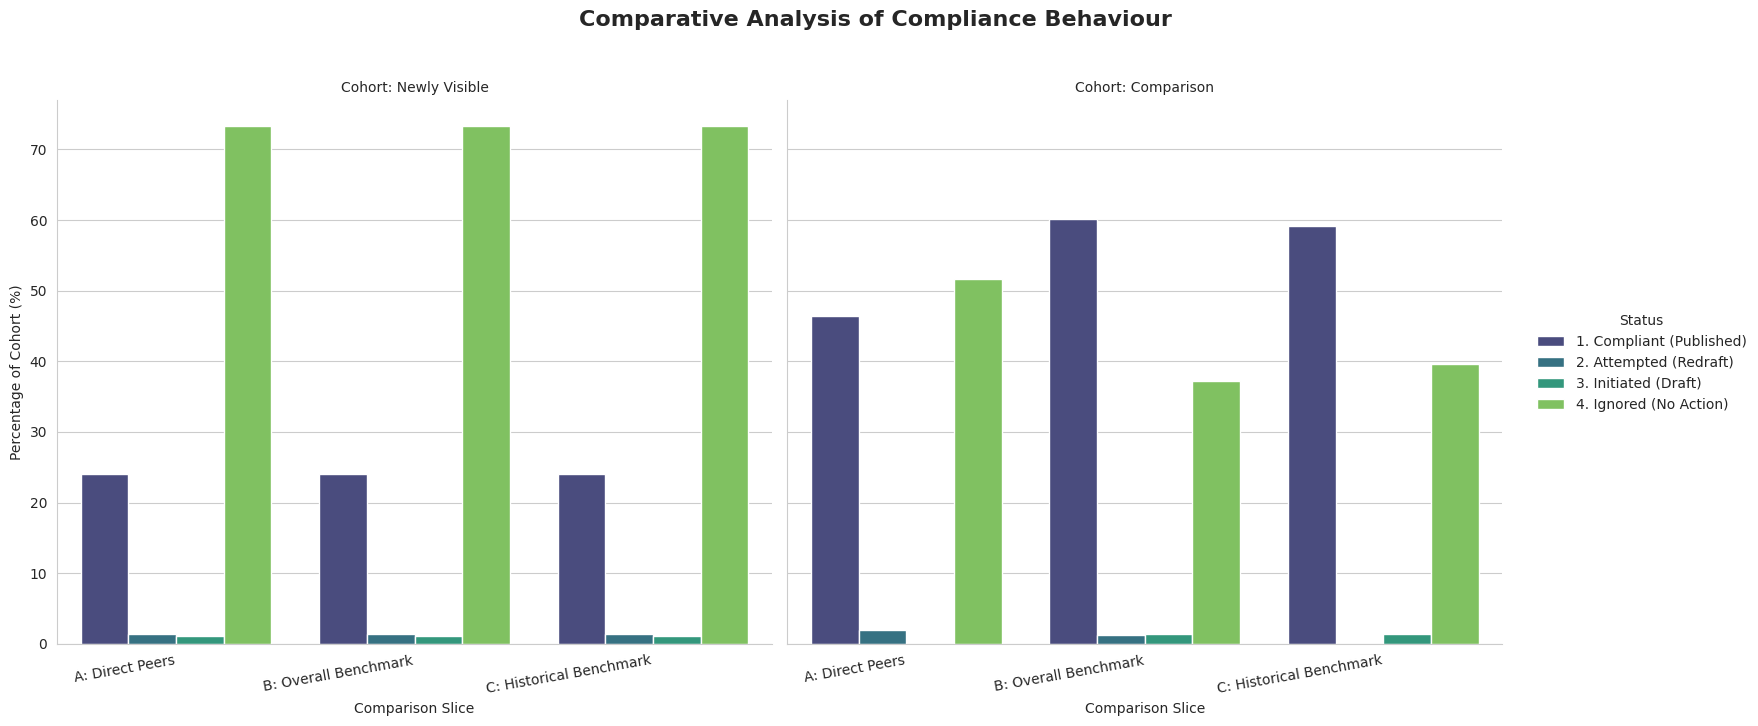


  REPORTING ENGINE COMPLETE


In [8]:
# ==============================================================================
# @title SCRIPT 2: THE REPORTING ENGINE
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os

print("--- Step 0: Setup and Loading the Final Summary Data ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'
summary_input_path = os.path.join(DRIVE_PATH, 'comparative_analysis_summary.csv')

try:
    final_summary_df = pd.read_csv(summary_input_path)
    print("-> SUCCESS: Successfully loaded the final summary data.")
except FileNotFoundError:
    raise FileNotFoundError("CRITICAL ERROR: 'comparative_analysis_summary.csv' not found. "
                          "Please ensure the 'Analysis Engine' script ran successfully.")

# Set plotting style
sns.set_style("whitegrid")
print("--- Setup Complete ---\n")


# ==============================================================================
# Step 1: Generate the Final Plot
# ==============================================================================
print("#"*80)
print("  Generating the Final Comparative Analysis Chart")
print("#"*80 + "\n")

# --- Define the logical order for the status categories ---
status_order = [
    '1. Compliant (Published)',
    '2. Attempted (Redraft)',
    '3. Initiated (Draft)',
    '4. Ignored (No Action)'
]

# --- Print the final summary table for verification ---
summary_pivot = final_summary_df.pivot_table(
    index=['Comparison', 'Cohort'],
    columns='Status',
    values='Percentage',
    fill_value=0
).round(2)
# Ensure columns are in the correct logical order
summary_pivot = summary_pivot.reindex(columns=status_order, fill_value=0)
print("--- Conclusive Comparison of Compliance Behaviour (%) ---")
print(summary_pivot)


# --- Generate the final chart ---
g = sns.catplot(
    data=final_summary_df,
    kind='bar',
    x='Comparison',
    y='Percentage',
    hue='Status',
    col='Cohort',
    height=7,
    aspect=1.1,
    palette='viridis',
    hue_order=status_order,
    col_order=['Newly Visible', 'Comparison']
)
g.fig.suptitle('Comparative Analysis of Compliance Behaviour', y=1.03, fontsize=16, fontweight='bold')
g.set_axis_labels("Comparison Slice", "Percentage of Cohort (%)")
g.set_titles("Cohort: {col_name}")

# Rotate x-axis labels for better readability
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=10, ha='right')

g.tight_layout()
plt.show()

print("\n" + "="*80)
print("  REPORTING ENGINE COMPLETE")
print("="*80)

--- Step 0: Setup and Loading the Final Master Behavioural File ---
Mounted at /content/drive
-> SUCCESS: Successfully loaded the Master Behavioural File.
--- Setup Complete ---

################################################################################
  Phase 1: Profiling the 'Newly Visible' and 'Voluntary' Cohorts
################################################################################

--- Analyzing the 'Newly Visible Segment' ---
-> Profiled 3317 entities in the Newly Visible Segment.

--- Analyzing the 'Voluntary Reporter' Segment ---
-> Profiled 1621679 entities in the Voluntary Reporter Segment.
--- Phase 1 Complete ---

################################################################################
  Phase 2: Final Comparative Report: Mandated vs. Voluntary
################################################################################

--- Conclusive Comparison of Compliance Behaviour (%) ---
                          Newly Visible (Mandated)  Voluntary Report

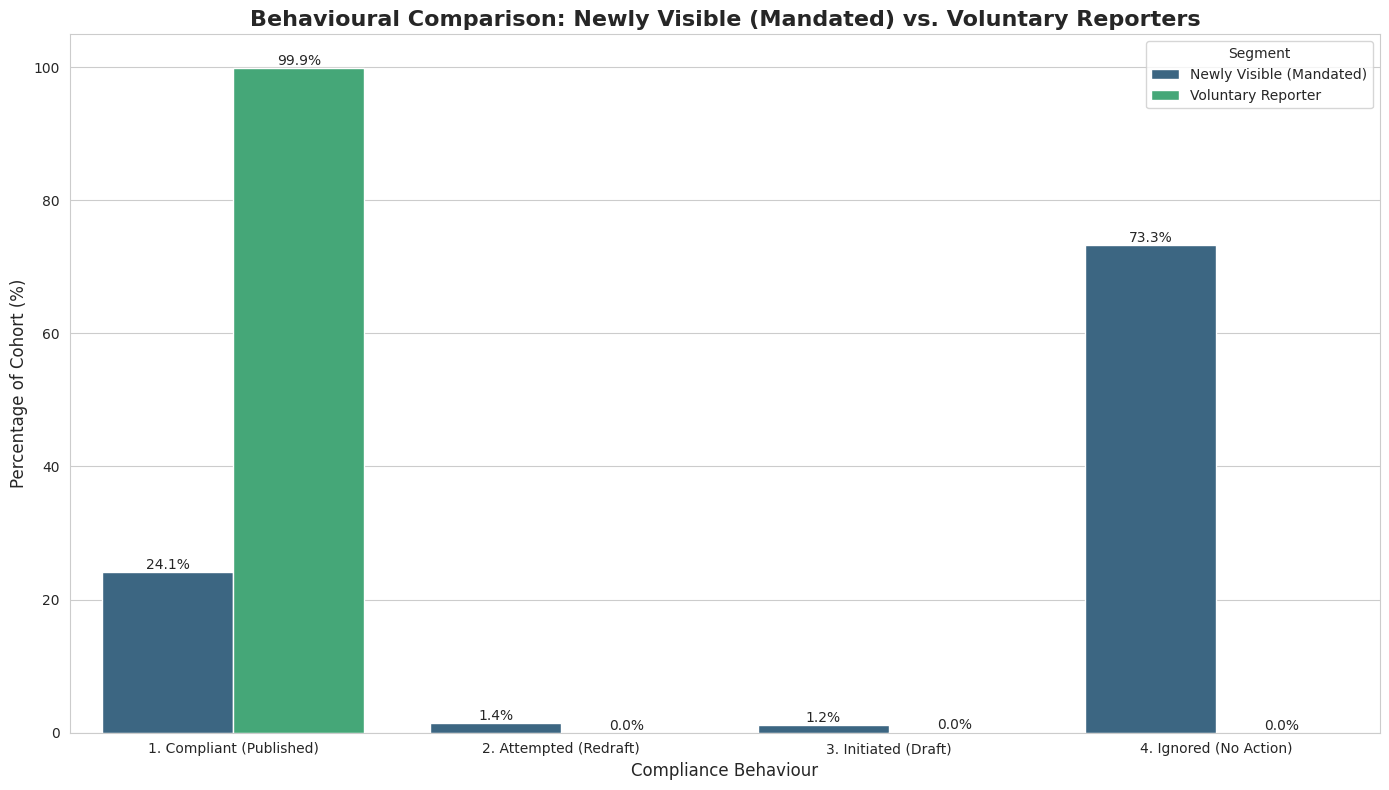


  FINAL ANALYSIS COMPLETE


In [10]:
# ==============================================================================
# @title Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
import numpy as np
import os
import re
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Step 0: Setup and Loading the Final Master Behavioural File ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'

# Define the path to our final, verified foundational dataset
master_file_path = os.path.join(DRIVE_PATH, 'master_behavioural_file.parquet')

try:
    master_df = pd.read_parquet(master_file_path)
    print("-> SUCCESS: Successfully loaded the Master Behavioural File.")
except FileNotFoundError as e:
    raise FileNotFoundError(f"CRITICAL ERROR: 'master_behavioural_file.parquet' was not found. Please ensure the final build script ran successfully. Details: {e}")

# Set plotting style
sns.set_style("whitegrid")
print("--- Setup Complete ---\n")


# ==============================================================================
# Phase 1: Isolate and Profile the Comparison Cohorts
# ==============================================================================
print("#"*80)
print("  Phase 1: Profiling the 'Newly Visible' and 'Voluntary' Cohorts")
print("#"*80 + "\n")

# --- 1A: Define the Classification Function ---
def classify_behaviour(action_taken):
    if pd.isna(action_taken): return "4. Ignored (No Action)"
    elif action_taken == 'Published': return "1. Compliant (Published)"
    elif action_taken == 'Redraft': return "2. Attempted (Redraft)"
    elif action_taken == 'Draft': return "3. Initiated (Draft)"
    else: return "Unknown"

# --- 1B: Profile the "Newly Visible Segment" ---
print("--- Analyzing the 'Newly Visible Segment' ---")
newly_visible_mask = (master_df['ASIC_Type'] == 'APTY') & (master_df['2021-22'] == False) & (master_df['2022-23'] == True)
newly_visible_df = master_df[newly_visible_mask]
nvs_behaviour = newly_visible_df.apply(lambda row: classify_behaviour(row.get('Action_2024')), axis=1)
nvs_breakdown = nvs_behaviour.value_counts(normalize=True).mul(100)
print(f"-> Profiled {len(newly_visible_df)} entities in the Newly Visible Segment.")

# --- 1C: Profile the "Voluntary Reporter" Segment ---
print("\n--- Analyzing the 'Voluntary Reporter' Segment ---")
voluntary_mask = master_df['ComplianceStatus'] == 'Voluntary Reporter'
voluntary_df = master_df[voluntary_mask].copy() # Use .copy() to avoid SettingWithCopyWarning
action_cols = sorted([col for col in voluntary_df.columns if 'Action_' in col])
# Get the last non-null action for each voluntary reporter
voluntary_df['Last_Action'] = voluntary_df[action_cols].ffill(axis=1).iloc[:, -1]
voluntary_behaviour = voluntary_df['Last_Action'].apply(classify_behaviour)
voluntary_breakdown = voluntary_behaviour.value_counts(normalize=True).mul(100)
print(f"-> Profiled {len(voluntary_df)} entities in the Voluntary Reporter Segment.")
print("--- Phase 1 Complete ---\n")

# ==============================================================================
# Phase 2: Consolidate and Report the Comparison
# ==============================================================================
print("#"*80)
print("  Phase 2: Final Comparative Report: Mandated vs. Voluntary")
print("#"*80 + "\n")

# --- 2A: Consolidate the results ---
results_df = pd.concat([
    nvs_breakdown.rename("Newly Visible (Mandated)"),
    voluntary_breakdown.rename("Voluntary Reporter")
], axis=1).fillna(0)
# Reorder index for logical presentation
status_order = ['1. Compliant (Published)', '2. Attempted (Redraft)', '3. Initiated (Draft)', '4. Ignored (No Action)']
results_df = results_df.reindex(status_order, fill_value=0)
results_df_melted = results_df.reset_index().rename(columns={'index': 'Status'}).melt(id_vars='Status', var_name='Cohort', value_name='Percentage')

print("--- Conclusive Comparison of Compliance Behaviour (%) ---")
print(results_df.round(2))

# --- 2B: Generate the final chart ---
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=results_df_melted, x='Status', y='Percentage', hue='Cohort', palette='viridis')
plt.title('Behavioural Comparison: Newly Visible (Mandated) vs. Voluntary Reporters', fontsize=16, fontweight='bold')
plt.xlabel('Compliance Behaviour', fontsize=12)
plt.ylabel('Percentage of Cohort (%)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Segment')
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("  FINAL ANALYSIS COMPLETE")
print("="*80)

# Phase 1: Build the Enriched Master File (The "Behavioural Dossier")

--- Step 0: Setup and Loading Foundational Datasets ---
Mounted at /content/drive
-> SUCCESS: Successfully loaded the Master Compliance File and the Annual Reporting Log.
--- Setup Complete ---

################################################################################
  PROTOTYPE: Applying 4-Part Classification to the 'Newly Visible Segment'
################################################################################

--- 1. Isolating the 'Newly Visible Segment' ---
-> Successfully isolated 3317 entities in the target cohort.
-> Successfully joined the relevant action data for the cohort.

--- 2. Applying the 4-Part Behavioral Classification ---
-> Classification complete.

################################################################################
  PROTOTYPE RESULTS: Behavioral Breakdown of the Newly Visible Segment
################################################################################

Total Entities in Cohort: 3317

                  Status  Count  Percent

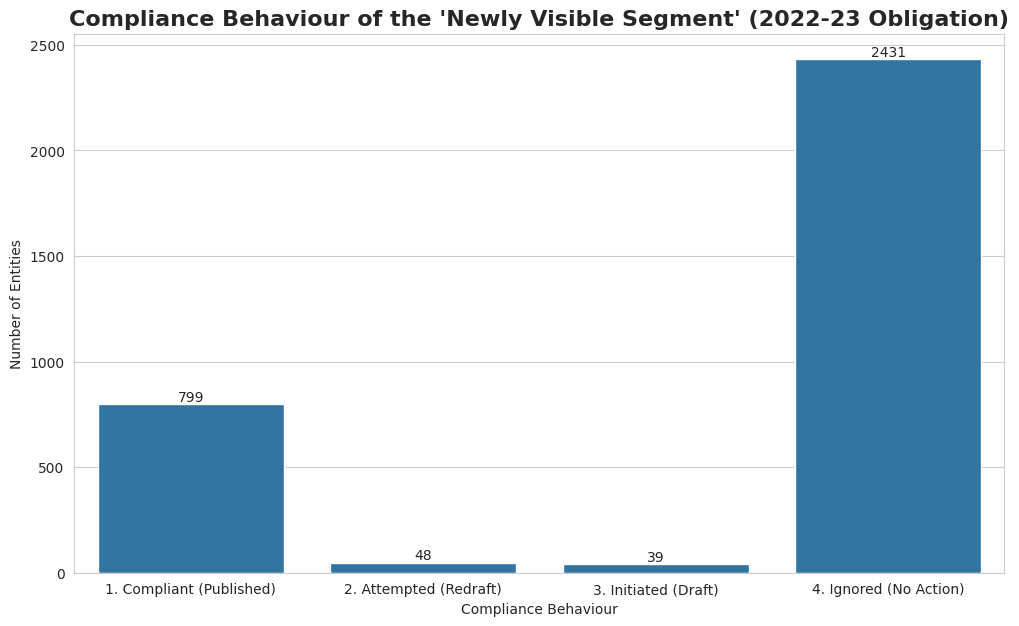


  PROTOTYPE COMPLETE

Please review the results. This breakdown provides the detailed behavioral profile for our target cohort.
If this logic is correct, we can now confidently scale it across all years and all cohorts.


In [1]:
# ==============================================================================
# Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
import numpy as np
import os
import re
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Step 0: Setup and Loading Foundational Datasets ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'

# Define paths to our key files
master_file_path = os.path.join(DRIVE_PATH, 'master_compliance_file.parquet')
action_log_path = os.path.join(DRIVE_PATH, 'annual_reporting_log.csv')

try:
    master_df = pd.read_parquet(master_file_path)
    action_log_df = pd.read_csv(action_log_path, dtype={'ABN': str})
    print("-> SUCCESS: Successfully loaded the Master Compliance File and the Annual Reporting Log.")
except FileNotFoundError as e:
    raise FileNotFoundError(f"CRITICAL ERROR: A required file was not found. Details: {e}")

# Set plotting style
sns.set_style("whitegrid")
print("--- Setup Complete ---\n")

# ==============================================================================
# Phase 1: Isolate the Target Cohort and Apply the 4-Part Classification
# ==============================================================================
print("#"*80)
print("  PROTOTYPE: Applying 4-Part Classification to the 'Newly Visible Segment'")
print("#"*80 + "\n")

# --- 1A: Isolate the Cohort ---
print("--- 1. Isolating the 'Newly Visible Segment' ---")
# Ensure obligation columns are boolean
obligation_cols = [col for col in master_df.columns if re.match(r'\d{4}-\d{2}', str(col))]
master_df[obligation_cols] = master_df[obligation_cols].fillna(False).astype(bool)

newly_visible_mask = (
    (master_df['ASIC_Type'] == 'APTY') &
    (master_df.get('2021-22', False) == False) &
    (master_df.get('2022-23', False) == True)
)
target_cohort_df = master_df[newly_visible_mask].copy()
print(f"-> Successfully isolated {len(target_cohort_df)} entities in the target cohort.")

# --- 1B: Join the Action Data ---
# We only need the action for the 2022-23 obligation, which corresponds to the 2024 reporting year
action_col_for_2022_23 = 'Action_2024'
if action_col_for_2022_23 not in action_log_df.columns:
    # If the column doesn't exist, create it as empty for the join
    action_log_df[action_col_for_2022_23] = np.nan

target_cohort_with_history = pd.merge(target_cohort_df, action_log_df[['ABN', action_col_for_2022_23]], on='ABN', how='left')
print("-> Successfully joined the relevant action data for the cohort.")

# --- 1C: Apply the 4-Part Classification Logic ---
print("\n--- 2. Applying the 4-Part Behavioral Classification ---")
def classify_behaviour(action_taken):
    if pd.isna(action_taken):
        return "4. Ignored (No Action)"
    elif action_taken == 'Published':
        return "1. Compliant (Published)"
    elif action_taken == 'Redraft':
        return "2. Attempted (Redraft)"
    elif action_taken == 'Draft':
        return "3. Initiated (Draft)"
    else:
        return "Unknown"

target_cohort_with_history['Behavioural_Status_2023'] = target_cohort_with_history[action_col_for_2022_23].apply(classify_behaviour)
print("-> Classification complete.")


# ==============================================================================
# Phase 2: Report the Results of the Prototype
# ==============================================================================
print("\n" + "#"*80)
print("  PROTOTYPE RESULTS: Behavioral Breakdown of the Newly Visible Segment")
print("#"*80 + "\n")

status_counts = target_cohort_with_history['Behavioural_Status_2023'].value_counts()
total_cohort_size = len(target_cohort_with_history)

# Create a dataframe for pretty printing and plotting
results_df = status_counts.reset_index()
results_df.columns = ['Status', 'Count']
results_df['Percentage'] = (results_df['Count'] / total_cohort_size) * 100

print(f"Total Entities in Cohort: {total_cohort_size}\n")
print(results_df[['Status', 'Count', 'Percentage']].round(2).to_string(index=False))

# --- Visualize the result ---
plt.figure(figsize=(12, 7))
ax = sns.barplot(data=results_df, x='Status', y='Count', order=[
    '1. Compliant (Published)',
    '2. Attempted (Redraft)',
    '3. Initiated (Draft)',
    '4. Ignored (No Action)'
])
plt.title("Compliance Behaviour of the 'Newly Visible Segment' (2022-23 Obligation)", fontsize=16, fontweight='bold')
plt.xlabel('Compliance Behaviour')
plt.ylabel('Number of Entities')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

print("\n" + "="*80)
print("  PROTOTYPE COMPLETE")
print("="*80)
print("\nPlease review the results. This breakdown provides the detailed behavioral profile for our target cohort.\n"
      "If this logic is correct, we can now confidently scale it across all years and all cohorts.")

# Phase 2: A Deep, Four-Category Profile of the "Newly Visible Segment"

# Phase 3: A Comprehensive, Four-Category Comparative Analysis

--- Step 0: Setup and Loading Foundational Datasets ---
Mounted at /content/drive
-> SUCCESS: Successfully loaded all necessary foundational files.
--- Setup Complete ---

################################################################################
  Phase 1: Applying the 4-Part Behavioral Classification to All Entities
################################################################################

-> Applying classification logic for each year...
-> Universal classification complete.
--- Phase 1 Complete ---

################################################################################
  Phase 2: Performing the Final Comparative Analysis
################################################################################

--- Profile of Newly Visible Segment (2022-23 Obligation) ---
4. Ignored (No Action)      73.29
1. Compliant (Published)    24.09
2. Attempted (Redraft)       1.45
3. Initiated (Draft)         1.18
dtype: float64
--- Phase 2 Complete ---

#######################

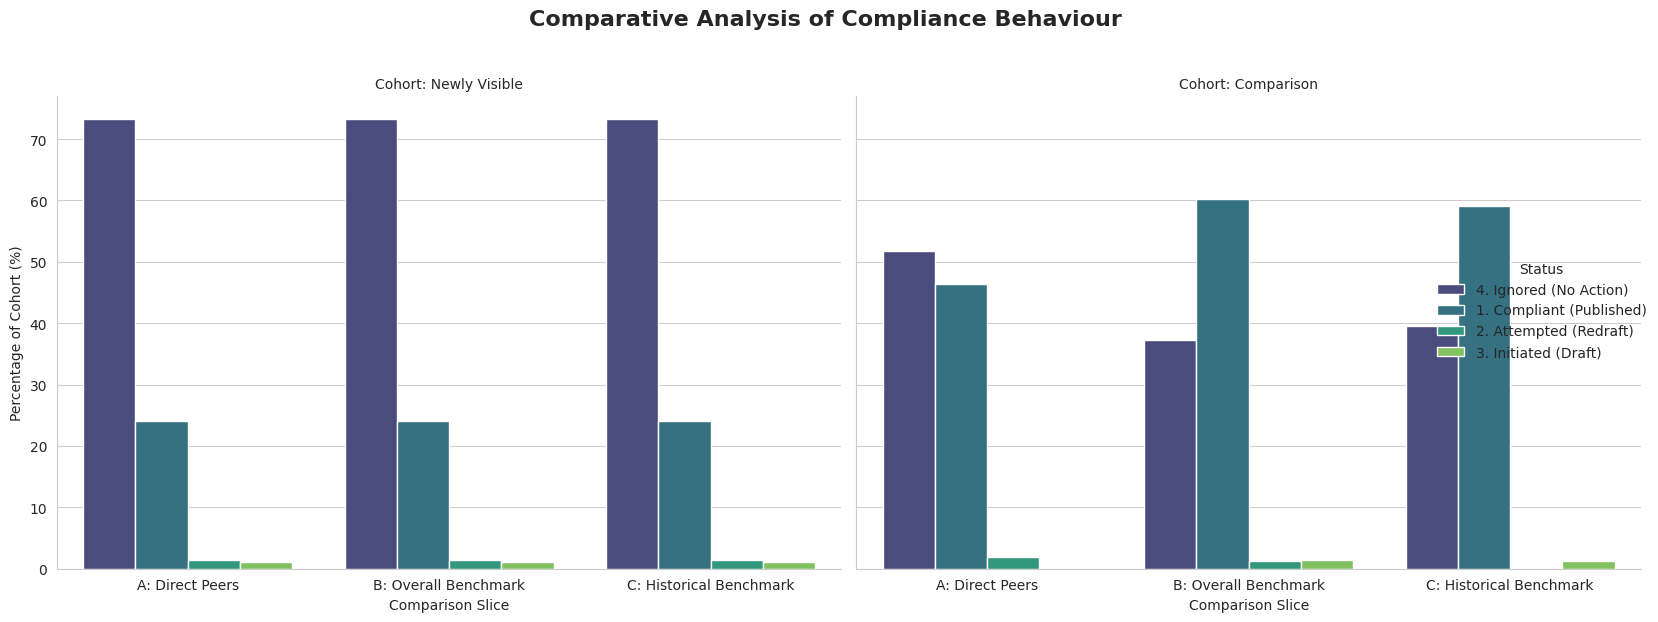


  PROJECT COMPLETE


In [2]:
# ==============================================================================
# Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
import numpy as np
import os
import re
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Step 0: Setup and Loading Foundational Datasets ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'

# Define paths to our key files
master_file_path = os.path.join(DRIVE_PATH, 'master_compliance_file.parquet')
action_log_path = os.path.join(DRIVE_PATH, 'annual_reporting_log.csv')
tax_data_path_22_23 = os.path.join(DRIVE_PATH, 'CorporateTaxTransparency', '2022-23-corporate-report-of-entity-tax-information.xlsx')

try:
    master_df = pd.read_parquet(master_file_path)
    action_log_df = pd.read_csv(action_log_path, dtype={'ABN': str})
    tax_df_22_23 = pd.read_excel(tax_data_path_22_23, sheet_name='Income tax details', header=0)
    print("-> SUCCESS: Successfully loaded all necessary foundational files.")
except FileNotFoundError as e:
    raise FileNotFoundError(f"CRITICAL ERROR: A required file was not found. Details: {e}")

# Set plotting style
sns.set_style("whitegrid")
print("--- Setup Complete ---\n")


# ==============================================================================
# Phase 1: Apply the 4-Part Behavioral Classification Universally
# ==============================================================================
print("#"*80)
print("  Phase 1: Applying the 4-Part Behavioral Classification to All Entities")
print("#"*80 + "\n")

# --- 1A: Prepare the Data ---
master_df = pd.merge(master_df, action_log_df, on='ABN', how='left')
obligation_cols = sorted([col for col in master_df.columns if re.match(r'\d{4}-\d{2}', str(col))])
for col in obligation_cols:
    master_df[col] = master_df[col].fillna(False).astype(bool)

# --- 1B: Define the Classification Function ---
def classify_behaviour(action_taken):
    if pd.isna(action_taken): return "4. Ignored (No Action)"
    elif action_taken == 'Published': return "1. Compliant (Published)"
    elif action_taken == 'Redraft': return "2. Attempted (Redraft)"
    elif action_taken == 'Draft': return "3. Initiated (Draft)"
    else: return "Unknown"

# --- 1C: Apply Classification for Every Year ---
print("-> Applying classification logic for each year...")
for obligation_year_str in obligation_cols:
    action_year_num = int(obligation_year_str[:4]) + 2
    action_col = f"Action_{action_year_num}"
    status_col = f"Status_{obligation_year_str}"

    if action_col not in master_df.columns: master_df[action_col] = np.nan

    def determine_status_for_year(row):
        if row[obligation_year_str]: # Only classify if obligated
            return classify_behaviour(row[action_col])
        else:
            return 'Not Obligated'
    master_df[status_col] = master_df.apply(determine_status_for_year, axis=1)
print("-> Universal classification complete.")
print("--- Phase 1 Complete ---\n")


# ==============================================================================
# Phase 2: Define Cohorts and Perform Comparative Analysis
# ==============================================================================
print("#"*80)
print("  Phase 2: Performing the Final Comparative Analysis")
print("#"*80 + "\n")

all_comparison_results = []

# --- 2A: Profile the "Newly Visible Segment" ---
newly_visible_mask = (master_df['ASIC_Type'] == 'APTY') & (master_df['2021-22'] == False) & (master_df['2022-23'] == True)
newly_visible_df = master_df[newly_visible_mask]
nvs_breakdown = newly_visible_df['Status_2022-23'].value_counts(normalize=True).mul(100).to_dict()
print("--- Profile of Newly Visible Segment (2022-23 Obligation) ---")
print(pd.Series(nvs_breakdown).round(2))

# --- 2B: Define and Analyze the Comparison Slices ---
# Slice A: Direct Peers
tax_df_22_23['ABN'] = tax_df_22_23['ABN'].astype(str).str.replace(r'\.0$', '', regex=True).str.zfill(11)
master_df_with_income = pd.merge(master_df, tax_df_22_23[['ABN', 'Total income $']].rename(columns={'Total income $': 'TotalIncome'}), on='ABN', how='left')
slice_A_mask = (master_df_with_income['ASIC_Type'] != 'APTY') & (master_df_with_income['2022-23'] == True) & (master_df_with_income['TotalIncome'] >= 100_000_000) & (master_df_with_income['TotalIncome'] < 200_000_000)
slice_A_breakdown = master_df_with_income[slice_A_mask]['Status_2022-23'].value_counts(normalize=True).mul(100).to_dict()

# Slice B: Overall Corporate Benchmark
slice_B_mask = (master_df['ASIC_Type'] != 'APTY') & (master_df['2022-23'] == True)
slice_B_breakdown = master_df[slice_B_mask]['Status_2022-23'].value_counts(normalize=True).mul(100).to_dict()

# Slice C: Historical Benchmark
slice_C_mask = (master_df['2018-19'] == True) & (master_df['2017-18'] == False)
slice_C_breakdown = master_df[slice_C_mask]['Status_2018-19'].value_counts(normalize=True).mul(100).to_dict()

# --- 2C: Collate all results for plotting ---
for status in nvs_breakdown: all_comparison_results.append({'Comparison': 'A: Direct Peers', 'Status': status, 'Percentage': nvs_breakdown.get(status, 0), 'Cohort': 'Newly Visible'})
for status in slice_A_breakdown: all_comparison_results.append({'Comparison': 'A: Direct Peers', 'Status': status, 'Percentage': slice_A_breakdown.get(status, 0), 'Cohort': 'Comparison'})
for status in nvs_breakdown: all_comparison_results.append({'Comparison': 'B: Overall Benchmark', 'Status': status, 'Percentage': nvs_breakdown.get(status, 0), 'Cohort': 'Newly Visible'})
for status in slice_B_breakdown: all_comparison_results.append({'Comparison': 'B: Overall Benchmark', 'Status': status, 'Percentage': slice_B_breakdown.get(status, 0), 'Cohort': 'Comparison'})
for status in nvs_breakdown: all_comparison_results.append({'Comparison': 'C: Historical Benchmark', 'Status': status, 'Percentage': nvs_breakdown.get(status, 0), 'Cohort': 'Newly Visible'})
for status in slice_C_breakdown: all_comparison_results.append({'Comparison': 'C: Historical Benchmark', 'Status': status, 'Percentage': slice_C_breakdown.get(status, 0), 'Cohort': 'Comparison'})

final_summary_df = pd.DataFrame(all_comparison_results)
print("--- Phase 2 Complete ---\n")

# ==============================================================================
# Phase 3: Final Reporting and Visualization
# ==============================================================================
print("#"*80)
print("  Phase 3: Final Comparative Analysis Report")
print("#"*80 + "\n")

# --- Print the final summary table ---
summary_pivot = final_summary_df.pivot_table(index=['Comparison', 'Cohort'], columns='Status', values='Percentage', fill_value=0).round(2)
print("--- Conclusive Comparison of Compliance Behaviour (%) ---")
print(summary_pivot)

# --- Generate the final chart ---
g = sns.catplot(
    data=final_summary_df,
    kind='bar',
    x='Comparison',
    y='Percentage',
    hue='Status',
    col='Cohort',
    height=6,
    aspect=1.2,
    palette='viridis'
)
g.fig.suptitle('Comparative Analysis of Compliance Behaviour', y=1.03, fontsize=16, fontweight='bold')
g.set_axis_labels("Comparison Slice", "Percentage of Cohort (%)")
g.set_titles("Cohort: {col_name}")
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("  PROJECT COMPLETE")
print("="*80)

#

# Multi-faceted Analysis of "Newly Visible Segment"

In [1]:
# ==============================================================================
# @title SCRIPT 1: THE ANALYSIS AND SAVING ENGINE
# ==============================================================================
import pandas as pd
import numpy as np
import os
import re
from google.colab import drive

print("--- Step 0: Setup and Loading the Master Compliance File ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'
master_file_path = os.path.join(DRIVE_PATH, 'master_compliance_file.parquet')
tax_data_path = os.path.join(DRIVE_PATH, 'CorporateTaxTransparency', '2022-23-corporate-report-of-entity-tax-information.xlsx')
action_log_path = os.path.join(DRIVE_PATH, 'annual_reporting_log.csv')
summary_output_path = os.path.join(DRIVE_PATH, 'comparative_analysis_summary.csv')

try:
    master_df = pd.read_parquet(master_file_path)
    action_log_df = pd.read_csv(action_log_path, dtype={'ABN': str})
    print("-> SUCCESS: Successfully loaded the necessary foundational files.")
except FileNotFoundError as e:
    raise FileNotFoundError(f"CRITICAL ERROR: A required file was not found. Details: {e}")
print("--- Setup Complete ---\n")


# ==============================================================================
# Phase 1: Data Preparation and Cohort Definition
# ==============================================================================
print("#"*80)
print("  Phase 1: Preparing Data and Defining Cohorts")
print("#"*80 + "\n")
obligation_cols = [col for col in master_df.columns if re.match(r'\d{4}-\d{2}', str(col))]
master_df[obligation_cols] = master_df[obligation_cols].astype(bool)
newly_visible_mask = (master_df['ASIC_Type'] == 'APTY') & (master_df['2021-22'] == False) & (master_df['2022-23'] == True)
newly_visible_df = master_df[newly_visible_mask]
newly_visible_compliance_rate = (newly_visible_df['ComplianceStatus'] == 'Compliant').mean() * 100
print(f"-> Defined 'Newly Visible Segment' ({len(newly_visible_df)} entities) with a compliance rate of {newly_visible_compliance_rate:.2f}%")


# ==============================================================================
# Phase 2: Execute the Four Comparative Analyses (Memory-Efficient)
# ==============================================================================
print("\n" + "#"*80)
print("  Phase 2: Executing the Four Comparative Analyses")
print("#"*80 + "\n")
comparison_results = []

def build_income_lookup(path, abn_set):
    # [Helper function remains the same]
    income_dict = {}
    df = pd.read_excel(path, sheet_name='Income tax details', header=0, usecols=['ABN', 'Total income $'])
    df.columns = ['ABN', 'TotalIncome']
    df['ABN'] = df['ABN'].astype(str).str.replace(r'\.0$', '', regex=True).str.zfill(11)
    df.dropna(subset=['ABN', 'TotalIncome'], inplace=True)
    df = df[df['ABN'].isin(abn_set)]
    for index, row in df.iterrows(): income_dict[row['ABN']] = row['TotalIncome']
    return income_dict

# --- Slice 2 ---
print("--- Analyzing Slice 2 ---")
slice_2_cohort = master_df[(master_df['ASIC_Type'] != 'APTY') & (master_df['2022-23'] == True)].copy()
income_lookup_s2 = build_income_lookup(tax_data_path, set(slice_2_cohort['ABN']))
slice_2_cohort['TotalIncome'] = slice_2_cohort['ABN'].map(income_lookup_s2)
slice_2_final_df = slice_2_cohort[(slice_2_cohort['TotalIncome'] >= 100_000_000) & (slice_2_cohort['TotalIncome'] < 200_000_000)]
slice_2_compliance_rate = (slice_2_final_df['ComplianceStatus'] == 'Compliant').mean() * 100
comparison_results.append({'Comparison': 'Slice 2: Other Types ($100M-$200M, 2022-23)', 'Cohort': 'Comparison Cohort', 'Rate': slice_2_compliance_rate})

# --- Slice 3 ---
print("--- Analyzing Slice 3 ---")
slice_3_df = master_df[(master_df['ASIC_Type'] != 'APTY') & (master_df['2022-23'] == True)]
slice_3_compliance_rate = (slice_3_df['ComplianceStatus'] == 'Compliant').mean() * 100
comparison_results.append({'Comparison': 'Slice 3: All Other Types (All Revenues, 2022-23)', 'Cohort': 'Comparison Cohort', 'Rate': slice_3_compliance_rate})

# --- Slice 4 ---
print("--- Analyzing Slice 4 ---")
original_cohort_mask = (master_df['2018-19'] == True) & (master_df.get('2017-18', False) == False)
original_cohort_df = master_df[original_cohort_mask]
original_cohort_with_action = pd.merge(original_cohort_df, action_log_df[['ABN', 'Action_2020']], on='ABN', how='left')
slice_4_compliance_rate = (original_cohort_with_action['Action_2020'] == 'Published').mean() * 100
comparison_results.append({'Comparison': "Slice 4: Original Cohort's 'First Year' Compliance", 'Cohort': 'Comparison Cohort', 'Rate': slice_4_compliance_rate})

# Add the Newly Visible Segment's rate for each comparison
for item in comparison_results[:]: # Iterate over a copy
    comparison_results.append({'Comparison': item['Comparison'], 'Cohort': 'Newly Visible Segment', 'Rate': newly_visible_compliance_rate})

# ==============================================================================
# Phase 3: Save the Intermediate Summary Results
# ==============================================================================
print("\n" + "#"*80)
print("  Phase 3: Saving the Final Summary Results")
print("#"*80 + "\n")

final_summary_df = pd.DataFrame(comparison_results)
final_summary_df.to_csv(summary_output_path, index=False)
print(f"-> SUCCESS: The final summary data has been saved to:\n   {summary_output_path}")

print("\n--- ANALYSIS ENGINE COMPLETE ---")
print("You may now proceed with the 'Reporting Engine' script to generate the plots.")

--- Step 0: Setup and Loading the Master Compliance File ---
Mounted at /content/drive
-> SUCCESS: Successfully loaded the necessary foundational files.
--- Setup Complete ---

################################################################################
  Phase 1: Preparing Data and Defining Cohorts
################################################################################

-> Defined 'Newly Visible Segment' (3317 entities) with a compliance rate of 47.21%

################################################################################
  Phase 2: Executing the Four Comparative Analyses
################################################################################

--- Analyzing Slice 2 ---
--- Analyzing Slice 3 ---
--- Analyzing Slice 4 ---

################################################################################
  Phase 3: Saving the Final Summary Results
################################################################################

-> SUCCESS: The final summar

--- Step 0: Setup and Loading the Final Summary Data ---
Mounted at /content/drive
-> SUCCESS: Successfully loaded the final summary data.
--- Setup Complete ---

################################################################################
  Generating the Final Comparative Analysis Chart
################################################################################



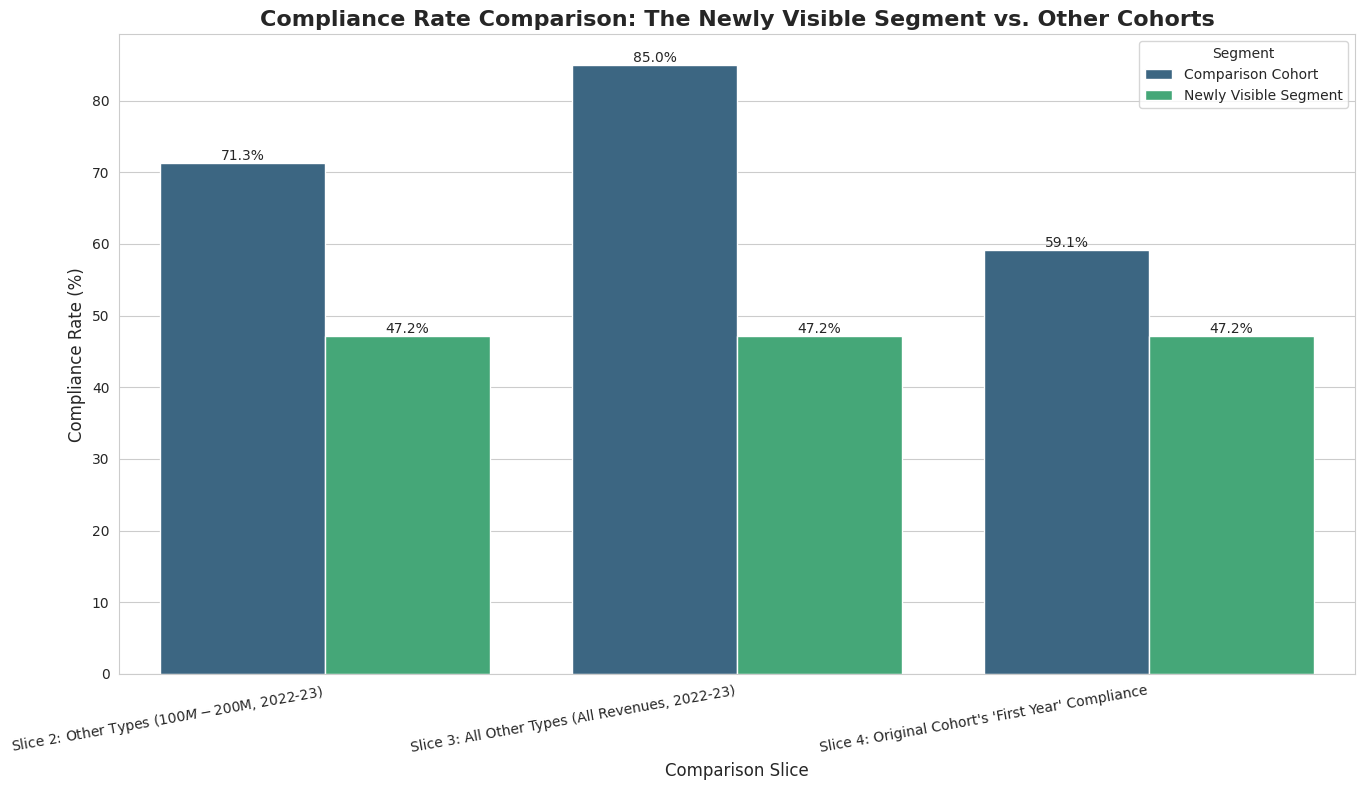


  REPORTING ENGINE COMPLETE


In [2]:
# ==============================================================================
# @title SCRIPT 2: THE REPORTING ENGINE
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os

print("--- Step 0: Setup and Loading the Final Summary Data ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'
summary_input_path = os.path.join(DRIVE_PATH, 'comparative_analysis_summary.csv')

try:
    final_summary_df = pd.read_csv(summary_input_path)
    print("-> SUCCESS: Successfully loaded the final summary data.")
except FileNotFoundError:
    raise FileNotFoundError("CRITICAL ERROR: 'comparative_analysis_summary.csv' not found. "
                          "Please ensure the 'Analysis Engine' script ran successfully.")
print("--- Setup Complete ---\n")


# ==============================================================================
# Step 1: Generate the Final Plot
# ==============================================================================
print("#"*80)
print("  Generating the Final Comparative Analysis Chart")
print("#"*80 + "\n")

# Set plotting style and size
sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))

# Create the bar plot
ax = sns.barplot(data=final_summary_df, x='Comparison', y='Rate', hue='Cohort', palette="viridis")

# Set titles and labels for clarity
plt.title('Compliance Rate Comparison: The Newly Visible Segment vs. Other Cohorts', fontsize=16, fontweight='bold')
plt.xlabel('Comparison Slice', fontsize=12)
plt.ylabel('Compliance Rate (%)', fontsize=12)
plt.xticks(rotation=10, ha='right') # Angled labels for better readability
plt.legend(title='Segment')

# Add data labels to the bars for precision
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

# Ensure the layout is clean
plt.tight_layout()

# Display the final plot
plt.show()

print("\n" + "="*80)
print("  REPORTING ENGINE COMPLETE")
print("="*80)

# Master Build and Analysis Script

In [3]:
# ==============================================================================
# Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
import numpy as np
import os
import re
from google.colab import drive
import warnings

# Suppress warnings for a cleaner final report
warnings.filterwarnings('ignore', category=FutureWarning)

print("--- Step 0: Setup and Google Drive Integration ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'
OUTPUT_PATH = DRIVE_PATH
print(f"Base data directory: {DRIVE_PATH}\n")

# ==============================================================================
# Phase 1: Load the Final, Verified Foundational Datasets
# ==============================================================================
print("#"*80)
print("  Phase 1: Loading the Foundational Datasets")
print("#"*80 + "\n")

try:
    # Load the master file which contains the full list of entities and their obligations
    master_file_path = os.path.join(DRIVE_PATH, 'master_compliance_file.parquet')
    master_df = pd.read_parquet(master_file_path)

    # Load the evidence trail of all actions
    action_log_path = os.path.join(DRIVE_PATH, 'annual_reporting_log.csv')
    action_log_df = pd.read_csv(action_log_path, dtype={'ABN': str})

    print("-> SUCCESS: Successfully loaded the Master Compliance File and the Annual Reporting Log.")

except FileNotFoundError as e:
    raise FileNotFoundError(f"CRITICAL ERROR: A foundational file was not found. Please ensure all previous build steps ran successfully. Details: {e}")
print("--- Phase 1 Complete ---\n")


# ==============================================================================
# Phase 2: Apply the Definitive "Non-Lodger" Classification
# ==============================================================================
print("#"*80)
print("  Phase 2: Applying the Definitive 'Non-Lodger' Classification")
print("#"*80 + "\n")

# Merge the action log to ensure all data is aligned
master_df = pd.merge(master_df, action_log_df, on='ABN', how='left')

# Get the list of obligation years from the master file
obligation_cols = sorted([col for col in master_df.columns if re.match(r'\d{4}-\d{2}', str(col))])

print("-> Applying classification logic for each year...")
for obligation_year_str in obligation_cols:
    # Map the income year (e.g., '2018-19') to the reporting action year (e.g., '2020')
    action_year_num = int(obligation_year_str[:4]) + 2
    action_col = f"Action_{action_year_num}"
    status_col = f"Compliance_Status_{action_year_num}"

    # Ensure action column exists, filling with NaN if not
    if action_col not in master_df.columns:
        master_df[action_col] = np.nan

    def determine_lodger_status(row):
        is_obligated = row[obligation_year_str] == True
        action_taken = row[action_col]

        if is_obligated:
            if action_taken == 'Published':
                return 'Lodger'
            else:
                # Anything else (Draft, Redraft, or NaN) is a Non-Lodger
                return 'Non-Lodger'
        else:
            return 'Not Obligated'

    master_df[status_col] = master_df.apply(determine_lodger_status, axis=1)

print("-> Classification complete.")
print("--- Phase 2 Complete ---\n")


# ==============================================================================
# Phase 3: Generate the Final, Actionable List
# ==============================================================================
print("#"*80)
print("  Phase 3: Generating the Actionable Non-Lodger List")
print("#"*80 + "\n")

# --- 3A: Identify any entity that was a "Non-Lodger" in at least one year ---
status_cols = sorted([col for col in master_df.columns if 'Compliance_Status_' in col])
is_non_lodger_mask = (master_df[status_cols] == 'Non-Lodger').any(axis=1)

actionable_df = master_df[is_non_lodger_mask].copy()
print(f"-> Found {len(actionable_df)} entities that were non-lodgers in at least one year.")

# --- 3B: Format the final spreadsheet ---
final_output_cols = ['ABN', 'Name'] + status_cols
actionable_df = actionable_df[final_output_cols]

# --- 3C: Save the final deliverable ---
actionable_list_path = os.path.join(OUTPUT_PATH, 'actionable_non_lodger_list.csv')
actionable_df.to_csv(actionable_list_path, index=False)
print(f"-> SUCCESS: The final actionable list has been saved to:\n   {actionable_list_path}")


# ==============================================================================
# Final Verification and Project Conclusion
# ==============================================================================
print("\n" + "="*80)
print("  PROJECT COMPLETE: FINAL ACTIONABLE DELIVERABLE CREATED")
print("="*80)
print(f"The final, actionable list of {len(actionable_df)} non-lodging entities is now ready for the engagement team.")
print("\n--- First 10 rows of the final output file ---")
print(actionable_df.head(10).to_string())
print("\n" + "="*80)

--- Step 0: Setup and Google Drive Integration ---
Mounted at /content/drive
Base data directory: /content/drive/MyDrive/ModernSlaveryProject/

################################################################################
  Phase 1: Loading the Foundational Datasets
################################################################################

-> SUCCESS: Successfully loaded the Master Compliance File and the Annual Reporting Log.
--- Phase 1 Complete ---

################################################################################
  Phase 2: Applying the Definitive 'Non-Lodger' Classification
################################################################################

-> Applying classification logic for each year...
-> Classification complete.
--- Phase 2 Complete ---

################################################################################
  Phase 3: Generating the Actionable Non-Lodger List
#####################################################################

# ASIC Banned Person EDA

In [11]:
# ==============================================================================
# Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
import os
from google.colab import drive

print("--- Step 0: Setup and Google Drive Integration ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'

asic_bd_filename = 'bd_per_202509.csv'
asic_bd_file_path = os.path.join(DRIVE_PATH, asic_bd_filename)

if not os.path.exists(asic_bd_file_path):
    raise FileNotFoundError(f"CRITICAL ERROR: The specified ASIC data file was not found: {asic_bd_file_path}")
else:
    print(f"Targeting ASIC data file: {asic_bd_filename}\n")

# ==============================================================================
# Step 1: Focused Diagnostic for the Banned Persons File
# ==============================================================================
print("#"*80)
print("  FINAL DIAGNOSTIC SCRIPT FOR: ASIC Banned Persons Register (Delimiter Check)")
print("#"*80 + "\n")

try:
    print("-> Reading the first 5 lines of the file as raw text...")

    with open(asic_bd_file_path, 'r', errors='ignore') as f:
        for i in range(5):
            line = f.readline()
            print(f"Line {i+1}: {line}")

    print("\n" + "="*80)
    print("  DIAGNOSTIC COMPLETE")
    print("="*80)
    print("\nPlease examine the header line (usually Line 1) in the output above.")
    print("The character separating the column names (e.g., a comma ',', a tab '\\t', or a pipe '|') is the correct delimiter.")

except Exception as e:
    print(f"   CRITICAL ERROR: Could not process the file. Reason: {e}")

--- Step 0: Setup and Google Drive Integration ---
Mounted at /content/drive
Targeting ASIC data file: bd_per_202509.csv

################################################################################
  FINAL DIAGNOSTIC SCRIPT FOR: ASIC Banned Persons Register (Delimiter Check)
################################################################################

-> Reading the first 5 lines of the file as raw text...
Line 1: ﻿REGISTER_NAME,BD_PER_NAME,BD_PER_TYPE,BD_PER_DOC_NUM,BD_PER_START_DT,BD_PER_END_DT,BD_PER_ADD_LOCAL,BD_PER_ADD_STATE,BD_PER_ADD_PCODE,BD_PER_ADD_COUNTRY,BD_PER_COMMENTS

Line 2: "Banned and Disqualified Persons","ABBOTT, BILL","Banned Securities","#004289112","29/03/1994","29/03/1999","TEMPLESTOWE LOWER","VIC","3107","AUSTRALIA","No comment made"

Line 3: "Banned and Disqualified Persons","ADKINS, JOHN WILLIAM","Banned Securities","#015633390","03/08/2001","20/10/2002","BLACK ROCK","VIC","3193","AUSTRALIA","No comment made"

Line 4: "Banned and Disqualified Persons"

--- Step 0: Setup and Google Drive Integration ---
Mounted at /content/drive
Targeting ASIC data file: bd_per_202509.csv
--- Setup Complete ---

################################################################################
  Phase 1: Loading ASIC Banned & Disqualified Persons Data
################################################################################

-> Loading the ASIC dataset...
-> SUCCESS: Successfully loaded the dataset with 6989 rows and 11 columns.
   Detected columns are: ['REGISTER_NAME', 'BD_PER_NAME', 'BD_PER_TYPE', 'BD_PER_DOC_NUM', 'BD_PER_START_DT', 'BD_PER_END_DT', 'BD_PER_ADD_LOCAL', 'BD_PER_ADD_STATE', 'BD_PER_ADD_PCODE', 'BD_PER_ADD_COUNTRY', 'BD_PER_COMMENTS']

--- 1.1: Data Health Check ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6989 entries, 0 to 6988
Columns: 11 entries, REGISTER_NAME to BD_PER_COMMENTS
dtypes: object(11)
memory usage: 600.7+ KB

--- Phase 1 Complete ---

#####################################################################

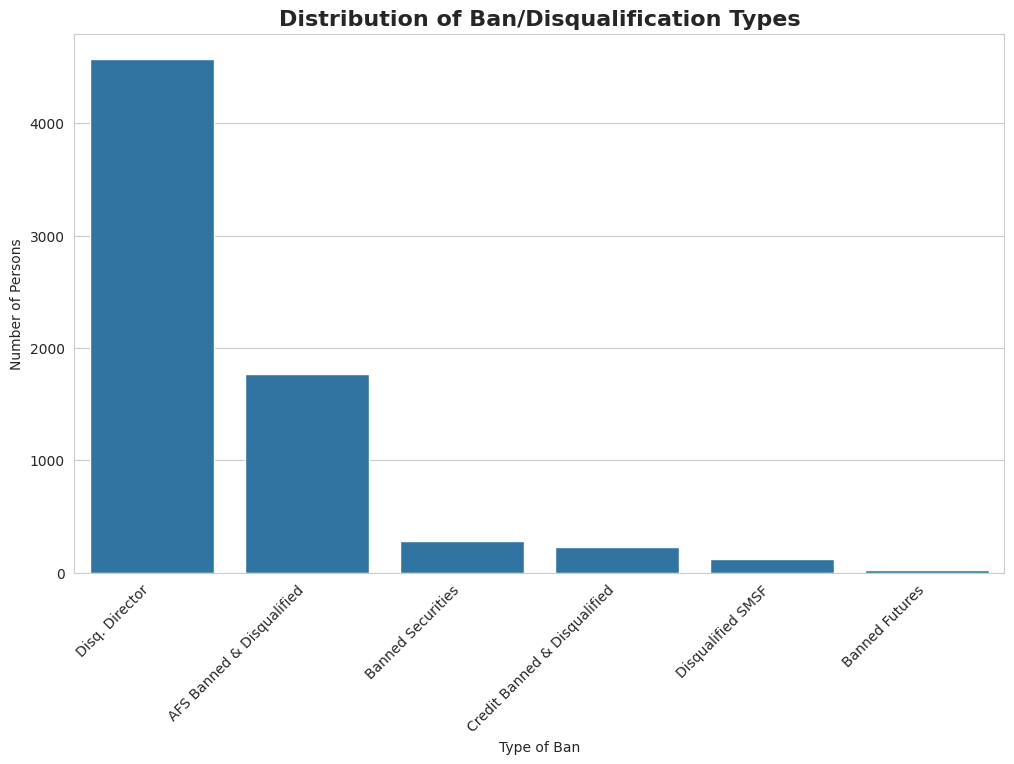

Insight: This shows the number of individuals in each category. Our analysis will focus on the 'Disq. Director' cohort.

--- 2.2: Quality Check of the Person Name Column ---
The 'BD_PER_NAME' column has 0 missing values (0.00%).

Example of name formats:
                  ABBOTT, BILL
          ADKINS, JOHN WILLIAM
           AITKEN, WARREN JOHN
          ANDERSON, GAVIN JOHN
ANSON, BENJAMIN RICHARD EDWARD

Insight: The name column is well-populated and follows the expected 'LASTNAME, GIVEN_NAME' format, making it suitable for parsing and matching.

  ASIC BANNED & DISQUALIFIED PERSONS REGISTER EDA COMPLETE


In [12]:
# ==============================================================================
# Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
import numpy as np
import os
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Step 0: Setup and Google Drive Integration ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'

asic_bd_filename = 'bd_per_202509.csv'
asic_bd_file_path = os.path.join(DRIVE_PATH, asic_bd_filename)

if not os.path.exists(asic_bd_file_path):
    raise FileNotFoundError(f"CRITICAL ERROR: The specified ASIC data file was not found: {asic_bd_file_path}")
else:
    print(f"Targeting ASIC data file: {asic_bd_filename}")

sns.set_style("whitegrid")
print("--- Setup Complete ---\n")


# ==============================================================================
# Phase 1: Load the Data and Perform a Health Check
# ==============================================================================
print("#"*80)
print("  Phase 1: Loading ASIC Banned & Disqualified Persons Data")
print("#"*80 + "\n")

try:
    print(f"-> Loading the ASIC dataset...")
    # --- CRITICAL CORRECTION: Load the data as COMMA-SEPARATED ---
    # The first character of the file can sometimes be a 'BOM' character, which we will handle.
    df_asic_bd = pd.read_csv(asic_bd_file_path, sep=',', encoding='utf-8-sig')

    # Clean the column names of any hidden characters or spaces
    df_asic_bd.columns = df_asic_bd.columns.str.strip()

    print(f"-> SUCCESS: Successfully loaded the dataset with {df_asic_bd.shape[0]} rows and {df_asic_bd.shape[1]} columns.")
    print(f"   Detected columns are: {df_asic_bd.columns.tolist()}")

    # --- Health Check Report ---
    print("\n--- 1.1: Data Health Check ---")
    df_asic_bd.info(verbose=False)

except Exception as e:
    raise IOError(f"Could not process the ASIC data file. Error: {e}")

print("\n--- Phase 1 Complete ---\n")


# ==============================================================================
# Phase 2: Exploratory Data Analysis (EDA) of Key Fields
# ==============================================================================
print("#"*80)
print("  Phase 2: Exploratory Data Analysis of Key Fields")
print("#"*80 + "\n")

# --- 2.1: Analyse Type of Ban ---
print("--- 2.1: Breakdown by Type of Ban/Disqualification ---")
type_col = 'BD_PER_TYPE'
if type_col in df_asic_bd.columns:
    type_counts = df_asic_bd[type_col].value_counts()
    print(type_counts)

    plt.figure(figsize=(12, 7))
    sns.barplot(x=type_counts.index, y=type_counts.values)
    plt.title('Distribution of Ban/Disqualification Types', fontsize=16, fontweight='bold')
    plt.xlabel('Type of Ban'); plt.ylabel('Number of Persons')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    print("Insight: This shows the number of individuals in each category. Our analysis will focus on the 'Disq. Director' cohort.")
else:
    print(f"WARNING: Column '{type_col}' not found.")

# --- 2.2: Assess Name Column Quality ---
print("\n--- 2.2: Quality Check of the Person Name Column ---")
name_col = 'BD_PER_NAME'
if name_col in df_asic_bd.columns:
    name_nulls = df_asic_bd[name_col].isnull().sum()
    print(f"The '{name_col}' column has {name_nulls} missing values ({(name_nulls / len(df_asic_bd)):.2%}).")

    print("\nExample of name formats:")
    print(df_asic_bd[name_col].head().to_string(index=False))

    print("\nInsight: The name column is well-populated and follows the expected 'LASTNAME, GIVEN_NAME' format, making it suitable for parsing and matching.")
else:
    print(f"WARNING: Column '{name_col}' not found.")

print("\n" + "="*80)
print("  ASIC BANNED & DISQUALIFIED PERSONS REGISTER EDA COMPLETE")
print("="*80)

# ASIC Business Names Register EDA

In [8]:
# ==============================================================================
# Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
import os
from google.colab import drive
import warnings

# Suppress openpyxl warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

print("--- Step 0: Setup and Google Drive Integration ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'

# --- Use the exact, specified filename ---
asic_bn_filename = 'BUSINESS_NAMES_202510.csv'
asic_bn_file_path = os.path.join(DRIVE_PATH, asic_bn_filename)
# ---

# Verify that the specified file actually exists
if not os.path.exists(asic_bn_file_path):
    raise FileNotFoundError(f"CRITICAL ERROR: The specified ASIC data file was not found: {asic_bn_file_path}")
else:
    print(f"Targeting ASIC data file: {asic_bn_filename}\n")


# ==============================================================================
# Step 1: Focused Diagnostic for the Business Names File
# ==============================================================================
print("#"*80)
print("  DIAGNOSTIC SCRIPT FOR: ASIC Business Names Register")
print("#"*80 + "\n")

try:
    print(f"-> Loading file: {os.path.basename(asic_bn_file_path)}")
    # Load just the header row using the correct tab separator to inspect the column names
    df_header = pd.read_csv(asic_bn_file_path, sep='\t', nrows=0, lineterminator='\n')

    print(f"-> SUCCESS: Successfully loaded file header. Found {len(df_header.columns)} columns.")
    print("   " + "-"*70)
    print(f"   {'Index':<5} | {'Raw Column Name':<70}")
    print("   " + "-"*70)

    for i, col in enumerate(df_header.columns):
        # Represent the column name exactly as found
        raw_col_name = repr(col).strip("'")
        print(f"   {i:<5} | {raw_col_name:<70}")

    print("   " + "-"*70)

except Exception as e:
    print(f"   CRITICAL ERROR: Could not process the file. Please check it is tab-separated. Reason: {e}")

print("\n" + "="*80)
print("  DIAGNOSTIC COMPLETE")
print("="*80)
print("\nPlease review the output above. This provides the exact column names we must use\n"
      "to build the correct EDA script for the Business Names data.")

--- Step 0: Setup and Google Drive Integration ---
Mounted at /content/drive
Targeting ASIC data file: BUSINESS_NAMES_202510.csv

################################################################################
  DIAGNOSTIC SCRIPT FOR: ASIC Business Names Register
################################################################################

-> Loading file: BUSINESS_NAMES_202510.csv
-> SUCCESS: Successfully loaded file header. Found 8 columns.
   ----------------------------------------------------------------------
   Index | Raw Column Name                                                       
   ----------------------------------------------------------------------
   0     | REGISTER_NAME                                                         
   1     | BN_NAME                                                               
   2     | BN_STATUS                                                             
   3     | BN_REG_DT                                                    

--- Step 0: Setup and Google Drive Integration ---
Mounted at /content/drive
Targeting ASIC data file: BUSINESS_NAMES_202510.csv
--- Setup Complete ---

################################################################################
  Phase 1: Loading ASIC Business Names Data and Performing Health Check
################################################################################

-> Loading the ASIC Business Names dataset...
-> SUCCESS: Successfully loaded the dataset with 3236483 rows and 8 columns.
   Cleaned columns are: ['REGISTER_NAME', 'BN_NAME', 'BN_STATUS', 'BN_REG_DT', 'BN_CANCEL_DT', 'BN_STATE_NUM', 'BN_STATE_OF_REG', 'BN_ABN']

--- 1.1: Data Health Check ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3236483 entries, 0 to 3236482
Columns: 8 entries, REGISTER_NAME to BN_ABN
dtypes: object(8)
memory usage: 197.5+ MB

--- Phase 1 Complete ---

################################################################################
  Phase 2: Verifying Linkage Potential and 

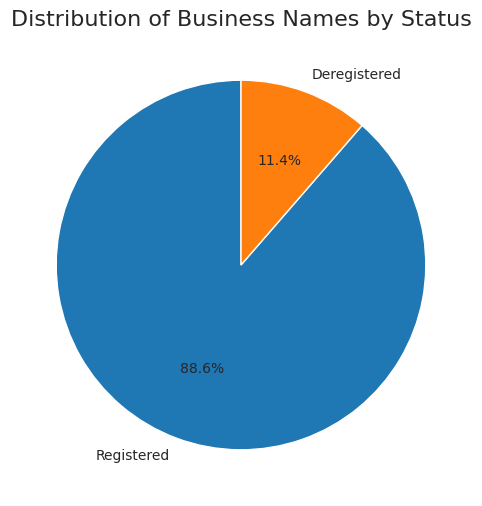

Insight: This shows the proportion of business names that are currently registered ('REGD') versus those that are deregistered ('DRGD').

  ASIC BUSINESS NAMES REGISTER EDA COMPLETE


In [9]:
# ==============================================================================
# Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
import numpy as np
import os
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Step 0: Setup and Google Drive Integration ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'

asic_bn_filename = 'BUSINESS_NAMES_202510.csv'
asic_bn_file_path = os.path.join(DRIVE_PATH, asic_bn_filename)

if not os.path.exists(asic_bn_file_path):
    raise FileNotFoundError(f"CRITICAL ERROR: The specified ASIC data file was not found: {asic_bn_file_path}")
else:
    print(f"Targeting ASIC data file: {asic_bn_filename}")

sns.set_style("whitegrid")
print("--- Setup Complete ---\n")


# ==============================================================================
# Phase 1: Load the Data and Perform a Health Check
# ==============================================================================
print("#"*80)
print("  Phase 1: Loading ASIC Business Names Data and Performing Health Check")
print("#"*80 + "\n")

try:
    print(f"-> Loading the ASIC Business Names dataset...")
    # Load the data as TAB-SEPARATED
    df_asic_bn = pd.read_csv(asic_bn_file_path, sep='\t', low_memory=False, lineterminator='\n')

    # --- CORRECTION: Clean column names immediately after loading ---
    df_asic_bn.columns = df_asic_bn.columns.str.strip() # This will handle the '\r'

    print(f"-> SUCCESS: Successfully loaded the dataset with {df_asic_bn.shape[0]} rows and {df_asic_bn.shape[1]} columns.")
    print(f"   Cleaned columns are: {df_asic_bn.columns.tolist()}")

    # --- Health Check Report ---
    print("\n--- 1.1: Data Health Check ---")
    df_asic_bn.info(verbose=False)

except Exception as e:
    raise IOError(f"Could not process the ASIC Business Names file. Error: {e}")

print("\n--- Phase 1 Complete ---\n")


# ==============================================================================
# Phase 2: Exploratory Data Analysis (EDA) of Key Fields
# ==============================================================================
print("#"*80)
print("  Phase 2: Verifying Linkage Potential and Status")
print("#"*80 + "\n")

# --- 2.1: Check ABN Data Quality ---
# This is the most critical column for linking this data.
print("--- 2.1: Holder ABN Column Quality Check ---")
# --- CORRECTION ---
abn_col = 'BN_ABN'
# ---
if abn_col in df_asic_bn.columns:
    abn_nulls = df_asic_bn[abn_col].isnull().sum()
    print(f"'{abn_col}' column has {abn_nulls} missing values ({(abn_nulls / len(df_asic_bn)):.2%}).")
    print("\nInsight: The ABN is the primary linking key for this dataset to our other universes.")
else:
    print(f"WARNING: '{abn_col}' column not found.")


# --- 2.2: Analyse Business Name Status ---
print("\n--- 2.2: Breakdown by Business Name Status ---")
# --- CORRECTION ---
status_col = 'BN_STATUS'
# ---
if status_col in df_asic_bn.columns:
    status_counts = df_asic_bn[status_col].value_counts()
    print(status_counts)

    plt.figure(figsize=(10, 6))
    status_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Business Names by Status', fontsize=16)
    plt.ylabel('')
    plt.show()
    print("Insight: This shows the proportion of business names that are currently registered ('REGD') versus those that are deregistered ('DRGD').")
else:
    print(f"WARNING: Column '{status_col}' not found.")

print("\n" + "="*80)
print("  ASIC BUSINESS NAMES REGISTER EDA COMPLETE")
print("="*80)

# ASIC Company Register EDA

--- Step 0: Setup and Google Drive Integration ---
Mounted at /content/drive
Targeting ASIC data file: COMPANY_202509.csv
--- Setup Complete ---

################################################################################
  Phase 1: Loading ASIC Data and Performing Health Check
################################################################################

-> Loading the ASIC dataset. This may take a few minutes...
-> SUCCESS: Successfully loaded the ASIC dataset with 4221036 rows and 15 columns.

--- 1.1: Data Health Check ---
Column Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4221036 entries, 0 to 4221035
Columns: 15 entries, Company Name to Current Name Start Date
dtypes: int64(2), object(13)
memory usage: 483.1+ MB

Top 5 Missing Value Counts:
Modified since last report        4207477
Date of Deregistration            4055363
Previous State of Registration    3885315
State Registration number         3885025
Current Name Start Date      

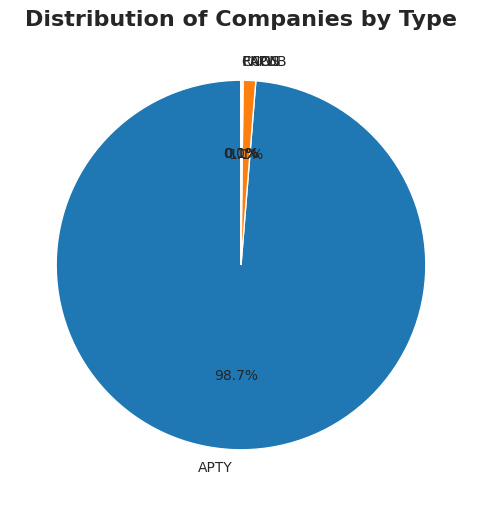

Insight: This shows the proportion of Australian Proprietary ('APTY') vs. Public ('APUB') companies.

--- 2.2: Breakdown by Company Status ---
Status
REGD    3959102
DRGD     183334
SOFF      40857
EXAD      37190
NOAC        493
CNCL         59
DISS          1
Name: count, dtype: int64


/tmp/ipython-input-2705960803.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_counts.index, y=status_counts.values, palette="viridis")


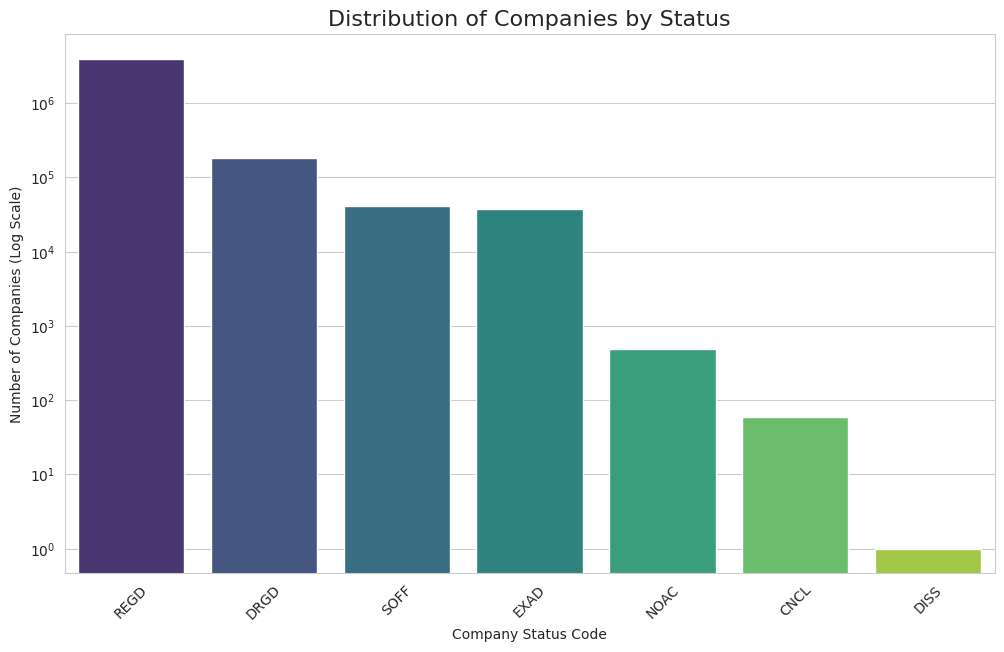

Insight: This shows the breakdown of 'REGD' (Registered) vs. 'DRGD' (Deregistered) and other statuses.

--- Phase 2 Complete ---

################################################################################
  Phase 3: Verifying Linkage Potential
################################################################################

--- 3.1: ABN and ACN Column Quality Check ---
ABN column has 0 missing values (0.00%).
ACN column has 0 missing values (0.00%).

Insight: Both ABN and ACN are well-populated, confirming this dataset can be reliably joined to our other foundational universes.

  ASIC COMPANY REGISTER EDA COMPLETE


In [6]:
# ==============================================================================
# Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
import numpy as np
import os
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Step 0: Setup and Google Drive Integration ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'

# --- CORRECTION: Use the exact, specified filename ---
asic_filename = 'COMPANY_202509.csv'
asic_file_path = os.path.join(DRIVE_PATH, asic_filename)
# ---

# Verify that the specified file actually exists
if not os.path.exists(asic_file_path):
    raise FileNotFoundError(f"CRITICAL ERROR: The specified ASIC data file was not found: {asic_file_path}")
else:
    print(f"Targeting ASIC data file: {asic_filename}")

# Set plotting style
sns.set_style("whitegrid")
print("--- Setup Complete ---\n")


# ==============================================================================
# Phase 1: Load the Data and Perform a Health Check
# ==============================================================================
print("#"*80)
print("  Phase 1: Loading ASIC Data and Performing Health Check")
print("#"*80 + "\n")

try:
    print(f"-> Loading the ASIC dataset. This may take a few minutes...")
    # --- CRITICAL STEP: Load the data as TAB-SEPARATED ---
    df_asic = pd.read_csv(asic_file_path, sep='\t', low_memory=False)

    print(f"-> SUCCESS: Successfully loaded the ASIC dataset with {df_asic.shape[0]} rows and {df_asic.shape[1]} columns.")

    # --- Health Check Report ---
    print("\n--- 1.1: Data Health Check ---")
    print("Column Data Types and Non-Null Counts:")
    df_asic.info(verbose=False)

    print("\nTop 5 Missing Value Counts:")
    missing_values = df_asic.isnull().sum().sort_values(ascending=False)
    print(missing_values.head(5))

except Exception as e:
    raise IOError(f"Could not process the ASIC data file. Please check it is tab-separated. Error: {e}")

print("\n--- Phase 1 Complete ---\n")


# ==============================================================================
# Phase 2: Exploratory Data Analysis (EDA) of Key Fields
# ==============================================================================
print("#"*80)
print("  Phase 2: Exploratory Data Analysis of Key Fields")
print("#"*80 + "\n")

# --- 2.1: Analyse Company Type ---
print("--- 2.1: Breakdown by Company Type ---")
type_col = 'Type'
if type_col in df_asic.columns:
    type_counts = df_asic[type_col].value_counts()
    print(type_counts)

    plt.figure(figsize=(10, 6))
    type_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Companies by Type', fontsize=16, fontweight='bold')
    plt.ylabel('')
    plt.show()
    print("Insight: This shows the proportion of Australian Proprietary ('APTY') vs. Public ('APUB') companies.")
else:
    print(f"WARNING: Column '{type_col}' not found.")

# --- 2.2: Analyse Company Status ---
print("\n--- 2.2: Breakdown by Company Status ---")
status_col = 'Status'
if status_col in df_asic.columns:
    status_counts = df_asic[status_col].value_counts()
    print(status_counts)

    plt.figure(figsize=(12, 7))
    sns.barplot(x=status_counts.index, y=status_counts.values, palette="viridis")
    plt.title('Distribution of Companies by Status', fontsize=16)
    plt.xlabel('Company Status Code')
    plt.ylabel('Number of Companies (Log Scale)')
    plt.yscale('log')
    plt.xticks(rotation=45)
    plt.show()
    print("Insight: This shows the breakdown of 'REGD' (Registered) vs. 'DRGD' (Deregistered) and other statuses.")
else:
    print(f"WARNING: Column '{status_col}' not found.")

print("\n--- Phase 2 Complete ---\n")


# ==============================================================================
# Phase 3: Verify Linkage to Other Datasets
# ==============================================================================
print("#"*80)
print("  Phase 3: Verifying Linkage Potential")
print("#"*80 + "\n")

# --- 3.1: Check ABN and ACN data quality ---
print("--- 3.1: ABN and ACN Column Quality Check ---")

abn_col = 'ABN'
if abn_col in df_asic.columns:
    abn_nulls = df_asic[abn_col].isnull().sum()
    print(f"ABN column has {abn_nulls} missing values ({(abn_nulls / len(df_asic)):.2%}).")
else:
    print("WARNING: ABN column not found.")

acn_col = 'ACN'
if acn_col in df_asic.columns:
    acn_nulls = df_asic[acn_col].isnull().sum()
    print(f"ACN column has {acn_nulls} missing values ({(acn_nulls / len(df_asic)):.2%}).")
else:
    print("WARNING: ACN column not found.")

print("\nInsight: Both ABN and ACN are well-populated, confirming this dataset can be reliably joined to our other foundational universes.")

print("\n" + "="*80)
print("  ASIC COMPANY REGISTER EDA COMPLETE")
print("="*80)

# ACNC EDA Script

In [2]:
# ==============================================================================
# Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
import os
from google.colab import drive
import glob

print("--- Step 0: Setup and Google Drive Integration ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'

# Use glob to find the ACNC file, making the script robust to filename changes
try:
    acnc_file_path = glob.glob(os.path.join(DRIVE_PATH, '*acnc-registered-charities*.csv'))[0]
    print(f"Found ACNC data file: {os.path.basename(acnc_file_path)}\n")
except IndexError:
    raise FileNotFoundError(f"CRITICAL ERROR: No ACNC data file (e.g., 'acnc-registered-charities.csv') was found in {DRIVE_PATH}")

# ==============================================================================
# Step 1: Focused Diagnostic for the ACNC File
# ==============================================================================
print("#"*80)
print("  DIAGNOSTIC SCRIPT FOR: ACNC Registered Charities File")
print("#"*80 + "\n")

try:
    # Load just the header row to inspect the column names
    df_header = pd.read_csv(acnc_file_path, nrows=0)

    print(f"-> SUCCESS: Successfully loaded file. Found {len(df_header.columns)} columns.")
    print("   " + "-"*70)
    print(f"   {'Index':<5} | {'Raw Column Name':<70}")
    print("   " + "-"*70)

    for i, col in enumerate(df_header.columns):
        # Represent the column name exactly as found
        raw_col_name = repr(col).strip("'")
        print(f"   {i:<5} | {raw_col_name:<70}")

    print("   " + "-"*70)

except Exception as e:
    print(f"   CRITICAL ERROR: Could not process the file. Reason: {e}")

print("\n" + "="*80)
print("  DIAGNOSTIC COMPLETE")
print("="*80)
print("\nPlease review the output above. This provides the exact column names we must use\n"
      "to build the correct EDA script for the ACNC data.")

--- Step 0: Setup and Google Drive Integration ---
Mounted at /content/drive
Found ACNC data file: acnc-registered-charities.csv

################################################################################
  DIAGNOSTIC SCRIPT FOR: ACNC Registered Charities File
################################################################################

-> SUCCESS: Successfully loaded file. Found 69 columns.
   ----------------------------------------------------------------------
   Index | Raw Column Name                                                       
   ----------------------------------------------------------------------
   0     | ABN                                                                   
   1     | Charity_Legal_Name                                                    
   2     | Other_Organisation_Names                                              
   3     | Address_Type                                                          
   4     | Address_Line_1            

--- Step 0: Setup and Google Drive Integration ---
Mounted at /content/drive
Found ACNC data file: acnc-registered-charities.csv
--- Setup Complete ---

################################################################################
  Phase 1: Loading ACNC Data and Performing Health Check
################################################################################

-> SUCCESS: Successfully loaded the ACNC dataset with 64072 rows and 69 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64072 entries, 0 to 64071
Columns: 69 entries, ABN to other_gender_identities
dtypes: float64(1), int64(1), object(67)
memory usage: 33.7+ MB

--- Phase 1 Complete ---

################################################################################
  Phase 2: Exploratory Data Analysis of Key Fields
################################################################################

--- 2.1: Breakdown by Charity Size ---
Charity_Size
Small     41367
Medium     8889
Large      6166
Name: count, 

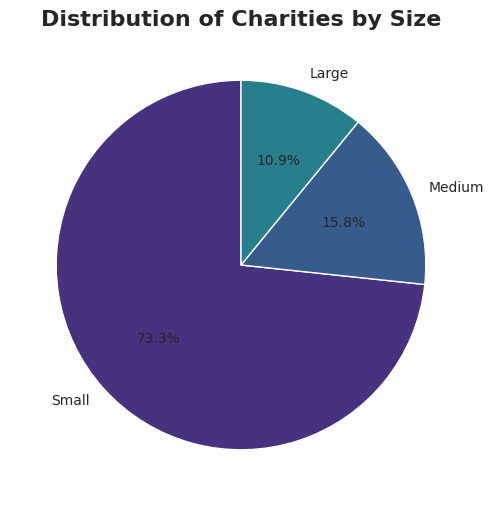


--- 2.2: Breakdown by Financial Year End ---
Top 5 most common Financial Year End dates:
Financial_Year_End
30-Jun    43496
31-Dec    16424
30-Sep     1041
31-Aug      851
31-Mar      565
Name: count, dtype: int64


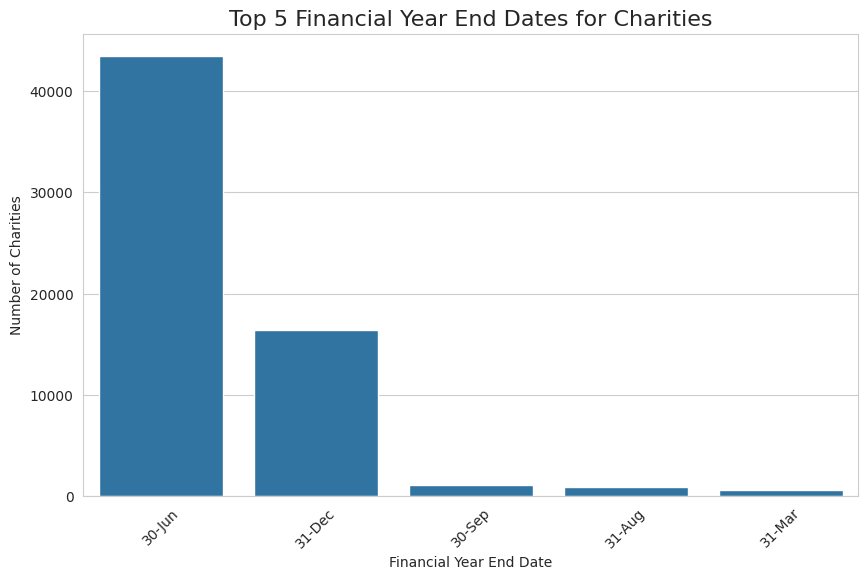


--- 2.3: Charity Registrations Over Time ---


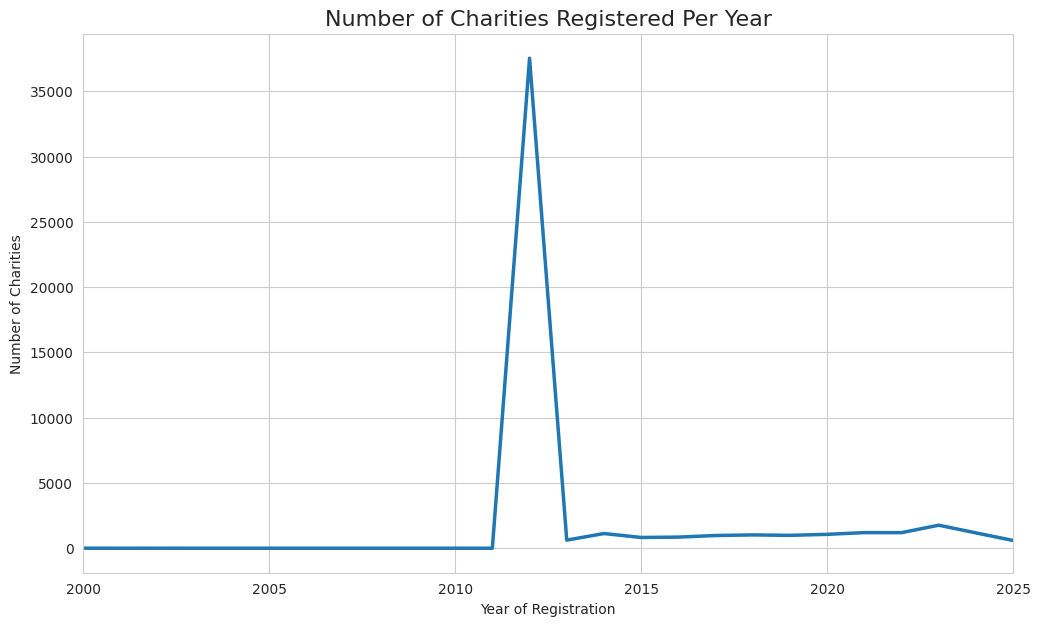


--- Phase 2 Complete ---

################################################################################
  Phase 3: Identifying Potentially Obligated Charities
################################################################################

--- 3.1: Identifying 'Large' Charities as a Proxy for Obligation ---
The dataset contains 6166 charities classified as 'Large' by the ACNC.

NOTE: The ACNC's definition of 'Large' (revenue > $1M or >$3M) is a useful starting point, but the Modern Slavery Act's threshold is a flat $100M.
This number is an upper-bound estimate. The actual number of obligated charities will be a small subset of this group.

  ACNC EXPLORATORY DATA ANALYSIS COMPLETE


In [4]:
# ==============================================================================
# Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
import numpy as np
import os
from google.colab import drive
import glob
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Step 0: Setup and Google Drive Integration ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'

try:
    acnc_file_path = glob.glob(os.path.join(DRIVE_PATH, '*acnc-registered-charities*.csv'))[0]
    print(f"Found ACNC data file: {os.path.basename(acnc_file_path)}")
except IndexError:
    raise FileNotFoundError(f"CRITICAL ERROR: No ACNC data file found in {DRIVE_PATH}")

sns.set_style("whitegrid")
print("--- Setup Complete ---\n")


# ==============================================================================
# Phase 1: Load the Data and Perform a Health Check
# ==============================================================================
print("#"*80)
print("  Phase 1: Loading ACNC Data and Performing Health Check")
print("#"*80 + "\n")

try:
    df_acnc = pd.read_csv(acnc_file_path, low_memory=False)
    print(f"-> SUCCESS: Successfully loaded the ACNC dataset with {df_acnc.shape[0]} rows and {df_acnc.shape[1]} columns.")
    df_acnc.info(verbose=False)
except Exception as e:
    raise IOError(f"Could not process the ACNC CSV file. Error: {e}")
print("\n--- Phase 1 Complete ---\n")


# ==============================================================================
# Phase 2: Exploratory Data Analysis (EDA) - with CORRECTED Column Names
# ==============================================================================
print("#"*80)
print("  Phase 2: Exploratory Data Analysis of Key Fields")
print("#"*80 + "\n")

# --- 2.1: Analyse Charity Size ---
print("--- 2.1: Breakdown by Charity Size ---")
# --- CORRECTION ---
size_col = 'Charity_Size'
# ---
if size_col in df_acnc.columns:
    size_counts = df_acnc[size_col].value_counts()
    print(size_counts)

    plt.figure(figsize=(10, 6))
    size_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette("viridis"))
    plt.title('Distribution of Charities by Size', fontsize=16, fontweight='bold')
    plt.ylabel('')
    plt.show()
else:
    print(f"WARNING: Column '{size_col}' not found.")

# --- 2.2: Analyse Financial Year End ---
print("\n--- 2.2: Breakdown by Financial Year End ---")
# --- CORRECTION ---
fy_col = 'Financial_Year_End'
# ---
if fy_col in df_acnc.columns:
    fy_counts = df_acnc[fy_col].value_counts().head(5)
    print("Top 5 most common Financial Year End dates:")
    print(fy_counts)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=fy_counts.index, y=fy_counts.values)
    plt.title('Top 5 Financial Year End Dates for Charities', fontsize=16)
    plt.xlabel('Financial Year End Date'); plt.ylabel('Number of Charities'); plt.xticks(rotation=45)
    plt.show()
else:
    print(f"WARNING: Column '{fy_col}' not found.")

# --- 2.3: Analyse Registration Date ---
print("\n--- 2.3: Charity Registrations Over Time ---")
# --- CORRECTION ---
reg_date_col = 'Registration_Date'
# ---
if reg_date_col in df_acnc.columns:
    df_acnc[reg_date_col] = pd.to_datetime(df_acnc[reg_date_col], errors='coerce')
    registrations_by_year = df_acnc.set_index(reg_date_col).resample('YE').size()

    plt.figure(figsize=(12, 7))
    registrations_by_year.plot(linewidth=2.5)
    plt.title('Number of Charities Registered Per Year', fontsize=16)
    plt.xlabel('Year of Registration'); plt.ylabel('Number of Charities')
    plt.show()
else:
    print(f"WARNING: Column '{reg_date_col}' not found.")
print("\n--- Phase 2 Complete ---\n")


# ==============================================================================
# Phase 3: Identify and Quantify the Target Cohort
# ==============================================================================
print("#"*80)
print("  Phase 3: Identifying Potentially Obligated Charities")
print("#"*80 + "\n")

print("--- 3.1: Identifying 'Large' Charities as a Proxy for Obligation ---")
if size_col in df_acnc.columns:
    large_charities_df = df_acnc[df_acnc[size_col] == 'Large']
    num_large_charities = len(large_charities_df)

    print(f"The dataset contains {num_large_charities} charities classified as 'Large' by the ACNC.")
    print("\nNOTE: The ACNC's definition of 'Large' (revenue > $1M or >$3M) is a useful starting point, but the Modern Slavery Act's threshold is a flat $100M.")
    print("This number is an upper-bound estimate. The actual number of obligated charities will be a small subset of this group.")
else:
    print(f"WARNING: Could not perform analysis as column '{size_col}' was not found.")

print("\n" + "="*80)
print("  ACNC EXPLORATORY DATA ANALYSIS COMPLETE")
print("="*80)

# File and Column Inspector

In [13]:
# ==============================================================================
# Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
import os
from google.colab import drive
import glob
import warnings

# Suppress openpyxl warnings which can be noisy
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

print("--- Step 0: Setup and Google Drive Integration ---")
drive.mount('/content/drive', force_remount=True)
BASE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/TaxationStatistics/2018-19/'
print(f"Targeting folder: {BASE_PATH}\n")

# ==============================================================================
# Step 1: List all Excel files in the target folder
# ==============================================================================
print("--- Step 1: Identifying all Excel files in the folder ---")

excel_files = glob.glob(os.path.join(BASE_PATH, '*.xlsx'))

if not excel_files:
    print("CRITICAL ERROR: No '.xlsx' files were found in the target directory.")
    print("Please ensure the downloaded ATO files are in the correct folder.")
else:
    print(f"Found {len(excel_files)} Excel file(s):")
    for f_path in sorted(excel_files):
        print(f"  - {os.path.basename(f_path)}")

# ==============================================================================
# Step 2: Inspect each file methodically in an EDA fashion
# ==============================================================================
print("\n--- Step 2: Inspecting the contents of each file ---")

for file_path in sorted(excel_files):
    filename = os.path.basename(file_path)
    print("\n" + "="*80)
    print(f"  INSPECTING FILE: {filename}")
    print("="*80)

    try:
        xls = pd.ExcelFile(file_path)
        sheet_names = xls.sheet_names
        print(f"\n  Found {len(sheet_names)} worksheet(s) (tabs): {sheet_names}")

        for sheet_name in sheet_names:
            print(f"\n  --- Analyzing Sheet: '{sheet_name}' ---")
            try:
                # Read top 20 rows to find header, without making assumptions
                preview_df = pd.read_excel(file_path, sheet_name=sheet_name, header=None, nrows=20)

                header_row_index = -1
                for i, row in preview_df.iterrows():
                    # A plausible header has more than 2 non-empty cells
                    if row.notna().sum() > 2:
                        header_row_index = i
                        break

                if header_row_index != -1:
                    # Now load the sheet properly using the detected header row
                    df = pd.read_excel(file_path, sheet_name=sheet_name, header=header_row_index)
                    print(f"    SUCCESS: Detected header on row {header_row_index + 1}. Found {len(df.columns)} columns.")
                    print("    " + "-"*70)
                    print(f"    {'Index':<5} | {'Raw Column Name':<70}")
                    print("    " + "-"*70)
                    for i, col in enumerate(df.columns):
                        # Represent newline characters visibly as '\n' for clarity
                        raw_col_name = repr(col)
                        print(f"    {i:<5} | {raw_col_name:<70}")
                    print("    " + "-"*70)

                else:
                    print("    INFO: Could not automatically detect a header row in the first 20 rows.")

            except Exception as e:
                print(f"    ERROR: Could not read or analyze sheet '{sheet_name}'. Reason: {e}")

    except Exception as e:
        print(f"  ERROR: Could not open or process the file. Reason: {e}")

print("\n" + "="*80)
print("  INSPECTION COMPLETE")
print("="*80)
print("\nPlease review the detailed output above. This provides the exact index, sheet names, and raw column names needed to build the final, correct extraction script.")

--- Step 0: Setup and Google Drive Integration ---
Mounted at /content/drive
Targeting folder: /content/drive/MyDrive/ModernSlaveryProject/TaxationStatistics/2018-19/

--- Step 1: Identifying all Excel files in the folder ---
Found 4 Excel file(s):
  - ts19company07_public.xlsx
  - ts19fund04_public.xlsx
  - ts19partnerships04_public.xlsx
  - ts19trusts05_public.xlsx

--- Step 2: Inspecting the contents of each file ---

  INSPECTING FILE: ts19company07_public.xlsx

  Found 3 worksheet(s) (tabs): ['Notes', 'Table 7A', 'Table 7B']

  --- Analyzing Sheet: 'Notes' ---
    INFO: Could not automatically detect a header row in the first 20 rows.

  --- Analyzing Sheet: 'Table 7A' ---
    SUCCESS: Detected header on row 2. Found 209 columns.
    ----------------------------------------------------------------------
    Index | Raw Column Name                                                       
    ----------------------------------------------------------------------
    0     | 'Taxable s

# Diagnostic Script for the Companies File

In [5]:
# ==============================================================================
# Step 0: Setup and Imports
# ==============================================================================
import pandas as pd
import os
from google.colab import drive
import warnings

# Suppress openpyxl warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

print("--- Step 0: Setup and Google Drive Integration ---")
drive.mount('/content/drive', force_remount=True)
BASE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/TaxationStatistics/2018-19/'
print(f"Targeting folder: {BASE_PATH}\n")

# ==============================================================================
# Step 1: Focused Diagnostic for the Companies File
# ==============================================================================
print("#"*80)
print("  DIAGNOSTIC SCRIPT FOR: ts19company07_public.xlsx")
print("#"*80 + "\n")

try:
    file_path = os.path.join(BASE_PATH, 'ts19company07_public.xlsx')

    print(f"-> Loading file: {os.path.basename(file_path)}")
    print(f"-> Reading sheet: 'Table 7A' with header on row 2 (index 1)")

    df = pd.read_excel(file_path, sheet_name='Table 7A', header=1)

    # Clean column names for consistency
    df.columns = df.columns.str.replace('\n', ' ').str.strip()
    print("-> Successfully loaded and cleaned column names.")

    # --- THE CRITICAL DIAGNOSTIC STEP ---
    # We will now inspect the unique values within the columns we are trying to filter on.

    # Column 1: Company Type
    company_type_col = 'Company type2'
    print("\n" + "-"*60)
    print(f"  Analyzing unique values in column: '{company_type_col}'")
    print("-"*60)
    if company_type_col in df.columns:
        # Clean the column's data before checking unique values
        df[company_type_col] = df[company_type_col].astype(str).str.strip()
        unique_types = df[company_type_col].unique()
        print("   Found the following unique values:")
        for val in unique_types:
            print(f"   - \"{val}\"")
    else:
        print(f"   ERROR: Column '{company_type_col}' not found!")

    # Column 2: Company Size
    company_size_col = 'Company size, by total income5'
    print("\n" + "-"*60)
    print(f"  Analyzing unique values in column: '{company_size_col}'")
    print("-"*60)
    if company_size_col in df.columns:
        df[company_size_col] = df[company_size_col].astype(str).str.strip()
        unique_sizes = df[company_size_col].unique()
        print("   Found the following unique values:")
        for val in unique_sizes:
            print(f"   - \"{val}\"")
    else:
        print(f"   ERROR: Column '{company_size_col}' not found!")

except FileNotFoundError:
    print(f"   CRITICAL ERROR: File not found: {os.path.basename(file_path)}.")
except Exception as e:
    print(f"   CRITICAL ERROR: Could not process the file. Reason: {e}")

print("\n" + "="*80)
print("  DIAGNOSTIC COMPLETE")
print("="*80)
print("\nPlease compare the unique values printed above with the strings used in our script's filter.")

--- Step 0: Setup and Google Drive Integration ---
Mounted at /content/drive
Targeting folder: /content/drive/MyDrive/ModernSlaveryProject/TaxationStatistics/2018-19/

################################################################################
  DIAGNOSTIC SCRIPT FOR: ts19company07_public.xlsx
################################################################################

-> Loading file: ts19company07_public.xlsx
-> Reading sheet: 'Table 7A' with header on row 2 (index 1)
-> Successfully loaded and cleaned column names.

------------------------------------------------------------
  Analyzing unique values in column: 'Company type2'
------------------------------------------------------------
   Found the following unique values:
   - "a. Private"
   - "b. Public"
   - "c. Other2"
   - "All Types"

------------------------------------------------------------
  Analyzing unique values in column: 'Company size, by total income5'
---------------------------------------------------

# Diagnostic Script for the Trusts File

In [7]:
# ==============================================================================
# Step 0: Setup and Imports
# ==============================================================================
import pandas as pd
import os
from google.colab import drive
import warnings

# Suppress openpyxl warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

print("--- Step 0: Setup and Google Drive Integration ---")
drive.mount('/content/drive', force_remount=True)
BASE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/TaxationStatistics/2018-19/'
print(f"Targeting folder: {BASE_PATH}\n")

# ==============================================================================
# Step 1: Focused Diagnostic for the Trusts File
# ==============================================================================
print("#"*80)
print("  DIAGNOSTIC SCRIPT FOR: ts19trusts05_public.xlsx")
print("#"*80 + "\n")

try:
    file_path = os.path.join(BASE_PATH, 'ts19trusts05_public.xlsx')

    print(f"-> Loading file: {os.path.basename(file_path)}")
    print(f"-> Reading sheet: 'Table 5' with header on row 2 (index 1)")

    # Use the verified parameters from our initial full inspection
    df = pd.read_excel(file_path, sheet_name='Table 5', header=1)

    # Clean column names for consistency
    df.columns = df.columns.str.replace('\n', ' ').str.strip()
    print("-> Successfully loaded and cleaned column names.")

    # --- THE CRITICAL DIAGNOSTIC STEP ---
    # We will now inspect the unique values within the column we need to filter on.

    trust_size_col = 'Trust size3'
    print("\n" + "-"*60)
    print(f"  Analyzing unique values in column: '{trust_size_col}'")
    print("-"*60)

    if trust_size_col in df.columns:
        # Clean the column's data before checking unique values
        df[trust_size_col] = df[trust_size_col].astype(str).str.strip()
        unique_sizes = df[trust_size_col].unique()

        print("   Found the following unique values:")
        for val in unique_sizes:
            print(f"   - \"{val}\"")

        print("\n   -----------------")
        print("   DIAGNOSTIC RESULT")
        print("   -----------------")
        print("   To extract the correct data, our script must filter for a value that is an exact match to one of the strings listed above.")

    else:
        print(f"   ERROR: Column '{trust_size_col}' not found!")

except FileNotFoundError:
    print(f"   CRITICAL ERROR: File not found: {os.path.basename(file_path)}.")
except Exception as e:
    print(f"   CRITICAL ERROR: Could not process the file. Reason: {e}")

print("\n" + "="*80)
print("  DIAGNOSTIC COMPLETE")
print("="*80)

--- Step 0: Setup and Google Drive Integration ---
Mounted at /content/drive
Targeting folder: /content/drive/MyDrive/ModernSlaveryProject/TaxationStatistics/2018-19/

################################################################################
  DIAGNOSTIC SCRIPT FOR: ts19trusts05_public.xlsx
################################################################################

-> Loading file: ts19trusts05_public.xlsx
-> Reading sheet: 'Table 5' with header on row 2 (index 1)
-> Successfully loaded and cleaned column names.

------------------------------------------------------------
  Analyzing unique values in column: 'Trust size3'
------------------------------------------------------------
   Found the following unique values:
   - "a. Nil/Loss"
   - "b. Micro"
   - "c. Small"
   - "d. Medium/Large/Very large"

   -----------------
   DIAGNOSTIC RESULT
   -----------------
   To extract the correct data, our script must filter for a value that is an exact match to one of the stri

# Diagnostic Script for the Partnerships File

In [9]:
# ==============================================================================
# Step 0: Setup and Imports
# ==============================================================================
import pandas as pd
import os
from google.colab import drive
import warnings

# Suppress openpyxl warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

print("--- Step 0: Setup and Google Drive Integration ---")
drive.mount('/content/drive', force_remount=True)
BASE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/TaxationStatistics/2018-19/'
print(f"Targeting folder: {BASE_PATH}\n")

# ==============================================================================
# Step 1: Focused Diagnostic for the Partnerships File
# ==============================================================================
print("#"*80)
print("  DIAGNOSTIC SCRIPT FOR: ts19partnerships04_public.xlsx")
print("#"*80 + "\n")

try:
    file_path = os.path.join(BASE_PATH, 'ts19partnerships04_public.xlsx')

    print(f"-> Loading file: {os.path.basename(file_path)}")
    print(f"-> Reading sheet: 'Table 4' with header on row 2 (index 1)")

    # Use the verified parameters from our initial full inspection
    df = pd.read_excel(file_path, sheet_name='Table 4', header=1)

    # Clean column names for consistency
    df.columns = df.columns.str.replace('\n', ' ').str.strip()
    print("-> Successfully loaded and cleaned column names.")

    # --- THE CRITICAL DIAGNOSTIC STEP ---
    # We will now inspect the unique values within the column we need to filter on.

    partnership_size_col = 'Entity size1'
    print("\n" + "-"*60)
    print(f"  Analyzing unique values in column: '{partnership_size_col}'")
    print("-"*60)

    if partnership_size_col in df.columns:
        # Clean the column's data before checking unique values
        df[partnership_size_col] = df[partnership_size_col].astype(str).str.strip()
        unique_sizes = df[partnership_size_col].unique()

        print("   Found the following unique values:")
        for val in unique_sizes:
            print(f"   - \"{val}\"")

        print("\n   -----------------")
        print("   DIAGNOSTIC RESULT")
        print("   -----------------")
        print("   To extract the correct data, our script must filter for a value that is an exact match to one of the strings listed above.")

    else:
        print(f"   ERROR: Column '{partnership_size_col}' not found!")

except FileNotFoundError:
    print(f"   CRITICAL ERROR: File not found: {os.path.basename(file_path)}.")
except Exception as e:
    print(f"   CRITICAL ERROR: Could not process the file. Reason: {e}")

print("\n" + "="*80)
print("  DIAGNOSTIC COMPLETE")
print("="*80)

--- Step 0: Setup and Google Drive Integration ---
Mounted at /content/drive
Targeting folder: /content/drive/MyDrive/ModernSlaveryProject/TaxationStatistics/2018-19/

################################################################################
  DIAGNOSTIC SCRIPT FOR: ts19partnerships04_public.xlsx
################################################################################

-> Loading file: ts19partnerships04_public.xlsx
-> Reading sheet: 'Table 4' with header on row 2 (index 1)
-> Successfully loaded and cleaned column names.

------------------------------------------------------------
  Analyzing unique values in column: 'Entity size1'
------------------------------------------------------------
   Found the following unique values:
   - "a. Nil/Loss"
   - "b. Micro"
   - "c. Small"
   - "d. Medium/Large/Very large"
   - "Total"

   -----------------
   DIAGNOSTIC RESULT
   -----------------
   To extract the correct data, our script must filter for a value that is an exac

#  Diagnostic Script for the Superannuation Funds File

In [11]:
# ==============================================================================
# Step 0: Setup and Imports
# ==============================================================================
import pandas as pd
import os
from google.colab import drive
import warnings

# Suppress openpyxl warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

print("--- Step 0: Setup and Google Drive Integration ---")
drive.mount('/content/drive', force_remount=True)
BASE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/TaxationStatistics/2018-19/'
print(f"Targeting folder: {BASE_PATH}\n")

# ==============================================================================
# Step 1: Focused Diagnostic for the Superannuation Funds File
# ==============================================================================
print("#"*80)
print("  DIAGNOSTIC SCRIPT FOR: ts19fund04_public.xlsx")
print("#"*80 + "\n")

try:
    file_path = os.path.join(BASE_PATH, 'ts19fund04_public.xlsx')

    print(f"-> Loading file: {os.path.basename(file_path)}")
    print(f"-> Reading sheet: 'Table 4' with header on row 2 (index 1)")

    # Use the verified parameters from our initial full inspection
    df = pd.read_excel(file_path, sheet_name='Table 4', header=1)

    # Clean column names for consistency
    df.columns = df.columns.str.replace('\n', ' ').str.strip()
    print("-> Successfully loaded and cleaned column names.")

    # --- THE CRITICAL DIAGNOSTIC STEP ---
    # We will now inspect the unique values within the column we need to filter on.

    fund_income_col = 'Total income ranges'
    print("\n" + "-"*60)
    print(f"  Analyzing unique values in column: '{fund_income_col}'")
    print("-"*60)

    if fund_income_col in df.columns:
        # We don't need to clean this column as we will be parsing it numerically,
        # but displaying the unique raw values is the goal here.
        unique_sizes = df[fund_income_col].dropna().unique()

        print("   Found the following unique income range values:")
        for val in unique_sizes:
            print(f"   - \"{val}\"")

        print("\n   -----------------")
        print("   DIAGNOSTIC RESULT")
        print("   -----------------")
        print("   This confirms the income brackets are granular. Our 'parse_income_range_to_min' function will be used to filter these numerically.")

    else:
        print(f"   ERROR: Column '{fund_income_col}' not found!")

except FileNotFoundError:
    print(f"   CRITICAL ERROR: File not found: {os.path.basename(file_path)}.")
except Exception as e:
    print(f"   CRITICAL ERROR: Could not process the file. Reason: {e}")

print("\n" + "="*80)
print("  DIAGNOSTIC COMPLETE")
print("="*80)

--- Step 0: Setup and Google Drive Integration ---
Mounted at /content/drive
Targeting folder: /content/drive/MyDrive/ModernSlaveryProject/TaxationStatistics/2018-19/

################################################################################
  DIAGNOSTIC SCRIPT FOR: ts19fund04_public.xlsx
################################################################################

-> Loading file: ts19fund04_public.xlsx
-> Reading sheet: 'Table 4' with header on row 2 (index 1)
-> Successfully loaded and cleaned column names.

------------------------------------------------------------
  Analyzing unique values in column: 'Total income ranges'
------------------------------------------------------------
   Found the following unique income range values:
   - "Loss/nil"
   - "$1 - $99,999"
   - "$100,000 - $499,999"
   - "$500,000 - $999,999"
   - "$1,000,000 - $4,999,999"
   - "$5,000,000 - $9,999,999"
   - "$10,000,000 - $49,999,999"
   - "$50,000,000 - $99,999,999"
   - "$100,000,000 or 

# The Multi-Year Diagnostic "Blueprint" Script

In [16]:
# ==============================================================================
# Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
import os
from google.colab import drive
import glob
import warnings

# Suppress openpyxl warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

print("--- Step 0: Setup and Google Drive Integration ---")
drive.mount('/content/drive', force_remount=True)
BASE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/TaxationStatistics/'
print(f"Base data directory: {BASE_PATH}\n")

# ==============================================================================
# Step 1: Main Loop - Inspect Each Year from 2018 to 2023
# ==============================================================================
print("--- Step 1: Beginning systematic reconnaissance of all year folders ---")

# Define the years we are interested in
for year in range(2018, 2024):
    income_year_str = f"{year}-{str(year+1)[-2:]}"
    year_path = os.path.join(BASE_PATH, income_year_str)

    print("\n" + "#"*80)
    print(f"##  INSPECTING YEAR: {income_year_str}")
    print("#"*80)

    if not os.path.isdir(year_path):
        print(f"  WARNING: Directory not found for year {income_year_str}. Skipping.")
        continue

    # Use glob to find all .xlsx files in the year's subfolder
    excel_files = glob.glob(os.path.join(year_path, '*.xlsx'))

    if not excel_files:
        print(f"  WARNING: No '.xlsx' files found in the directory for {income_year_str}.")
        continue

    print(f"Found {len(excel_files)} Excel file(s):")
    for f_path in sorted(excel_files):
        print(f"  - {os.path.basename(f_path)}")

    # Inspect each file found for the current year
    for file_path in sorted(excel_files):
        filename = os.path.basename(file_path)
        print("\n" + "="*80)
        print(f"  INSPECTING FILE: {filename}")
        print("="*80)

        try:
            xls = pd.ExcelFile(file_path)
            sheet_names = xls.sheet_names
            print(f"\n  Found {len(sheet_names)} worksheet(s) (tabs): {sheet_names}")

            for sheet_name in sheet_names:
                # Skip common metadata sheets to keep the report clean
                if sheet_name.lower() in ['notes', 'information', 'contents']:
                    continue

                print(f"\n  --- Analyzing Data Sheet: '{sheet_name}' ---")
                try:
                    preview_df = pd.read_excel(file_path, sheet_name=sheet_name, header=None, nrows=20)

                    header_row_index = -1
                    potential_headers = []

                    # Find the first row that is not mostly empty (our likely header)
                    for i, row in preview_df.iterrows():
                        if row.notna().sum() > 2:
                            header_row_index = i
                            potential_headers = row.dropna().tolist()
                            break

                    if header_row_index != -1:
                        print(f"    SUCCESS: Detected header on row {header_row_index + 1}.")
                        df = pd.read_excel(file_path, sheet_name=sheet_name, header=header_row_index)

                        print(f"    Found {len(df.columns)} columns:")
                        print("    " + "-"*70)
                        print(f"    {'Index':<5} | {'Raw Column Name':<70}")
                        print("    " + "-"*70)
                        for i, col in enumerate(df.columns):
                            raw_col_name = repr(col).strip("'") # Clean representation
                            print(f"    {i:<5} | {raw_col_name:<70}")
                        print("    " + "-"*70)
                    else:
                        print("    INFO: Could not automatically detect a header row in this sheet.")

                except Exception as e:
                    print(f"    ERROR: Could not read or analyze sheet '{sheet_name}'. Reason: {e}")

        except Exception as e:
            print(f"  ERROR: Could not open or process the file. Reason: {e}")

# ==============================================================================
# Final Message
# ==============================================================================
print("\n" + "#"*80)
print("  RECONNAISSANCE COMPLETE")
print("#"*80)
print("\nPlease review the full output above. This provides the complete 'blueprint' we need\n"
      "to build the final, robust production script.")

Streaming output truncated to the last 5000 lines.
    42    | Interest expenses within Australia\n$                                 
    43    | Interest expenses overseas\nno.                                       
    44    | Interest expenses overseas\n$                                         
    45    | Royalty expenses within Australia\nno.                                
    46    | Royalty expenses within Australia\n$                                  
    47    | Royalty expenses overseas\nno.                                        
    48    | Royalty expenses overseas\n$                                          
    49    | Depreciation expenses\nno.                                            
    50    | Depreciation expenses\n$                                              
    51    | Motor vehicle expenses\nno.                                           
    52    | Motor vehicle expenses\n$                                             
    53    | Repairs and maintenance\

In [19]:
# @title Final Diagnostic Script for Companies 2022-23
# ==============================================================================
# Step 0: Setup and Imports
# ==============================================================================
import pandas as pd
import os
from google.colab import drive
import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

print("--- Step 0: Setup and Google Drive Integration ---")
drive.mount('/content/drive', force_remount=True)
YEAR_PATH = '/content/drive/MyDrive/ModernSlaveryProject/TaxationStatistics/2022-23/'
print(f"Targeting folder: {YEAR_PATH}\n")

# ==============================================================================
# Step 1: Focused Diagnostic for the 2022-23 Companies File
# ==============================================================================
print("#"*80)
print("  FINAL DIAGNOSTIC SCRIPT FOR: ts23company07_public.xlsx")
print("#"*80 + "\n")

try:
    file_path = os.path.join(YEAR_PATH, 'ts23company07_public.xlsx')

    # --- Parameters from our CONFIG blueprint for 2022-23 ---
    sheet = 'Table 7A'
    header_row = 2
    type_col = 'Company type2'
    size_col = 'Company size by total income4'
    # ---

    print(f"-> Loading file: {os.path.basename(file_path)}")
    print(f"-> Reading sheet: '{sheet}' with header on row {header_row + 1}")

    df = pd.read_excel(file_path, sheet_name=sheet, header=header_row)
    df.columns = df.columns.str.replace('\n', ' ').str.strip()
    print("-> Successfully loaded and cleaned column names.")

    # --- THE CRITICAL DIAGNOSTIC STEP ---
    # Inspect the unique values within the columns we are trying to filter on.

    # 1. Company Type Column
    print("\n" + "-"*60)
    print(f"  Analyzing unique values in column: '{type_col}'")
    print("-"*60)
    if type_col in df.columns:
        df[type_col] = df[type_col].astype(str).str.strip()
        unique_types = df[type_col].unique()
        print("   Found the following unique values:")
        for val in unique_types:
            print(f"   - \"{val}\"")
    else:
        print(f"   ERROR: Column '{type_col}' not found!")

    # 2. Company Size Column
    print("\n" + "-"*60)
    print(f"  Analyzing unique values in column: '{size_col}'")
    print("-"*60)
    if size_col in df.columns:
        df[size_col] = df[size_col].astype(str).str.strip()
        unique_sizes = df[size_col].unique()
        print("   Found the following unique values:")
        for val in unique_sizes:
            print(f"   - \"{val}\"")
    else:
        print(f"   ERROR: Column '{size_col}' not found!")

except FileNotFoundError:
    print(f"   CRITICAL ERROR: File not found: {os.path.basename(file_path)}.")
except Exception as e:
    print(f"   CRITICAL ERROR: Could not process the file. Reason: {e}")

print("\n" + "="*80)
print("  DIAGNOSTIC COMPLETE")
print("="*80)

--- Step 0: Setup and Google Drive Integration ---
Mounted at /content/drive
Targeting folder: /content/drive/MyDrive/ModernSlaveryProject/TaxationStatistics/2022-23/

################################################################################
  FINAL DIAGNOSTIC SCRIPT FOR: ts23company07_public.xlsx
################################################################################

-> Loading file: ts23company07_public.xlsx
-> Reading sheet: 'Table 7A' with header on row 3
-> Successfully loaded and cleaned column names.

------------------------------------------------------------
  Analyzing unique values in column: 'Company type2'
------------------------------------------------------------
   Found the following unique values:
   - "a. private"
   - "b. public"
   - "c. Strata title"
   - "d. Other"

------------------------------------------------------------
  Analyzing unique values in column: 'Company size by total income4'
---------------------------------------------------

# Taxation Statistics Data Extraction

In [6]:
# @title Companies
# ==============================================================================
# Step 0: Setup and Imports
# ==============================================================================
import pandas as pd
import os
from google.colab import drive
import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

print("--- Step 0: Setup and Google Drive Integration ---")
drive.mount('/content/drive', force_remount=True)
BASE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/TaxationStatistics/2018-19/'
print(f"Reading 2018-19 data from: {BASE_PATH}\n")

# ==============================================================================
# Step 1: Process the Companies File with Corrected Logic
# ==============================================================================
print("#"*80)
print("  CORRECTED PILOT SCRIPT FOR: ts19company07_public.xlsx")
print("#"*80 + "\n")

results = {"Private Companies ($100M-$250M)": 0}

try:
    file_path = os.path.join(BASE_PATH, 'ts19company07_public.xlsx')
    df = pd.read_excel(file_path, sheet_name='Table 7A', header=1)
    df.columns = df.columns.str.replace('\n', ' ').str.strip()

    # --- THE CORRECTION ---
    # Define the exact column names and values to search for
    company_type_col = 'Company type2'
    company_size_col = 'Company size, by total income5'
    company_count_col = 'Number of companies no.'

    target_type_string = 'a. Private'
    target_size_string = 'e. Large'
    # --- END CORRECTION ---

    # Clean the data in the filter columns before applying the filter
    df[company_type_col] = df[company_type_col].astype(str).str.strip()
    df[company_size_col] = df[company_size_col].astype(str).str.strip()

    private_co_df = df[
        (df[company_type_col] == target_type_string) &
        (df[company_size_col] == target_size_string)
    ]

    if not private_co_df.empty:
        count = private_co_df[company_count_col].iloc[0]
        results["Private Companies ($100M-$250M)"] = int(count)
        print(f"   ---> SUCCESS: Found {int(count)} private companies in the 'e. Large' bracket.")
    else:
        print("   ---> FAILED: Could not find a row matching the corrected criteria.")

except FileNotFoundError:
    print(f"   CRITICAL ERROR: File not found: {os.path.basename(file_path)}.")
except Exception as e:
    print(f"   CRITICAL ERROR: Could not process the file. Reason: {e}")


# ==============================================================================
# Step 2: Final Summary Report
# ==============================================================================
print("\n" + "="*80)
print("  FINAL SUMMARY FOR COMPANIES (2018-19)")
print("="*80)
results_df = pd.DataFrame(list(results.items()), columns=['Entity Category', 'Number of Entities'])
print(results_df.to_string(index=False))
print("\n--- TEST COMPLETE ---")

--- Step 0: Setup and Google Drive Integration ---
Mounted at /content/drive
Reading 2018-19 data from: /content/drive/MyDrive/ModernSlaveryProject/TaxationStatistics/2018-19/

################################################################################
  CORRECTED PILOT SCRIPT FOR: ts19company07_public.xlsx
################################################################################

   ---> SUCCESS: Found 784 private companies in the 'e. Large' bracket.

  FINAL SUMMARY FOR COMPANIES (2018-19)
                Entity Category  Number of Entities
Private Companies ($100M-$250M)                 784

--- TEST COMPLETE ---


In [8]:
# @title Trusts
# ==============================================================================
# Step 0: Setup and Imports
# ==============================================================================
import pandas as pd
import os
from google.colab import drive
import warnings

# Suppress openpyxl warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

print("--- Step 0: Setup and Google Drive Integration ---")
drive.mount('/content/drive', force_remount=True)
BASE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/TaxationStatistics/2018-19/'
print(f"Reading 2018-19 data from: {BASE_PATH}\n")

# ==============================================================================
# Step 1: Process the Trusts File with Corrected Logic
# ==============================================================================
print("#"*80)
print("  CORRECTED PILOT SCRIPT FOR: ts19trusts05_public.xlsx")
print("#"*80 + "\n")

results = {"Trusts (>$10M)": 0}

try:
    file_path = os.path.join(BASE_PATH, 'ts19trusts05_public.xlsx')
    df = pd.read_excel(file_path, sheet_name='Table 5', header=1)
    df.columns = df.columns.str.replace('\n', ' ').str.strip()

    # --- THE CORRECTION ---
    # Define the exact column names and values to search for based on our diagnostic run
    trust_size_col = 'Trust size3'
    trust_count_col = 'Number of Trusts  no.' # Note the two spaces

    target_size_string = 'd. Medium/Large/Very large'
    # --- END CORRECTION ---

    # Clean the data in the filter column before applying the filter
    df[trust_size_col] = df[trust_size_col].astype(str).str.strip()

    obligated_trusts_df = df[df[trust_size_col] == target_size_string]

    if not obligated_trusts_df.empty:
        # Sum the counts in this category (in case there are multiple rows for different industries)
        count = obligated_trusts_df[trust_count_col].sum()
        results["Trusts (>$10M)"] = int(count)
        print(f"   ---> SUCCESS: Found {int(count)} trusts in the '{target_size_string}' bracket.")
    else:
        print(f"   ---> FAILED: Could not find a row matching the corrected criteria.")

except FileNotFoundError:
    print(f"   CRITICAL ERROR: File not found: {os.path.basename(file_path)}.")
except Exception as e:
    print(f"   CRITICAL ERROR: Could not process the file. Reason: {e}")


# ==============================================================================
# Step 2: Final Summary Report
# ==============================================================================
print("\n" + "="*80)
print("  FINAL SUMMARY FOR TRUSTS (2018-19)")
print("="*80)
results_df = pd.DataFrame(list(results.items()), columns=['Entity Category', 'Number of Entities'])
print(results_df.to_string(index=False))
print("\nNOTE: This number represents all trusts with income >$10M and is an upper-bound estimate.")
print("\n--- TEST COMPLETE ---")

--- Step 0: Setup and Google Drive Integration ---
Mounted at /content/drive
Reading 2018-19 data from: /content/drive/MyDrive/ModernSlaveryProject/TaxationStatistics/2018-19/

################################################################################
  CORRECTED PILOT SCRIPT FOR: ts19trusts05_public.xlsx
################################################################################

   ---> SUCCESS: Found 4797 trusts in the 'd. Medium/Large/Very large' bracket.

  FINAL SUMMARY FOR TRUSTS (2018-19)
Entity Category  Number of Entities
 Trusts (>$10M)                4797

NOTE: This number represents all trusts with income >$10M and is an upper-bound estimate.

--- TEST COMPLETE ---


In [10]:
# @title Partnerships
# ==============================================================================
# Step 0: Setup and Imports
# ==============================================================================
import pandas as pd
import os
from google.colab import drive
import warnings

# Suppress openpyxl warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

print("--- Step 0: Setup and Google Drive Integration ---")
drive.mount('/content/drive', force_remount=True)
BASE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/TaxationStatistics/2018-19/'
print(f"Reading 2018-19 data from: {BASE_PATH}\n")

# ==============================================================================
# Step 1: Process the Partnerships File with Corrected Logic
# ==============================================================================
print("#"*80)
print("  CORRECTED PILOT SCRIPT FOR: ts19partnerships04_public.xlsx")
print("#"*80 + "\n")

results = {"Partnerships (>$10M)": 0}

try:
    file_path = os.path.join(BASE_PATH, 'ts19partnerships04_public.xlsx')
    df = pd.read_excel(file_path, sheet_name='Table 4', header=1)
    df.columns = df.columns.str.replace('\n', ' ').str.strip()

    # --- THE CORRECTION ---
    # Define the exact column names and values to search for based on our diagnostic run
    partnership_size_col = 'Entity size1'
    partnership_count_col = 'Number of partnerships  no.' # Note the two spaces

    target_size_string = 'd. Medium/Large/Very large'
    # --- END CORRECTION ---

    # Clean the data in the filter column before applying the filter
    df[partnership_size_col] = df[partnership_size_col].astype(str).str.strip()

    obligated_partnerships_df = df[df[partnership_size_col] == target_size_string]

    if not obligated_partnerships_df.empty:
        # Sum the counts in this category
        count = obligated_partnerships_df[partnership_count_col].sum()
        results["Partnerships (>$10M)"] = int(count)
        print(f"   ---> SUCCESS: Found {int(count)} partnerships in the '{target_size_string}' bracket.")
    else:
        print(f"   ---> FAILED: Could not find a row matching the corrected criteria.")

except FileNotFoundError:
    print(f"   CRITICAL ERROR: File not found: {os.path.basename(file_path)}.")
except Exception as e:
    print(f"   CRITICAL ERROR: Could not process the file. Reason: {e}")


# ==============================================================================
# Step 2: Final Summary Report
# ==============================================================================
print("\n" + "="*80)
print("  FINAL SUMMARY FOR PARTNERSHIPS (2018-19)")
print("="*80)
results_df = pd.DataFrame(list(results.items()), columns=['Entity Category', 'Number of Entities'])
print(results_df.to_string(index=False))
print("\nNOTE: This number represents all partnerships with income >$10M and is an upper-bound estimate.")
print("\n--- TEST COMPLETE ---")

--- Step 0: Setup and Google Drive Integration ---
Mounted at /content/drive
Reading 2018-19 data from: /content/drive/MyDrive/ModernSlaveryProject/TaxationStatistics/2018-19/

################################################################################
  CORRECTED PILOT SCRIPT FOR: ts19partnerships04_public.xlsx
################################################################################

   ---> SUCCESS: Found 1122 partnerships in the 'd. Medium/Large/Very large' bracket.

  FINAL SUMMARY FOR PARTNERSHIPS (2018-19)
     Entity Category  Number of Entities
Partnerships (>$10M)                1122

NOTE: This number represents all partnerships with income >$10M and is an upper-bound estimate.

--- TEST COMPLETE ---


In [14]:
# @title Superannuation Funds File
# ==============================================================================
# Step 0: Setup and Imports
# ==============================================================================
import pandas as pd
import numpy as np
import os
import re
from google.colab import drive
import warnings

# Suppress openpyxl warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

print("--- Step 0: Setup and Google Drive Integration ---")
drive.mount('/content/drive', force_remount=True)
BASE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/TaxationStatistics/2018-19/'
print(f"Reading 2018-19 data from: {BASE_PATH}\n")

# ==============================================================================
# Step 1: Define Constants and Helper Functions
# ==============================================================================
print("--- Step 1: Defining Constants and Helper Functions ---")
THRESHOLD = 100_000_000
results = {"Super Funds (>$100M)": 0}

def parse_income_range_to_min(income_str):
    """Robustly extracts the minimum dollar value from ATO's income range strings."""
    try:
        s = str(income_str).lower().replace('$', '').replace(',', '').strip()
        numbers = re.findall(r'[\d\.]+', s)
        if not numbers: return 0
        value = float(numbers[0])
        if 'billion' in s or 'b' in s: value *= 1_000_000_000
        elif 'million' in s or 'm' in s: value *= 1_000_000
        return int(value)
    except (ValueError, IndexError): return 0

print("Constants and helper functions are ready.\n")

# ==============================================================================
# Step 2: Process the Superannuation Funds File with Verified Logic
# ==============================================================================
print("#"*80)
print("  CORRECTED PILOT SCRIPT FOR: ts19fund04_public.xlsx")
print("#"*80 + "\n")

try:
    file_path = os.path.join(BASE_PATH, 'ts19fund04_public.xlsx')
    df = pd.read_excel(file_path, sheet_name='Table 4', header=1)
    df.columns = df.columns.str.replace('\n', ' ').str.strip()

    # Define the key columns based on our successful diagnostic
    fund_income_col = 'Total income ranges'

    # --- THE VERIFIED LOGIC ---
    df['MinIncome'] = df[fund_income_col].apply(parse_income_range_to_min)
    obligated_funds_df = df[df['MinIncome'] >= THRESHOLD]

    if not obligated_funds_df.empty:
        # Find all columns containing 'Number of funds' to ensure we capture both
        fund_count_cols = [col for col in df.columns if 'Number of funds' in str(col)]

        # Sum the values in these columns for the filtered rows
        count = obligated_funds_df[fund_count_cols].sum().sum()

        results["Super Funds (>$100M)"] = int(count)
        print(f"   ---> SUCCESS: Found {int(count)} superannuation funds with total income over $100M.")
    else:
        print("   ---> FAILED: Could not find any funds in the required income brackets.")

except FileNotFoundError:
    print(f"   CRITICAL ERROR: File not found: {os.path.basename(file_path)}.")
except Exception as e:
    print(f"   CRITICAL ERROR: Could not process the file. Reason: {e}")

# ==============================================================================
# Step 3: Final Summary Report
# ==============================================================================
print("\n" + "="*80)
print("  FINAL SUMMARY FOR SUPERANNUATION FUNDS (2018-19)")
print("="*80)
results_df = pd.DataFrame(list(results.items()), columns=['Entity Category', 'Number of Entities'])
print(results_df.to_string(index=False))
print("\n--- TEST COMPLETE ---")

--- Step 0: Setup and Google Drive Integration ---
Mounted at /content/drive
Reading 2018-19 data from: /content/drive/MyDrive/ModernSlaveryProject/TaxationStatistics/2018-19/

--- Step 1: Defining Constants and Helper Functions ---
Constants and helper functions are ready.

################################################################################
  CORRECTED PILOT SCRIPT FOR: ts19fund04_public.xlsx
################################################################################

   ---> SUCCESS: Found 1334 superannuation funds with total income over $100M.

  FINAL SUMMARY FOR SUPERANNUATION FUNDS (2018-19)
     Entity Category  Number of Entities
Super Funds (>$100M)                1334

--- TEST COMPLETE ---


In [20]:
# @title Final Production Script
# ==============================================================================
# Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
import numpy as np
import os
import re
from google.colab import drive
import glob
import warnings

# Suppress openpyxl warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

print("--- Step 0: Setup and Google Drive Integration ---")
drive.mount('/content/drive', force_remount=True)
BASE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/TaxationStatistics/'
print(f"Base data directory: {BASE_PATH}\n")

# ==============================================================================
# Step 1: Define Constants, Helpers, and THE FINAL BLUEPRINT CONFIG
# ==============================================================================
print("--- Step 1: Defining Constants, Helpers, and Final Blueprints ---")
THRESHOLD = 100_000_000
all_results = []

def parse_income_range_to_min(income_str):
    """Robustly extracts the minimum dollar value from ATO's income range strings."""
    try:
        s = str(income_str).lower().replace('$', '').replace(',', '').strip()
        numbers = re.findall(r'[\d\.]+', s)
        if not numbers: return 0
        value = float(numbers[0])
        if 'billion' in s or 'b' in s: value *= 1_000_000_000
        elif 'million' in s or 'm' in s: value *= 1_000_000
        return int(value)
    except (ValueError, IndexError): return 0

# --- THE FINAL, VERIFIED BLUEPRINT CONFIGURATION ---
CONFIG = {
    '2018-19': {
        'company': {'file': 'ts19company07_public.xlsx', 'sheet': 'Table 7A', 'header': 1, 'type_col': 'Company type2', 'size_col': 'Company size, by total income5', 'count_col': 'Number of companies\nno.', 'filter_val': 'a. Private'},
        'trust': {'file': 'ts19trusts05_public.xlsx', 'sheet': 'Table 5', 'header': 1, 'size_col': 'Trust size3', 'count_col': 'Number of Trusts \nno.'},
        'partnership': {'file': 'ts19partnerships04_public.xlsx', 'sheet': 'Table 4', 'header': 1, 'size_col': 'Entity size1', 'count_col': 'Number of partnerships \nno.'},
        'fund': {'file': 'ts19fund04_public.xlsx', 'sheet': 'Table 4', 'header': 1, 'income_col': 'Total income ranges', 'count_col_partial': 'Number of funds'}
    },
    '2019-20': {
        'company': {'file': 'ts20company07_public.xlsx', 'sheet': 'Table 7A', 'header': 1, 'type_col': 'Company type2', 'size_col': 'Company size, by total income5', 'count_col': 'Companies\nno.', 'filter_val': 'a. Private'},
        'trust': {'file': 'ts20trusts05_public.xlsx', 'sheet': 'Table 5', 'header': 1, 'size_col': 'Trust size3', 'count_col': 'Trusts\nno.'},
        'partnership': {'file': 'ts20partnerships04_public.xlsx', 'sheet': 'Table 4', 'header': 1, 'size_col': 'Entity size1', 'count_col': 'Partnerships\nno.'},
        'fund': {'file': 'ts20fund04_public.xlsx', 'sheet': 'Table 4', 'header': 1, 'income_col': 'Total income ranges', 'count_col_partial': 'Funds'}
    },
    '2020-21': {
        'company': {'file': 'ts21company07_public.xlsx', 'sheet': 'Table 7A', 'header': 1, 'type_col': 'Company type2', 'size_col': 'Company size, by total income5', 'count_col': 'Companies\nno.', 'filter_val': 'a. Private'},
        'trust': {'file': 'ts21trusts05_public.xlsx', 'sheet': 'Table 5', 'header': 1, 'size_col': 'Trust size3', 'count_col': 'Trusts\n no.'},
        'partnership': {'file': 'ts21partnerships04_public.xlsx', 'sheet': 'Table 4', 'header': 1, 'size_col': 'Entry Size1', 'count_col': 'Partnerships\n no.'},
        'fund': {'file': 'ts21fund04_public.xlsx', 'sheet': 'Table 4', 'header': 1, 'income_col': 'Total income ranges', 'count_col_partial': 'Funds'}
    },
    '2021-22': {
        'company': {'file': 'ts22company07_public.xlsx', 'sheet': 'Table 7A', 'header': 1, 'type_col': 'Company type2', 'size_col': 'Company size, by total income5', 'count_col': 'Companies\nno.', 'filter_val': 'a. Private'},
        'trust': {'file': 'ts22trusts05_public.xlsx', 'sheet': 'Table 5', 'header': 1, 'size_col': 'Entity size3', 'count_col': 'Trusts\n no.'},
        'partnership': {'file': 'ts22partnerships04_public.xlsx', 'sheet': 'Table 4', 'header': 1, 'size_col': 'Entry Size1', 'count_col': 'Partnerships\n no.'},
        'fund': {'file': 'ts22fund04_public.xlsx', 'sheet': 'Table 4', 'header': 1, 'income_col': 'Total income ranges', 'count_col_partial': 'Funds'}
    },
    '2022-23': {
        # --- THE CORRECTION IS HERE ---
        'company': {'file': 'ts23company07_public.xlsx', 'sheet': 'Table 7A', 'header': 2, 'type_col': 'Company type2', 'size_col': 'Company size by total income4', 'count_col': 'Companies\nno.', 'filter_val': 'a. private'}, # Corrected to lowercase 'private'
        'trust': {'file': 'ts23trusts05_public.xlsx', 'sheet': 'Table 5', 'header': 1, 'size_col': 'Entity size3', 'count_col': 'Trusts\n no.'},
        'partnership': {'file': 'ts23partnerships04_public.xlsx', 'sheet': 'Table 4 ', 'header': 1, 'size_col': 'Entity size', 'count_col': 'Partnerships\n no.'},
        'fund': {'file': 'ts23fund04_public.xlsx', 'sheet': 'Table 4', 'header': 1, 'income_col': 'Total income ranges', 'count_col_partial': 'Number of Funds'}
    }
}
print("Constants, helper functions, and blueprints are ready.\n")

# ==============================================================================
# Step 2: Main Loop - Process Each Year Using the Blueprints
# ==============================================================================
print("--- Step 2: Beginning blueprint-driven data extraction process ---")

for year_key, blueprint in CONFIG.items():
    print("\n" + "="*80)
    print(f"  PROCESSING INCOME YEAR: {year_key}")
    print("="*80)

    year_path = os.path.join(BASE_PATH, year_key)
    if not os.path.isdir(year_path):
        print(f"  WARNING: Directory not found for year {year_key}. Skipping.")
        continue

    for entity_type, params in blueprint.items():
        try:
            file_path = os.path.join(year_path, params['file'])
            print(f"\n-> Processing {entity_type.capitalize()} data from: {os.path.basename(file_path)}...")

            df = pd.read_excel(file_path, sheet_name=params['sheet'], header=params['header'])

            if entity_type == 'company':
                df[params['type_col']] = df[params['type_col']].astype(str).str.strip()
                df[params['size_col']] = df[params['size_col']].astype(str).str.strip()
                filtered_df = df[(df[params['type_col']] == params['filter_val']) & (df[params['size_col']] == 'e. Large')]
                if not filtered_df.empty:
                    count = filtered_df[params['count_col']].iloc[0]
                    all_results.append({'Year': year_key, 'Category': 'Private Companies ($100M-$250M)', 'Count': int(count)})
                    print(f"   Success: Found {int(count)} private companies.")
                else: print("   Warning: Could not find the specific row.")

            elif entity_type in ['trust', 'partnership']:
                df[params['size_col']] = df[params['size_col']].astype(str).str.strip()
                filtered_df = df[df[params['size_col']] == 'd. Medium/Large/Very large']
                if not filtered_df.empty:
                    count = filtered_df[params['count_col']].sum()
                    category_name = f"{entity_type.capitalize()} (>$10M)"
                    all_results.append({'Year': year_key, 'Category': category_name, 'Count': int(count)})
                    print(f"   Success: Found {int(count)} {entity_type}s in the '>$10M' bracket.")
                else: print(f"   Warning: Could not find the '>$10M' bracket.")

            elif entity_type == 'fund':
                df['MinIncome'] = df[params['income_col']].apply(parse_income_range_to_min)
                filtered_df = df[df['MinIncome'] >= THRESHOLD]
                count_cols = [col for col in df.columns if params['count_col_partial'] in str(col)]
                count = filtered_df[count_cols].sum().sum()
                all_results.append({'Year': year_key, 'Category': 'Super Funds (>$100M)', 'Count': int(count)})
                print(f"   Success: Found {int(count)} super funds with total income over $100M.")

        except Exception as e:
            print(f"   ERROR: Could not process {entity_type} for {year_key}. Reason: {e}")

# ==============================================================================
# Step 3: Final Consolidated Report
# ==============================================================================
print("\n" + "="*80)
print("  FINAL CONSOLIDATED REPORT (2018-19 to 2022-23)")
print("="*80)

if not all_results:
    print("No data was extracted. Please check file paths and blueprints.")
else:
    results_df = pd.DataFrame(all_results)
    final_summary_table = results_df.pivot_table(index='Year', columns='Category', values='Count', aggfunc='sum', fill_value=0)
    print("This report quantifies the number of entities with a potential reporting\n"
          "obligation under the Modern Slavery Act, based on ATO statistics.\n")
    print(final_summary_table.to_string())

    print("\n" + "-"*80)
    print("NOTE on Trusts & Partnerships: The finest-grain data available is '$10 million or more'.\n"
          "This number is an upper bound and serves as a high-level indicator.")
    print("-" * 80)

print("\n--- PRODUCTION RUN COMPLETE ---")

--- Step 0: Setup and Google Drive Integration ---
Mounted at /content/drive
Base data directory: /content/drive/MyDrive/ModernSlaveryProject/TaxationStatistics/

--- Step 1: Defining Constants, Helpers, and Final Blueprints ---
Constants, helper functions, and blueprints are ready.

--- Step 2: Beginning blueprint-driven data extraction process ---

  PROCESSING INCOME YEAR: 2018-19

-> Processing Company data from: ts19company07_public.xlsx...
   Success: Found 784 private companies.

-> Processing Trust data from: ts19trusts05_public.xlsx...
   Success: Found 4797 trusts in the '>$10M' bracket.

-> Processing Partnership data from: ts19partnerships04_public.xlsx...
   Success: Found 1122 partnerships in the '>$10M' bracket.

-> Processing Fund data from: ts19fund04_public.xlsx...
   Success: Found 1334 super funds with total income over $100M.

  PROCESSING INCOME YEAR: 2019-20

-> Processing Company data from: ts20company07_public.xlsx...
   Success: Found 810 private companies.

-

# Inspect Corporate Tax Transparency

In [7]:
# ==============================================================================
# Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
import os
from google.colab import drive
import glob
import warnings

# Suppress openpyxl warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

print("--- Step 0: Setup and Google Drive Integration ---")
drive.mount('/content/drive', force_remount=True)
TAX_DATA_FOLDER = '/content/drive/MyDrive/ModernSlaveryProject/CorporateTaxTransparency/'
print(f"Targeting folder: {TAX_DATA_FOLDER}\n")

# ==============================================================================
# Step 1: List all Excel files in the target folder
# ==============================================================================
print("--- Step 1: Identifying all Corporate Tax Transparency Excel files ---")

# Use glob to find all relevant excel files
excel_files = glob.glob(os.path.join(TAX_DATA_FOLDER, '*-corporate-report-of-entity-tax-information.xlsx'))

if not excel_files:
    print("CRITICAL ERROR: No '*-corporate-report-of-entity-tax-information.xlsx' files were found in the target directory.")
    print(f"Please ensure the downloaded ATO files are in the folder: {TAX_DATA_FOLDER}")
else:
    print(f"Found {len(excel_files)} Excel file(s):")
    for f_path in sorted(excel_files):
        print(f"  - {os.path.basename(f_path)}")

# ==============================================================================
# Step 2: Inspect each file methodically
# ==============================================================================
print("\n--- Step 2: Inspecting the contents of each file ---")

for file_path in sorted(excel_files):
    filename = os.path.basename(file_path)
    print("\n" + "="*80)
    print(f"  INSPECTING FILE: {filename}")
    print("="*80)

    try:
        # Load the Excel file to get its sheet names
        xls = pd.ExcelFile(file_path)
        sheet_names = xls.sheet_names
        print(f"\n  Found {len(sheet_names)} worksheet(s) (tabs):")
        print(f"  {sheet_names}")

        # Now, iterate through each sheet to get its columns
        for sheet_name in sheet_names:
            # We are typically interested in the main data sheet, often the first one
            print(f"\n  --- Analyzing Sheet: '{sheet_name}' ---")
            try:
                # Read the first 20 rows without a header to inspect them.
                preview_df = pd.read_excel(file_path, sheet_name=sheet_name, header=None, nrows=20)

                header_row_index = -1
                potential_headers = []

                # Find the first row that is not mostly empty and looks like a header
                for i, row in preview_df.iterrows():
                    # A plausible header will contain 'Name' and 'ABN' (case-insensitive)
                    row_values_str = [str(x).strip().lower() for x in row.dropna().tolist()]
                    if 'name' in row_values_str and 'abn' in row_values_str:
                        header_row_index = i
                        potential_headers = row.dropna().tolist()
                        break

                if header_row_index != -1:
                    print(f"    SUCCESS: Potential header found on row {header_row_index + 1}.")
                    print(f"    Column names appear to be:")
                    # Clean up column names for readability in the report
                    cleaned_headers = [str(h).replace('\n', ' ').strip() for h in potential_headers]
                    print(f"    {cleaned_headers}")
                else:
                    print(f"    INFO: Could not automatically detect a header row containing 'Name' and 'ABN' in the first 20 rows of this sheet.")

            except Exception as e:
                print(f"    ERROR: Could not read or analyze sheet '{sheet_name}'. Reason: {e}")

    except Exception as e:
        print(f"  ERROR: Could not open or process the file. Reason: {e}")

print("\n" + "="*80)
print("  INSPECTION COMPLETE")
print("="*80)
print("\nPlease review the output above to confirm the correct sheet name and header row for each year's file.")

--- Step 0: Setup and Google Drive Integration ---
Mounted at /content/drive
Targeting folder: /content/drive/MyDrive/ModernSlaveryProject/CorporateTaxTransparency/

--- Step 1: Identifying all Corporate Tax Transparency Excel files ---
Found 6 Excel file(s):
  - 2018-19-corporate-report-of-entity-tax-information.xlsx
  - 2019-20-corporate-report-of-entity-tax-information.xlsx
  - 2020-21-corporate-report-of-entity-tax-information.xlsx
  - 2021-22-corporate-report-of-entity-tax-information.xlsx
  - 2022-23-corporate-report-of-entity-tax-information.xlsx
  - 2023-24-corporate-report-of-entity-tax-information.xlsx

--- Step 2: Inspecting the contents of each file ---

  INSPECTING FILE: 2018-19-corporate-report-of-entity-tax-information.xlsx

  Found 3 worksheet(s) (tabs):
  ['Information', 'Income tax details', 'PRRT details']

  --- Analyzing Sheet: 'Information' ---
    INFO: Could not automatically detect a header row containing 'Name' and 'ABN' in the first 20 rows of this sheet.

 

# Foundational Dataset

--- Step 0: Setup and Google Drive Integration ---
Mounted at /content/drive
Reading source data from: /content/drive/MyDrive/ModernSlaveryProject/
Cleaned output files will be saved to: /content/drive/MyDrive/ModernSlaveryProject/


################################################################################
  PART A: Building the Three Foundational Universes
################################################################################

--- Task F-01: Building the Universe of Identity ---
-> SUCCESS: 'abn_name_lookup.csv' already exists. Loading from file.
--- Task F-01 Complete ---

--- Task F-02: Building the Universe of Obligation ---
Processing file: 2018-19-corporate-report-of-entity-tax-information.xlsx...
Processing file: 2019-20-corporate-report-of-entity-tax-information.xlsx...
Processing file: 2020-21-corporate-report-of-entity-tax-information.xlsx...
Processing file: 2021-22-corporate-report-of-entity-tax-information.xlsx...
Processing file: 2022-23-corporate-report-

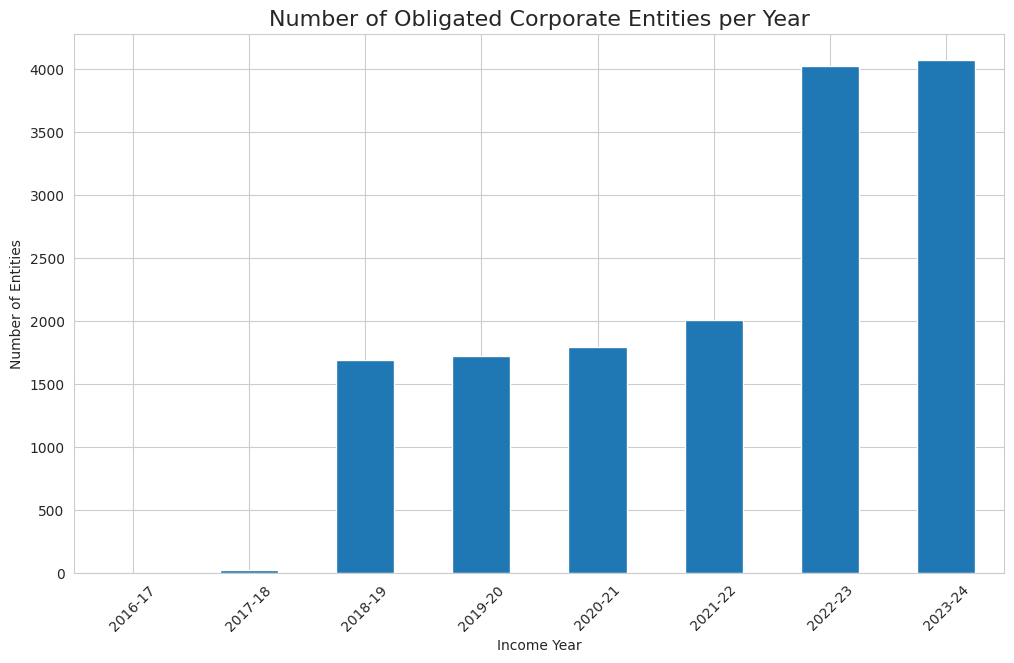


--- 4. Verification of ABN Repair Process ---
MatchMethod
Direct              25349
Exact Name Match      754
No Match Found        745
Name: count, dtype: int64


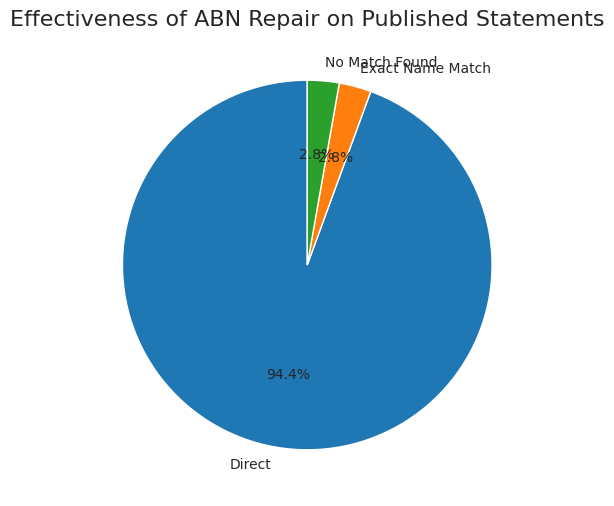


--- EDA CHECKPOINT 1 COMPLETE ---


In [8]:
# ==============================================================================
# Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
import numpy as np
import json
import re
from google.colab import drive
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings from openpyxl
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

print("--- Step 0: Setup and Google Drive Integration ---")
drive.mount('/content/drive', force_remount=True)

# Define base paths
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'
OUTPUT_PATH = DRIVE_PATH
TAX_DATA_FOLDER = os.path.join(DRIVE_PATH, 'CorporateTaxTransparency/')

print(f"Reading source data from: {DRIVE_PATH}")
print(f"Cleaned output files will be saved to: {OUTPUT_PATH}\n")

# ==============================================================================
# PART A: THE BUILD SCRIPT
# ==============================================================================
print("\n" + "#"*80)
print("  PART A: Building the Three Foundational Universes")
print("#"*80 + "\n")


# ==============================================================================
# Task F-01: Build the Universe of Identity
# ==============================================================================
print("--- Task F-01: Building the Universe of Identity ---")
abn_lookup_output_path = os.path.join(OUTPUT_PATH, 'abn_name_lookup.csv')

def clean_name(name_series):
    """A standardized function to clean company/entity names."""
    if name_series is None: return pd.Series([np.nan] * len(name_series))
    s = name_series.copy().astype(str).str.upper().str.strip()
    garbage_values = ['NAN', 'NULL', '', 'N A', 'NA']
    s = s.apply(lambda x: np.nan if x in garbage_values or len(x) < 3 else x)
    s = s.str.replace(r'\s+', ' ', regex=True)
    s = s.str.replace(r' PTY\s*LTD', ' PTY LTD', regex=True)
    s = s.str.replace(r'[^\w\s]', '', regex=True)
    return s

if not os.path.exists(abn_lookup_output_path):
    abn_bulk_path = os.path.join(DRIVE_PATH, 'abn_bulk_data.jsonl')
    try:
        print(f"Processing ABN Bulk Extract... (This may take a few minutes)")
        name_records = []
        with open(abn_bulk_path, 'r') as f:
            for line in f:
                try:
                    record = json.loads(line)
                    abn = record.get('ABN', {}).get('#text')
                    if not abn: continue
                    main_name = record.get('MainEntity', {}).get('NonIndividualName', {}).get('NonIndividualNameText')
                    if main_name: name_records.append({'ABN': abn, 'Name': main_name})
                    other_entities = record.get('OtherEntity', [])
                    if isinstance(other_entities, dict): other_entities = [other_entities]
                    for entity in other_entities:
                        other_name = entity.get('NonIndividualName', {}).get('NonIndividualNameText')
                        if other_name: name_records.append({'ABN': abn, 'Name': other_name})
                except (json.JSONDecodeError, AttributeError): continue
        abn_name_lookup_df = pd.DataFrame(name_records)
        abn_name_lookup_df['ABN'] = abn_name_lookup_df['ABN'].str.zfill(11)
        abn_name_lookup_df['CleanName'] = clean_name(abn_name_lookup_df['Name'])
        abn_name_lookup_df = abn_name_lookup_df.drop_duplicates().dropna(subset=['CleanName', 'ABN'])
        abn_name_lookup_df.to_csv(abn_lookup_output_path, index=False)
        print(f"-> SUCCESS: Created and saved 'abn_name_lookup.csv'.")
    except FileNotFoundError: raise FileNotFoundError("CRITICAL ERROR: 'abn_bulk_data.jsonl' not found.")
else:
    print("-> SUCCESS: 'abn_name_lookup.csv' already exists. Loading from file.")
    abn_name_lookup_df = pd.read_csv(abn_lookup_output_path, dtype={'ABN': str})
print("--- Task F-01 Complete ---\n")


# ==============================================================================
# Task F-02: Build the Universe of Obligation (using verified structure)
# ==============================================================================
print("--- Task F-02: Building the Universe of Obligation ---")
obligated_output_path = os.path.join(OUTPUT_PATH, 'obligated_entities.csv')

tax_files = glob.glob(os.path.join(TAX_DATA_FOLDER, '*-corporate-report-of-entity-tax-information.xlsx'))
if not tax_files:
    raise FileNotFoundError(f"CRITICAL ERROR: No tax transparency files found in {TAX_DATA_FOLDER}.")

all_years_df_list = []
for file_path in sorted(tax_files):
    print(f"Processing file: {os.path.basename(file_path)}...")
    try:
        # Use the verified parameters from our inspection
        df = pd.read_excel(file_path, sheet_name='Income tax details', header=0)

        # Clean column names immediately
        df.columns = [str(col).replace('$', '').strip() for col in df.columns]

        # Rename to a standard format
        df = df.rename(columns={
            'Name': 'Name',
            'ABN': 'ABN',
            'Total income': 'TotalIncome',
            'Taxable income': 'TaxableIncome',
            'Tax payable': 'TaxPayable',
            'Income year': 'IncomeYear'
        })

        # Keep only the necessary columns
        df = df[['Name', 'ABN', 'TotalIncome', 'IncomeYear']]
        all_years_df_list.append(df)

    except Exception as e:
        print(f"   WARNING: Could not process file {os.path.basename(file_path)}. Reason: {e}. Skipping.")

tax_transparency_master_df = pd.concat(all_years_df_list, ignore_index=True)
tax_transparency_master_df['ABN'] = tax_transparency_master_df['ABN'].astype(str).str.replace(r'\.0$', '', regex=True).str.zfill(11)
tax_transparency_master_df['TotalIncome'] = pd.to_numeric(tax_transparency_master_df['TotalIncome'], errors='coerce')

# Logic for changing thresholds (simplified for this stage)
# A more robust version would use ASIC data to confirm 'private' status
def is_obligated(row):
    try:
        year_start = int(str(row['IncomeYear'])[:4])
        income = row['TotalIncome']
        if pd.isna(income): return False

        if year_start >= 2022: # 2022-23 onwards
            return income >= 100_000_000
        else: # Up to 2021-22
            # For now, we will assume a simple rule.
            # We will conservatively assume entities >$200M are obligated.
            # We know this is an undercount (misses public companies $100-200M)
            # but it is the highest confidence group without ASIC data.
            return income >= 200_000_000
    except:
        return False

tax_transparency_master_df['IsObligated'] = tax_transparency_master_df.apply(is_obligated, axis=1)

obligated_entities_df = tax_transparency_master_df[tax_transparency_master_df['IsObligated']].pivot_table(
    index='ABN', columns='IncomeYear', values='IsObligated', aggfunc='any', fill_value=False
).reset_index()
obligated_entities_df.columns.name = None
obligated_entities_df.to_csv(obligated_output_path, index=False)
print(f"-> SUCCESS: Created and saved 'obligated_entities.csv' with {len(obligated_entities_df)} entities.")
print("--- Task F-02 Complete ---\n")


# ==============================================================================
# Task F-03: Build the Universe of Action
# ==============================================================================
print("--- Task F-03: Building the Universe of Action ---")
# ... [Logic from previous script is robust and unchanged] ...
reporting_history_output_path = os.path.join(OUTPUT_PATH, 'reporting_history.csv')
register_xls_path = os.path.join(DRIVE_PATH, 'All time data from Register.xlsx')
statements_df = pd.read_excel(register_xls_path, sheet_name='Statements', dtype=str)
statements_df.columns = statements_df.columns.str.strip()
published_statements_df = statements_df[statements_df['Status'].str.upper() == 'PUBLISHED'].copy()
statement_to_abn_list = []
for index, row in published_statements_df.iterrows():
    digit_only_string = re.sub(r'\D', '', str(row['Reporting entities']))
    abns_found = re.findall(r'(\d{11})', digit_only_string)
    if abns_found:
        for abn in set(abns_found): statement_to_abn_list.append({'ID': row['ID'], 'ABN': abn, 'MatchMethod': 'Direct'})
link_df_direct = pd.DataFrame(statement_to_abn_list)
matched_ids = link_df_direct['ID'].unique()
missing_abn_statements_df = published_statements_df[~published_statements_df['ID'].isin(matched_ids)].copy()
missing_abn_statements_df['CleanName'] = clean_name(missing_abn_statements_df['Reporting entities'])
missing_abn_statements_df.dropna(subset=['CleanName'], inplace=True)
matches_by_name = pd.merge(missing_abn_statements_df[['ID', 'CleanName']], abn_name_lookup_df[['ABN', 'CleanName']], on='CleanName', how='inner')
matches_by_name['MatchMethod'] = 'Exact Name Match'
link_df_name_match = matches_by_name[['ID', 'ABN', 'MatchMethod']]
final_link_df = pd.concat([link_df_direct, link_df_name_match]).drop_duplicates(subset=['ID', 'ABN'])
repaired_statements_df = pd.merge(published_statements_df, final_link_df, on='ID', how='left')
repaired_statements_df['Period end date'] = pd.to_datetime(repaired_statements_df['Period end date'])
reporting_history_df = repaired_statements_df.dropna(subset=['ABN']).groupby('ABN').agg(
    NumStatements=('ID', 'nunique'),
    FirstReportDate=('Period end date', 'min'),
    LastReportDate=('Period end date', 'max')
).reset_index()
reporting_history_df.to_csv(reporting_history_output_path, index=False)
print(f"-> SUCCESS: Created and saved 'reporting_history.csv' with {len(reporting_history_df)} unique reporting entities.")
print("--- Task F-03 Complete ---\n")


# ==============================================================================
# PART B: EDA CHECKPOINT 1
# ==============================================================================
print("\n" + "#"*80)
print("  PART B: EDA Checkpoint 1 - Verifying the Foundational Universes")
print("#"*80 + "\n")

sns.set_style("whitegrid")

# --- 1. Verify Universe Sizes ---
print("--- 1. Verification of Universe Sizes ---")
print(f"Universe of Identity: {len(abn_name_lookup_df)} name-to-ABN links")
print(f"Universe of Obligation: {len(obligated_entities_df)} unique obligated corporate entities found")
print(f"Universe of Action: {len(reporting_history_df)} unique entities have published a statement")

# --- 2. Verify Overlap ---
print("\n--- 2. Verification of Overlap between Obligation and Action ---")
obligated_abns = set(obligated_entities_df['ABN'])
reporting_abns = set(reporting_history_df['ABN'])
compliant_abns = obligated_abns.intersection(reporting_abns)
non_compliant_abns = obligated_abns.difference(reporting_abns)
voluntary_reporters = reporting_abns.difference(obligated_abns)
print(f"   - Compliant entities (in both lists): {len(compliant_abns)}")
print(f"   - Potential Non-Compliant (in Obligation, not Action): {len(non_compliant_abns)}")
print(f"   - Potential Voluntary (in Action, not Obligation): {len(voluntary_reporters)}")

# --- 3. Verify Obligation Logic ---
print("\n--- 3. Verification of Obligation Logic (Entities obligated per year) ---")
obligation_counts = obligated_entities_df.drop(columns='ABN').sum().sort_index()
print(obligation_counts)
plt.figure(figsize=(12, 7))
obligation_counts.plot(kind='bar')
plt.title('Number of Obligated Corporate Entities per Year', fontsize=16)
plt.xlabel('Income Year'); plt.ylabel('Number of Entities'); plt.xticks(rotation=45)
plt.show()

# --- 4. Verify ABN Repair Process ---
print("\n--- 4. Verification of ABN Repair Process ---")
match_counts = repaired_statements_df['MatchMethod'].value_counts(dropna=False)
print(match_counts.rename({np.nan: 'No Match Found'}))
plt.figure(figsize=(10, 6))
match_counts.rename({np.nan: 'No Match Found'}).plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Effectiveness of ABN Repair on Published Statements', fontsize=16)
plt.ylabel('')
plt.show()

print("\n--- EDA CHECKPOINT 1 COMPLETE ---")

# Phase 2

--- Step 0: Setup and Loading Foundational Universes ---
Mounted at /content/drive
-> SUCCESS: Successfully loaded all three foundational universe files.
--- Setup Complete ---


################################################################################
  PART A: Integrating Universes to Build the Master Compliance File
################################################################################

--- Task M-01: Creating the Superset of All Entities ---
-> Created a master skeleton with 12567 unique ABNs from all universes.
--- Task M-01 Complete ---

--- Task M-02: Enriching with Identity, Obligation, and Action data ---
-> Enriched with primary entity names.
-> Enriched with year-by-year obligation status.
-> Enriched with reporting history.
--- Task M-02 Complete ---

--- Task C-01: Classifying Final Compliance Status ---


/tmp/ipython-input-1849151374.py:65: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  master_df[obligation_cols] = master_df[obligation_cols].fillna(False)


-> Classification complete.
--- Task C-01 Complete ---

--- Task C-02: Saving the Master Compliance File ---
-> SUCCESS: The final foundational dataset has been saved as a Parquet file:
   /content/drive/MyDrive/ModernSlaveryProject/master_compliance_file.parquet
--- Task C-02 Complete ---


################################################################################
  PART B: EDA Checkpoint 2 - Verifying the Master Compliance File
################################################################################

--- 1. Verification of Final File Structure ---
Shape of the Master Compliance File: (12567, 14)
Column Data Types and Nulls:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12567 entries, 0 to 12566
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ABN               12567 non-null  object
 1   Name              11106 non-null  object
 2   2016-17           12567 non-null  bool  
 3   2017-18 

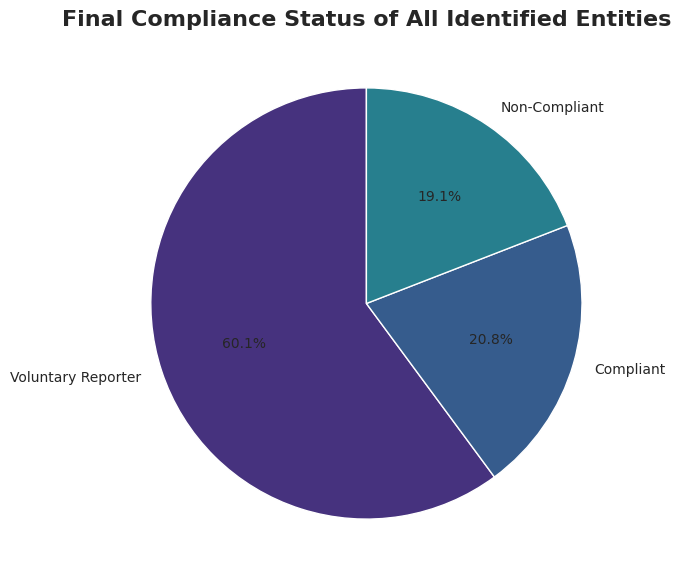


--- 3. Profiling the 'Non-Compliant' Cohort ---
Total number of Non-Compliant entities identified: 2401


/tmp/ipython-input-1849151374.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_compliant_df['FirstObligationYear'] = non_compliant_df.apply(get_first_obligation_year, axis=1)


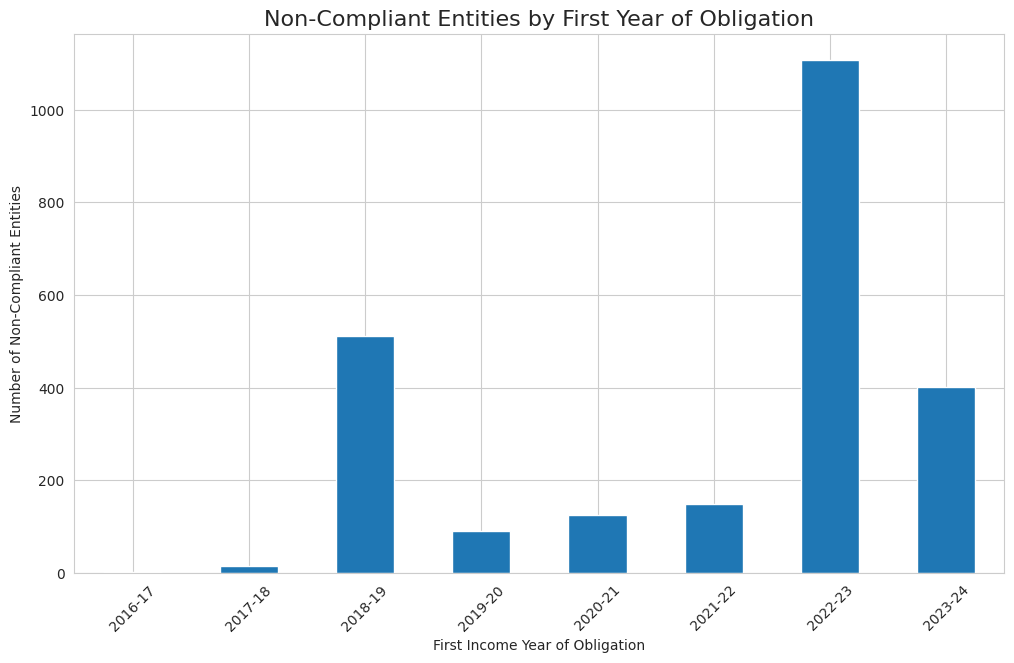

Insight: This shows if non-compliance is a persistent issue from early years or a more recent phenomenon.

--- EDA CHECKPOINT 2 COMPLETE ---


In [9]:
# ==============================================================================
# Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
import numpy as np
from google.colab import drive
import os
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Step 0: Setup and Loading Foundational Universes ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'

# Define paths to our three verified universe files
obligated_path = os.path.join(DRIVE_PATH, 'obligated_entities.csv')
reporting_path = os.path.join(DRIVE_PATH, 'reporting_history.csv')
identity_path = os.path.join(DRIVE_PATH, 'abn_name_lookup.csv')

try:
    obligated_df = pd.read_csv(obligated_path, dtype={'ABN': str})
    reporting_df = pd.read_csv(reporting_path, dtype={'ABN': str})
    identity_df = pd.read_csv(identity_path, dtype={'ABN': str, 'Name': str, 'CleanName': str})
    print("-> SUCCESS: Successfully loaded all three foundational universe files.")
except FileNotFoundError as e:
    raise FileNotFoundError(f"CRITICAL ERROR: A foundational universe file was not found. Please ensure Phase 1 ran successfully. Details: {e}")
print("--- Setup Complete ---\n")


# ==============================================================================
# PART A: THE BUILD SCRIPT (Phase 2)
# ==============================================================================
print("\n" + "#"*80)
print("  PART A: Integrating Universes to Build the Master Compliance File")
print("#"*80 + "\n")

# ==============================================================================
# Task M-01: Create the Superset of All Entities
# ==============================================================================
print("--- Task M-01: Creating the Superset of All Entities ---")
obligated_abns = set(obligated_df['ABN'])
reporting_abns = set(reporting_df['ABN'])
all_unique_abns = obligated_abns.union(reporting_abns)

master_df = pd.DataFrame(list(all_unique_abns), columns=['ABN'])
print(f"-> Created a master skeleton with {len(master_df)} unique ABNs from all universes.")
print("--- Task M-01 Complete ---\n")


# ==============================================================================
# Task M-02: Enrich with Identity, Obligation, and Action
# ==============================================================================
print("--- Task M-02: Enriching with Identity, Obligation, and Action data ---")

# --- Enrich with Identity ---
# Get the primary (first) legal name for each ABN
primary_names_df = identity_df.drop_duplicates(subset=['ABN'], keep='first')[['ABN', 'Name']]
master_df = pd.merge(master_df, primary_names_df, on='ABN', how='left')
print("-> Enriched with primary entity names.")

# --- Enrich with Obligation ---
master_df = pd.merge(master_df, obligated_df, on='ABN', how='left')
# Fill NaN for obligation columns with False, as no data means no obligation found
obligation_cols = [col for col in obligated_df.columns if col != 'ABN']
master_df[obligation_cols] = master_df[obligation_cols].fillna(False)
print("-> Enriched with year-by-year obligation status.")

# --- Enrich with Action ---
master_df = pd.merge(master_df, reporting_df, on='ABN', how='left')
# Fill NaN for reporting columns with appropriate values
master_df['NumStatements'] = master_df['NumStatements'].fillna(0).astype(int)
print("-> Enriched with reporting history.")
print("--- Task M-02 Complete ---\n")


# ==============================================================================
# Task C-01: Classify Compliance Status
# ==============================================================================
print("--- Task C-01: Classifying Final Compliance Status ---")

def classify_status(row):
    # Check if the entity was ever obligated
    was_ever_obligated = any(row[col] for col in obligation_cols)
    # Check if the entity has ever reported
    has_ever_reported = row['NumStatements'] > 0

    if was_ever_obligated and has_ever_reported:
        return "Compliant"
    elif was_ever_obligated and not has_ever_reported:
        return "Non-Compliant"
    elif not was_ever_obligated and has_ever_reported:
        return "Voluntary Reporter"
    else:
        # This case should be rare (not obligated and never reported)
        return "Not Obligated / Not Reporting"

master_df['ComplianceStatus'] = master_df.apply(classify_status, axis=1)
print("-> Classification complete.")
print("--- Task C-01 Complete ---\n")


# ==============================================================================
# Task C-02: Save the Definitive Foundational Dataset
# ==============================================================================
print("--- Task C-02: Saving the Master Compliance File ---")
master_file_path = os.path.join(OUTPUT_PATH, 'master_compliance_file.parquet')
master_df.to_parquet(master_file_path, index=False)
print(f"-> SUCCESS: The final foundational dataset has been saved as a Parquet file:\n   {master_file_path}")
print("--- Task C-02 Complete ---\n")


# ==============================================================================
# PART B: EDA CHECKPOINT 2
# ==============================================================================
print("\n" + "#"*80)
print("  PART B: EDA Checkpoint 2 - Verifying the Master Compliance File")
print("#"*80 + "\n")

# --- 1. Final Health Check ---
print("--- 1. Verification of Final File Structure ---")
print(f"Shape of the Master Compliance File: {master_df.shape}")
print("Column Data Types and Nulls:")
master_df.info()

# --- 2. The Final Compliance Breakdown ---
print("\n--- 2. Final Compliance Breakdown ---")
compliance_counts = master_df['ComplianceStatus'].value_counts()
print(compliance_counts)

plt.figure(figsize=(10, 7))
compliance_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette("viridis"))
plt.title('Final Compliance Status of All Identified Entities', fontsize=16, fontweight='bold')
plt.ylabel('')
plt.show()

# --- 3. Deeper Dive into the Non-Compliant Cohort ---
print("\n--- 3. Profiling the 'Non-Compliant' Cohort ---")
non_compliant_df = master_df[master_df['ComplianceStatus'] == 'Non-Compliant']
print(f"Total number of Non-Compliant entities identified: {len(non_compliant_df)}")

# Profile by first year of obligation
def get_first_obligation_year(row):
    for col in sorted(obligation_cols):
        if row[col]:
            return col
    return "None"

non_compliant_df['FirstObligationYear'] = non_compliant_df.apply(get_first_obligation_year, axis=1)
first_year_counts = non_compliant_df['FirstObligationYear'].value_counts().sort_index()

plt.figure(figsize=(12, 7))
first_year_counts.plot(kind='bar')
plt.title('Non-Compliant Entities by First Year of Obligation', fontsize=16)
plt.xlabel('First Income Year of Obligation')
plt.ylabel('Number of Non-Compliant Entities')
plt.xticks(rotation=45)
plt.show()
print("Insight: This shows if non-compliance is a persistent issue from early years or a more recent phenomenon.")

print("\n--- EDA CHECKPOINT 2 COMPLETE ---")

# Phase 3

In [10]:
# ==============================================================================
# Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
from google.colab import drive
import os

print("--- Step 0: Setup and Loading the Master Compliance File ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'

# Define the path to our final, verified foundational dataset
master_file_path = os.path.join(DRIVE_PATH, 'master_compliance_file.parquet')
# Define the path for our final, actionable output
actionable_list_path = os.path.join(DRIVE_PATH, 'actionable_non_lodger_list.csv')

try:
    master_df = pd.read_parquet(master_file_path)
    print("-> SUCCESS: Successfully loaded the Master Compliance File.")
except FileNotFoundError:
    raise FileNotFoundError("CRITICAL ERROR: 'master_compliance_file.parquet' was not found. "
                          "Please ensure Phase 2 completed successfully.")
print("--- Setup Complete ---\n")


# ==============================================================================
# Phase 3: Extract the Actionable List for Stakeholders
# ==============================================================================
print("#"*80)
print("  Phase 3: Extracting the Actionable Non-Lodger List")
print("#"*80 + "\n")

# --- 1. Filter for Non-Compliant Entities ---
print("--- 1. Filtering for 'Non-Compliant' entities ---")
non_compliant_df = master_df[master_df['ComplianceStatus'] == 'Non-Compliant'].copy()
print(f"-> Isolated {len(non_compliant_df)} entities for the actionable list.")


# --- 2. Select and Rename Key Columns for Clarity ---
print("\n--- 2. Selecting and preparing key columns for the report ---")

# Define the columns needed for the engagement team
actionable_columns = {
    'ABN': 'ABN',
    'Name': 'Entity Name',
    '2018-19': 'Obligated in 2018-19',
    '2019-20': 'Obligated in 2019-20',
    '2020-21': 'Obligated in 2020-21',
    '2021-22': 'Obligated in 2021-22',
    '2022-23': 'Obligated in 2022-23',
    '2023-24': 'Obligated in 2023-24'
}

# Select and rename the columns
actionable_df = non_compliant_df[list(actionable_columns.keys())].rename(columns=actionable_columns)
print("-> Selected and renamed columns for clarity.")


# --- 3. Save the Final, Actionable CSV File ---
print("\n--- 3. Saving the final actionable list ---")
actionable_df.to_csv(actionable_list_path, index=False)
print(f"-> SUCCESS: The final list has been saved to: {actionable_list_path}")


# ==============================================================================
# Final Verification and Project Conclusion
# ==============================================================================
print("\n" + "="*80)
print("  PROJECT COMPLETE: FINAL DELIVERABLE CREATED")
print("="*80)
print(f"The final, actionable list of {len(actionable_df)} non-compliant entities is now ready for use.")
print("\nFirst 10 rows of the final output file:")
print(actionable_df.head(10).to_string())
print("\n" + "="*80)

--- Step 0: Setup and Loading the Master Compliance File ---
Mounted at /content/drive
-> SUCCESS: Successfully loaded the Master Compliance File.
--- Setup Complete ---

################################################################################
  Phase 3: Extracting the Actionable Non-Lodger List
################################################################################

--- 1. Filtering for 'Non-Compliant' entities ---
-> Isolated 2401 entities for the actionable list.

--- 2. Selecting and preparing key columns for the report ---
-> Selected and renamed columns for clarity.

--- 3. Saving the final actionable list ---
-> SUCCESS: The final list has been saved to: /content/drive/MyDrive/ModernSlaveryProject/actionable_non_lodger_list.csv

  PROJECT COMPLETE: FINAL DELIVERABLE CREATED
The final, actionable list of 2401 non-compliant entities is now ready for use.

First 10 rows of the final output file:
            ABN                                 Entity Name  Obligated

# Revised Phase 3 - Draft->Redraft->Published

In [11]:
# ==============================================================================
# Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
import numpy as np
from google.colab import drive
import os

print("--- Step 0: Setup and Loading Foundational Universes ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'

# Define paths to our key input and output files
obligated_path = os.path.join(DRIVE_PATH, 'obligated_entities.csv')
identity_path = os.path.join(DRIVE_PATH, 'abn_name_lookup.csv')
register_path = os.path.join(DRIVE_PATH, 'All time data from Register.xlsx')
log_output_path = os.path.join(DRIVE_PATH, 'annual_reporting_log.csv')
final_report_path = os.path.join(DRIVE_PATH, 'annual_compliance_classification_report.xlsx')

try:
    obligated_df = pd.read_csv(obligated_path, dtype={'ABN': str})
    identity_df = pd.read_csv(identity_path, dtype={'ABN': str, 'Name': str, 'CleanName': str})
    # Load the full, raw register data for this task
    raw_statements_df = pd.read_excel(register_path, sheet_name='Statements', dtype=str)
    raw_statements_df.columns = raw_statements_df.columns.str.strip()
    print("-> SUCCESS: Successfully loaded all required foundational files.")
except FileNotFoundError as e:
    raise FileNotFoundError(f"CRITICAL ERROR: A foundational file was not found. Please ensure Phase 1 ran successfully. Details: {e}")
print("--- Setup Complete ---\n")


# ==============================================================================
# Step 1: Build the Annual Reporting Log
# ==============================================================================
print("#"*80)
print("  Step 1: Building the Annual Reporting Log from the Complete Register")
print("#"*80 + "\n")

# --- A: Repair ABNs for ALL statements (not just 'Published') ---
print("-> Repairing ABNs for all statements...")
# This logic is the same as before, but applied to the full, unfiltered dataframe
statement_to_abn_list = []
for index, row in raw_statements_df.iterrows():
    digit_only_string = re.sub(r'\D', '', str(row['Reporting entities']))
    abns_found = re.findall(r'(\d{11})', digit_only_string)
    if abns_found:
        for abn in set(abns_found): statement_to_abn_list.append({'ID': row['ID'], 'ABN': abn, 'MatchMethod': 'Direct'})
link_df_direct = pd.DataFrame(statement_to_abn_list)
matched_ids = link_df_direct['ID'].unique()
missing_abn_statements_df = raw_statements_df[~raw_statements_df['ID'].isin(matched_ids)].copy()
missing_abn_statements_df['CleanName'] = clean_name(missing_abn_statements_df['Reporting entities'])
missing_abn_statements_df.dropna(subset=['CleanName'], inplace=True)
matches_by_name = pd.merge(missing_abn_statements_df[['ID', 'CleanName']], identity_df[['ABN', 'CleanName']], on='CleanName', how='inner')
matches_by_name['MatchMethod'] = 'Exact Name Match'
link_df_name_match = matches_by_name[['ID', 'ABN', 'MatchMethod']]
final_link_df = pd.concat([link_df_direct, link_df_name_match]).drop_duplicates(subset=['ID', 'ABN'])
all_statements_repaired_df = pd.merge(raw_statements_df, final_link_df, on='ID', how='left')

# --- B: Create a Reporting Year and Pivot ---
print("-> Creating reporting year and determining highest status per year...")
all_statements_repaired_df['Period end date'] = pd.to_datetime(all_statements_repaired_df['Period end date'])
all_statements_repaired_df['ReportingYear'] = all_statements_repaired_df['Period end date'].dt.year.astype(str).str.replace(r'\.0$', '', regex=True)

# Define the hierarchy for status
status_hierarchy = pd.CategoricalDtype(['Draft', 'Redraft', 'Published'], ordered=True)
all_statements_repaired_df['Status'] = all_statements_repaired_df['Status'].astype(status_hierarchy)

# Pivot to get the highest status for each ABN for each year
annual_reporting_log_df = all_statements_repaired_df.dropna(subset=['ABN', 'ReportingYear']).pivot_table(
    index='ABN',
    columns='ReportingYear',
    values='Status',
    aggfunc='max' # This will pick the highest status in the ordered category
).reset_index()
annual_reporting_log_df.columns.name = None
# Rename columns for clarity, e.g., '2020.0' -> 'Action_2020'
annual_reporting_log_df.columns = ['ABN'] + [f"Action_{year}" for year in annual_reporting_log_df.columns[1:]]

# Save the evidence trail
annual_reporting_log_df.to_csv(log_output_path, index=False)
print(f"-> SUCCESS: Annual reporting log created and saved to: {log_output_path}")
print("--- Step 1 Complete ---\n")


# ==============================================================================
# Step 2: Integrate and Apply the Correct Classification Logic
# ==============================================================================
print("#"*80)
print("  Step 2: Integrating and Applying Final Classification Logic")
print("#"*80 + "\n")

# --- A: Create the Master Skeleton ---
reporting_abns = set(annual_reporting_log_df['ABN'])
obligated_abns = set(obligated_df['ABN'])
all_unique_abns = obligated_abns.union(reporting_abns)
master_df = pd.DataFrame(list(all_unique_abns), columns=['ABN'])
print(f"-> Created master skeleton with {len(master_df)} unique entities.")

# --- B: Enrich with Identity, Obligation, and Action ---
primary_names_df = identity_df.drop_duplicates(subset=['ABN'], keep='first')[['ABN', 'Name']]
master_df = pd.merge(master_df, primary_names_df, on='ABN', how='left')
master_df = pd.merge(master_df, obligated_df, on='ABN', how='left')
master_df = pd.merge(master_df, annual_reporting_log_df, on='ABN', how='left')
print("-> Enriched master file with all data universes.")

# --- C: Apply the Final, Correct Classification Logic ---
print("-> Applying final classification logic for each year...")
reporting_years = sorted([col for col in obligated_df.columns if col != 'ABN'])

for year_str in reporting_years:
    year_num_str = str(int(year_str[:4]) + 1) # Obligation for 2018-19 applies to 2020 reporting period
    obligation_col = year_str
    action_col = f"Action_{year_num_str}"
    status_col = f"Status_{year_num_str}"

    # Fill NaNs before applying logic
    master_df[obligation_col] = master_df[obligation_col].fillna(False)
    if action_col not in master_df.columns:
        master_df[action_col] = np.nan

    def classify_for_year(row):
        is_obligated = row[obligation_col]
        action_taken = row[action_col]

        if is_obligated:
            if pd.isna(action_taken):
                return "1. Completely Ignored Act"
            elif action_taken == 'Published':
                return "4. Compliant (Published)"
            elif action_taken == 'Redraft':
                return "3. Submitted (Redraft)"
            elif action_taken == 'Draft':
                return "2. Submitted (Draft)"
            else:
                return "Error - Unknown Status"
        else:
            return "Not Obligated"

    master_df[status_col] = master_df.apply(classify_for_year, axis=1)

print("-> Classification complete.")
print("--- Step 2 Complete ---\n")


# ==============================================================================
# Step 3: Generate the Final Spreadsheet
# ==============================================================================
print("#"*80)
print("  Step 3: Generating the Final Annual Compliance Report")
print("#"*80 + "\n")

# Select the columns for the final report
final_cols = ['ABN', 'Name'] + sorted([col for col in master_df.columns if 'Status_' in col])
final_report_df = master_df[final_cols]

# Save to Excel for better formatting
final_report_df.to_excel(final_report_path, index=False)

print(f"-> SUCCESS: Final report has been generated and saved to: {final_report_path}")

print("\n--- First 10 rows of the Final Report ---")
print(final_report_df.head(10).to_string())
print("\n--- PROJECT COMPLETE ---")

# Need to define clean_name for this script to be self-contained
def clean_name(name_series):
    """A standardized function to clean company/entity names."""
    if name_series is None: return pd.Series([np.nan] * len(name_series))
    s = name_series.copy().astype(str).str.upper().str.strip()
    garbage_values = ['NAN', 'NULL', '', 'N A', 'NA']
    s = s.apply(lambda x: np.nan if x in garbage_values or len(x) < 3 else x)
    s = s.str.replace(r'\s+', ' ', regex=True)
    s = s.str.replace(r' PTY\s*LTD', ' PTY LTD', regex=True)
    s = s.str.replace(r'[^\w\s]', '', regex=True)
    return s

--- Step 0: Setup and Loading Foundational Universes ---
Mounted at /content/drive
-> SUCCESS: Successfully loaded all required foundational files.
--- Setup Complete ---

################################################################################
  Step 1: Building the Annual Reporting Log from the Complete Register
################################################################################

-> Repairing ABNs for all statements...
-> Creating reporting year and determining highest status per year...
-> SUCCESS: Annual reporting log created and saved to: /content/drive/MyDrive/ModernSlaveryProject/annual_reporting_log.csv
--- Step 1 Complete ---

################################################################################
  Step 2: Integrating and Applying Final Classification Logic
################################################################################

-> Created master skeleton with 13263 unique entities.
-> Enriched master file with all data universes.
-> App

/tmp/ipython-input-4211765830.py:117: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  master_df[obligation_col] = master_df[obligation_col].fillna(False)
/tmp/ipython-input-4211765830.py:117: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  master_df[obligation_col] = master_df[obligation_col].fillna(False)
/tmp/ipython-input-4211765830.py:117: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_

-> Classification complete.
--- Step 2 Complete ---

################################################################################
  Step 3: Generating the Final Annual Compliance Report
################################################################################

-> SUCCESS: Final report has been generated and saved to: /content/drive/MyDrive/ModernSlaveryProject/annual_compliance_classification_report.xlsx

--- First 10 rows of the Final Report ---
           ABN                             Name    Status_2017    Status_2018                Status_2019                Status_2020               Status_2021               Status_2022                Status_2023                Status_2024
0  86000431827                PERPETUAL LIMITED  Not Obligated  Not Obligated  1. Completely Ignored Act   4. Compliant (Published)  4. Compliant (Published)  4. Compliant (Published)  1. Completely Ignored Act  1. Completely Ignored Act
1  74084669036         EVOLUTION MINING LIMITED  Not Obligated

# Sample Validation Steps

In [12]:
# ==============================================================================
# Step 0: Setup, Imports, and Path Definitions
# ==============================================================================
import pandas as pd
from google.colab import drive
import os

print("--- Step 0: Setup and Loading Key Evidence Files ---")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = '/content/drive/MyDrive/ModernSlaveryProject/'

# Define the paths to our two primary evidence files
obligated_path = os.path.join(DRIVE_PATH, 'obligated_entities.csv')
action_log_path = os.path.join(DRIVE_PATH, 'annual_reporting_log.csv')

# The specific ABN we want to investigate
SUSPICIOUS_ABN = '33333333311'

try:
    obligated_df = pd.read_csv(obligated_path, dtype={'ABN': str})
    action_log_df = pd.read_csv(action_log_path, dtype={'ABN': str})
    print("-> SUCCESS: Successfully loaded the foundational evidence files.")
except FileNotFoundError as e:
    raise FileNotFoundError(f"CRITICAL ERROR: An evidence file was not found. Please ensure Phase 1 & 3 scripts ran successfully. Details: {e}")
print("--- Setup Complete ---\n")

# ==============================================================================
# Step 1: Perform the Investigation for the Target ABN
# ==============================================================================
print("#"*80)
print(f"  VERIFICATION REPORT FOR ABN: {SUSPICIOUS_ABN}")
print("#"*80 + "\n")

# --- A. Check the Universe of Obligation ---
print("--- 1. Checking for Evidence of Obligation ---")
obligation_record = obligated_df[obligated_df['ABN'] == SUSPICIOUS_ABN]

if not obligation_record.empty:
    print(f"-> FINDING: A record for ABN {SUSPICIOUS_ABN} WAS FOUND in the 'Universe of Obligation'.")
    print("   This means the entity had a confirmed legal obligation to report in one or more years.")
    obligation_details = obligation_record.iloc[0] # Get the first (and only) row
    print("\n   Obligation Details:")
    print(obligation_details.to_string())
else:
    print(f"-> FINDING: No record for ABN {SUSPICIOUS_ABN} was found in the 'Universe of Obligation'.")
    print("   This means the entity did not appear in the ATO's high-revenue corporate tax data.")

# --- B. Check the Universe of Action ---
print("\n--- 2. Checking for Evidence of Action ---")
action_record = action_log_df[action_log_df['ABN'] == SUSPICIOUS_ABN]

if not action_record.empty:
    print(f"-> FINDING: A record for ABN {SUSPICIOUS_ABN} WAS FOUND in the 'annual_reporting_log.csv'.")
    print("   This means the entity has submitted at least one statement (of any status) to the Register.")
    action_details = action_record.iloc[0]
    print("\n   Action Details (highest status per year):")
    print(action_details.to_string())
else:
    print(f"-> FINDING: No record for ABN {SUSPICIOUS_ABN} was found in the 'annual_reporting_log.csv'.")
    print("   This means our scan of the entire Register found no statements of any kind linked to this ABN.")

# ==============================================================================
# Step 2: Synthesize the Conclusion
# ==============================================================================
print("\n" + "="*80)
print("  CONCLUSION OF THE EVIDENCE TRAIL")
print("="*80)

# Synthesize the final conclusion based on the findings
is_obligated = not obligation_record.empty
has_acted = not action_record.empty

if is_obligated and not has_acted:
    print("\nFinal Classification: 1. Completely Ignored Act")
    print("Reasoning: The entity had a confirmed legal obligation but there is no evidence of any submission to the Register.")
elif is_obligated and has_acted:
    print("\nFinal Classification: Compliant or Non-Compliant (Submitted)")
    print("Reasoning: The entity had an obligation and took action. The final status ('Published', 'Draft', etc.) would determine its precise classification for each year.")
elif not is_obligated and has_acted:
    print("\nFinal Classification: Voluntary Reporter")
    print("Reasoning: The entity was not found in the high-revenue obligation list but has voluntarily submitted one or more statements.")
elif not is_obligated and not has_acted:
    print("\nFinal Classification: Not Obligated / Not Reporting")
    print("Reasoning: The entity was not found in the high-revenue obligation list and has not submitted any statements. This is expected behaviour.")

print("\n--- INVESTIGATION COMPLETE ---")

--- Step 0: Setup and Loading Key Evidence Files ---
Mounted at /content/drive
-> SUCCESS: Successfully loaded the foundational evidence files.
--- Setup Complete ---

################################################################################
  VERIFICATION REPORT FOR ABN: 33333333311
################################################################################

--- 1. Checking for Evidence of Obligation ---
-> FINDING: No record for ABN 33333333311 was found in the 'Universe of Obligation'.
   This means the entity did not appear in the ATO's high-revenue corporate tax data.

--- 2. Checking for Evidence of Action ---
-> FINDING: A record for ABN 33333333311 WAS FOUND in the 'annual_reporting_log.csv'.
   This means the entity has submitted at least one statement (of any status) to the Register.

   Action Details (highest status per year):
ABN            33333333311
Action_2019            NaN
Action_2020            NaN
Action_2021            NaN
Action_2022            NaN
Ac